# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

In [123]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload
from time import sleep
# Third-Party Library Imports
import numpy as np
import pandas as pd
import dask
import xarray as xr
# import climtas
from typing import NamedTuple
from enum import Enum
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
from functools import partial
from glob import glob
import cftime
import string
from numpy.typing import ArrayLike
# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'zecmip_stabilisation'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_zecmip
import utils
# import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import signal_to_noise_calculations as sn_calc

import my_stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='dask.*')
warnings.filterwarnings("ignore", category=Warning)
# # Logging
# logger = utils.get_notebook_logger()

In [124]:
# !{sys.executable} -m pip install pyEMD


In [125]:
# from PyEMD import EEMD, EMD, CEEMDAN

In [126]:
# from PyEMD import EEMD

In [127]:
from scipy.stats import spearmanr
from matplotlib.colors import BoundaryNorm
from scipy.stats import linregress
from matplotlib import ticker as mticker
import pymannkendall as mk

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import r2_score
import scipy.stats as stats
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from scipy import stats

In [128]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'list_xarray'))
# from listXarray import listXarray
# import listXarray as lxr
from listXarray import listXarray, where, apply_ufunc, read_listxarray
# reload(lxr)
# from listXarray import array_function

In [129]:
# import listXarray
# reload(listXarray)
# from listXarray import listXarray

In [130]:
np.set_printoptions(precision=2, suppress=True, edgeitems=1)
xr.set_options(display_expand_data=False)

In [131]:
# client.close()

In [132]:
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1, n_workers=12)
client

- State start
-   Scheduler at:     tcp://127.0.0.1:39553
-   dashboard at:        /proxy/40555/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:44861'
-         Start Nanny at: 'tcp://127.0.0.1:36225'
-         Start Nanny at: 'tcp://127.0.0.1:46369'
-         Start Nanny at: 'tcp://127.0.0.1:35325'
-         Start Nanny at: 'tcp://127.0.0.1:40715'
-         Start Nanny at: 'tcp://127.0.0.1:40127'
-         Start Nanny at: 'tcp://127.0.0.1:46595'
-         Start Nanny at: 'tcp://127.0.0.1:37451'
-         Start Nanny at: 'tcp://127.0.0.1:32933'
-         Start Nanny at: 'tcp://127.0.0.1:33845'
-         Start Nanny at: 'tcp://127.0.0.1:43315'
-         Start Nanny at: 'tcp://127.0.0.1:38771'
- Register worker <WorkerState 'tcp://127.0.0.1:45227', name: 10, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:45227
- Starting established connection to tcp://127.0.0.1:43802
- Register worker <WorkerState 'tcp://12

<Client: 'tcp://127.0.0.1:39553' processes=12 threads=12>

# Calculations

In [133]:
ecs_dict = {
    'NorESM2-LM': 2.54,
    'MIROC-ES2L': 2.7,
    'MPI-ESM1-2-LR': 2.83,
    'GISS-E2-1-G-CC': 2.9,
    'GFDL-ESM4': 3.1,
    'ACCESS-ESM1-5': 3.87,
    'CESM2': 5.1,
    'UKESM1-0-LL': 5.4,
    'CanESM5': 5.7
}

# This comes from the ZEC nat var paper
tcre_dict = {
    'ACCESS-ESM1-5': 1.81,
    'CESM2': 2.01,
    'CanESM5': 2.10,
    'GFDL-ESM4': 1.36,
    'GISS-E2-1-G-CC': 1.68,
    'MIROC-ES2L': 1.36,
    'MPI-ESM1-2-LR': 1.65,
    'NorESM2-LM': 1.42,
    'UKESM1-0-LL': 2.65
}

## Opening Data

In [134]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [135]:
chunks_model_based = {
    'ACCESS-ESM1-5': {'time':-1, 'lat':int(145/4), 'lon':int(192/2)},   # too big
    'CESM2': {'time':-1, 'lat':int(145/4), 'lon':int(192/4)},
    'CanESM5': {'time':-1, 'lat':int(64/4), 'lon':int(128/4)},
    'GFDL-ESM4': {'time':-1, 'lat':int(180/3), 'lon':int(144/4)},
    'GISS-E2-1-G-CC': {'time':-1, 'lat':int(90/2), 'lon':int(192/4)},
    'MIROC-ES2L': {'time':-1, 'lat':int(64/2), 'lon':int(128/2)},
    'MPI-ESM1-2-LR': {'time':-1, 'lat':int(96/2), 'lon':int(192/2)},
    'NorESM2-LM': {'time':-1, 'lat':int(96/2), 'lon':int(144/4)},
    'UKESM1-0-LL': {'lat':int(144/8), 'lon':int(192/3), 'time':-1},
}

In [136]:
# chunks_model_based = {
#     'ACCESS-ESM1-5': {'time':-1, 'lat':int(145/4), 'lon':int(192/2)},   # too big
#     'CESM2': {'time':-1, 'lat':int(145/4), 'lon':int(192/4)},
#     'CanESM5': {'time':-1, 'lat':int(64/4), 'lon':int(128/4)},
#     'GFDL-ESM4': {'time':-1, 'lat':int(180/3), 'lon':int(144/4)},
#     'GISS-E2-1-G-CC': {'time':-1, 'lat':int(90/2), 'lon':int(192/4)},
#     'MIROC-ES2L': {'time':-1, 'lat':int(64/2), 'lon':int(128/2)},
#     'MPI-ESM1-2-LR': {'time':-1, 'lat':int(96/2), 'lon':int(192/2)},
#     'NorESM2-LM': {'time':-1, 'lat':int(96/2), 'lon':int(144/4)},
#     'UKESM1-0-LL': {'lat':int(144/8), 'lon':int(192/3), 'time':-1},
# }

In [137]:
a1_raw_data = (open_zecmip.extract_experiment_into_xrlist(
    '1000pgc', 'tas', chunks=chunks, logginglevel='ERROR')
                 .to_dataarray('tas')
                 .sort_by_refkey())#.merge_dim_to_refkey('ensemble')

In [138]:
a1_raw_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1212, 'lat': 145, 'lon': 192})
              (Array: 128.72, Chunk: 128.72Mib) ({'ensemble': (1,), 'model': (1,), 'time': (1212,), 'lat': (145,), 'lon': (192,)})
CESM2          (dataArray): ({'ensemble': 1, 'model': 1, 'time': 1800, 'lat': 192, 'lon': 288})
              (Array: 379.69, Chunk: 126.56Mib) ({'ensemble': (1,), 'model': (1,), 'time': (600, 600, 600), 'lat': (192,), 'lon': (288,)})
CanESM5        (dataArray): ({'ensemble': 5, 'model': 1, 'time': 1200, 'lat': 64, 'lon': 128})
              (Array: 187.50, Chunk: 37.5Mib) ({'ensemble': (1, 1, 1, 1, 1), 'model': (1,), 'time': (1200,), 'lat': (64,), 'lon': (128,)})
GFDL-ESM4      (dataArray): ({'ensemble': 1, 'model': 1, 'time': 2400, 'lat': 180, 'lon': 288})
              (Array: 474.61, Chunk: 237.3Mib) ({'ensemble': (1,), 'model': (1,), 'time': (1200, 1200), 'lat': (180,), 'lon': (288,)})
GISS-E2-1-G-CC (dataArray): ({'ensembl

In [139]:
pct_raw_data =  (open_zecmip.extract_experiment_into_xrlist(
    '1pct', 'tas', chunks=chunks, logginglevel='INFO')
                   .to_dataarray('tas')
                   .sort_by_refkey())

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/tas/gn/v20191115/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r2i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r2i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r2i1p2f1/Amon/tas/gn/v20190429/*.nc
-      r3i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r3i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r3i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r3i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1

In [140]:
# # Looking at all ensemble members - GMST only

# pct_raw_data_ukesem_smean = my_stats.space_mean(pct_raw_data.isel(model='UKESM1-0-LL')).compute()
# pct_raw_data_ukesem_smean = pct_raw_data_ukesem_smean.resample(time='Y').mean()
# # Looking at all models, vs ensemble mean
# ukesm_smean = my_stats.space_mean(a1_raw_data.isel(model='UKESM1-0-LL')).compute()

# ukesm_tsmean = ukesm_smean.resample(time='Y').mean()

# ukesm_tsmean.plot(hue='ensemble', alpha=0.5, color='grey')
# ukesm_tsmean.mean(dim='ensemble').plot()

In [141]:
# pct_raw_data_ukesem_smean.plot(hue='ensemble')
# ukesm_tsmean.plot(hue='ensemble')

In [142]:
a1_ukesm_ensembles = a1_raw_data['UKESM1-0-LL']#.isel(ensemble=slice(1, None))
a1_can_ensembles = a1_raw_data['CanESM5']#.isel(ensemble=slice(1, None))

In [143]:
pct_ukesm_ensembles = pct_raw_data['UKESM1-0-LL']#.isel(ensemble=slice(1, None))
pct_can_ensembles = pct_raw_data['CanESM5']#.isel(ensemble=slice(1, None))

In [144]:
# Making sure that the ensembles match. NOTE -  this can not be done
# with the piControl
a1_raw_data = a1_raw_data.cross_match_dim(pct_raw_data, 'ensemble')
pct_raw_data = pct_raw_data.cross_match_dim(a1_raw_data, 'ensemble')

In [145]:
a1_ukesm_ensembles

<xarray.DataArray 'tas' (ensemble: 4, model: 1, time: 3960, lat: 144, lon: 192)> Size: 2GB
dask.array<chunksize=(1, 1, 408, 144, 192), meta=np.ndarray>
Coordinates:
  * time      (time) object 32kB 1916-01-16 00:00:00 ... 2245-12-16 00:00:00
  * lat       (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon       (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * model     (model) <U11 44B 'UKESM1-0-LL'
  * ensemble  (ensemble) <U8 128B 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2' 'r4i1p1f2'
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-01-09T12:11:08Z altered by CMOR: Treated scalar dime...

In [146]:
# a1_raw_data = a1_raw_data.merge_dim_to_refkey('ensemble').dropna(dim='time')
# pct_raw_data = pct_raw_data.merge_dim_to_refkey('ensemble').dropna(dim='time')

# We are just looking at a single ensemble here.
a1_raw_data = a1_raw_data.isel(ensemble=0)
pct_raw_data = pct_raw_data.isel(ensemble=0)

In [147]:
# Convert to celcius
a1_raw_data = a1_raw_data - 273.15
pct_raw_data = pct_raw_data - 273.15

In [148]:
# Can remove a lot of data, as I don't actually need this past the 70 year mark
# Data is montly so times by 12, a do 100 points just for saftery
pct_raw_data = pct_raw_data.isel(time=slice(0, 100 * 12))

In [149]:
# Yearly data transfomration - montly resolution is not needed
pct_data = pct_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')
a1_full_data = a1_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')

In [150]:
# Reduce time so that the smalles time densions matches. This is at 101 years
a1_data = a1_full_data#@.isel(time=slice(None, 100))

In [151]:
dim_order = ['model', 'lat', 'lon', 'time']

In [152]:
a1_full_data = a1_full_data.transpose(*dim_order).compute().chunk({'time':-1})#.chunk(chunks_model_based)

In [153]:
a1_full_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192, 'time': 101})
              (Array: 10.73, Chunk: 10.73Mib) ({'model': (1,), 'lat': (145,), 'lon': (192,), 'time': (101,)})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288, 'time': 150})
              (Array: 31.64, Chunk: 31.64Mib) ({'model': (1,), 'lat': (192,), 'lon': (288,), 'time': (150,)})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 100})
              (Array: 3.12, Chunk: 3.12Mib) ({'model': (1,), 'lat': (64,), 'lon': (128,), 'time': (100,)})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288, 'time': 200})
              (Array: 39.55, Chunk: 39.55Mib) ({'model': (1,), 'lat': (180,), 'lon': (288,), 'time': (200,)})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144, 'time': 180})
              (Array: 8.90, Chunk: 8.9Mib) ({'model': (1,), 'lat': (90,), 'lon': (144,), 'time': (180,)})
MIROC-ES2L     (dataArra

In [154]:
a1_full_data[3]

<xarray.DataArray 'tas' (model: 1, lat: 180, lon: 288, time: 200)> Size: 41MB
dask.array<chunksize=(1, 180, 288, 200), meta=np.ndarray>
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * model     (model) <U9 36B 'GFDL-ESM4'
    ensemble  <U8 32B 'r1i1p1f1'
  * time      (time) object 2kB 0064-12-31 00:00:00 ... 0263-12-31 00:00:00

In [155]:
a1_data = a1_data.compute().transpose(*dim_order)#.chunk(chunks_model_based)

# Anomaly Calculation

## Space Mean

In [156]:
# # The global weighted mean
# pct_smean_xrlist = pct_resample_data.apply(my_stats.space_mean)
# a1_smean_xrlist = a1_xrlist.apply(my_stats.space_mean)
# # esmpi_smean_xrlist = esmpi_xrlist.apply(my_stats.space_mean)

In [157]:
# Space mean calculations
a1_smean_data = a1_data(my_stats.space_mean).compute()
pct_smean_data = pct_data(my_stats.space_mean).compute()

In [158]:
a1_full_smean_data = a1_full_data.apply(my_stats.space_mean).compute()

model


In [159]:
pct_smean_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 100})
CESM2          (dataArray): ({'model': 1, 'time': 100})
CanESM5        (dataArray): ({'model': 1, 'time': 100})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 100})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 100})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 100})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 100})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 100})

In [160]:
a1_smean_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 101})
CESM2          (dataArray): ({'model': 1, 'time': 150})
CanESM5        (dataArray): ({'model': 1, 'time': 100})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 200})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 180})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 248})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 185})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 100})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 330})

In [161]:
# for model in pct_smean_data.model:
#     print(model)
#     pct_sm_da = pct_smean_data[model]
#     a1_sm_da = a1_smean_data[model]

In [162]:
# Get the data fror each branch point
branch_point_smean_data = pct_smean_data(
    zec_calculation_functions.isolate_base_period,
    a1_smean_data, logginglevel='INFO')

- <function isolate_base_period at 0x145b2b048820> has been called
- ACCESS-ESM1-5


In [163]:
branch_point_smean_data.isel(time=slice(0,10))

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'time': 10})
CESM2          (dataArray): ({'model': 1, 'time': 10})
CanESM5        (dataArray): ({'model': 1, 'time': 10})
GFDL-ESM4      (dataArray): ({'model': 1, 'time': 10})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'time': 10})
MIROC-ES2L     (dataArray): ({'model': 1, 'time': 10})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'time': 10})
NorESM2-LM     (dataArray): ({'model': 1, 'time': 10})
UKESM1-0-LL    (dataArray): ({'model': 1, 'time': 10})

In [164]:
# to_list = []
# for model in a1_full_smean_data.model:
#     a1_full_smean_da = a1_full_smean_data.sel(model=model)
#     a1_full_smean_da['time'] = np.arange(len(a1_full_smean_da.time.values))

#     branch_point_smean_da = branch_point_smean_data.sel(model=model).isel(time=slice(0, 10))
#     branch_point_smean_da['time'] = np.arange(-10, 0)
#     merged_da = xr.concat([branch_point_smean_da, a1_full_smean_da], dim='time')
#     to_list.append(merged_da)

# a1_full_smean_w_base_data = listXarray(to_list, 'model')

In [165]:
# a1_full_smean_w_base_data[-2].plot()

In [166]:
# Get the data fror each branch point
branch_point_15_smean_data = pct_smean_data(
    zec_calculation_functions.isolate_base_period,
    a1_smean_data, selection_length=15, logginglevel='ERROR')

In [167]:
# Get the data fror each branch point
branch_point_20_smean_data = pct_smean_data(
    zec_calculation_functions.isolate_base_period,
    a1_smean_data, selection_length=20, logginglevel='ERROR')

In [168]:
# The base period average
branch_point_mean_smean_data = branch_point_smean_data.mean(dim='time')

In [169]:
branch_point_mean_15_smean_data = branch_point_15_smean_data.mean(dim='time')
branch_point_mean_20_smean_data = branch_point_20_smean_data.mean(dim='time')

In [170]:
# Anomalies by subracting the base period
a1_smean_anom_data = a1_smean_data - branch_point_mean_smean_data

In [171]:
a1_smean_anom_15_data = a1_smean_data - branch_point_mean_15_smean_data
a1_smean_anom_20_data = a1_smean_data - branch_point_mean_20_smean_data

In [172]:
model=-1#'UKESM1-0-LL'

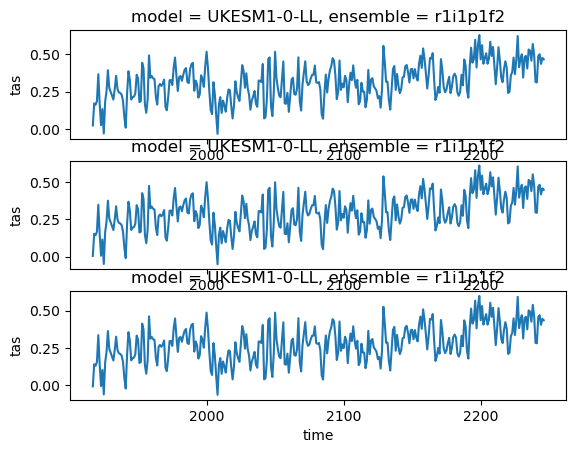

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
a1_smean_anom_data.sel(model=model).plot(ax=ax1)
a1_smean_anom_15_data.sel(model=model).plot(ax=ax2)
a1_smean_anom_20_data.sel(model=model).plot(ax=ax3)

In [174]:
branch_point_smean_anom_data = branch_point_smean_data - branch_point_mean_smean_data

In [175]:
branch_point_smean_anom_t0_da = branch_point_smean_anom_data.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')#.drop('ensemble', error='ignore')
a1_smean_anom_t0_da = a1_smean_anom_data.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')#.drop('ensemble', error='ignore')

model
model


In [176]:
branch_point_smean_anom_t0_da['time'] = branch_point_smean_anom_t0_da.time.dt.year.values -10
a1_smean_anom_t0_da['time'] = a1_smean_anom_t0_da.time.dt.year.values

In [177]:
a1_pct_data = pct_smean_data(zec_calculation_functions.base_a1_merge, a1_smean_data)

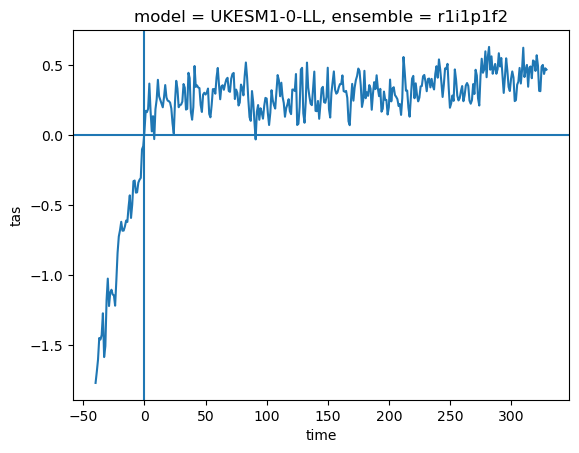

In [178]:
fig = plt.figure()
ax = fig.add_subplot(111)
(a1_pct_data[-1]-branch_point_mean_smean_data[-1].values.item()).plot()
ax.axvline(0)
ax.axhline(0)

# Calculating Forced Response

In [179]:
def calculate_slope(y):
    # Assuming the regression is along the time dimension
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [180]:
# def calculate_slope_and_intercept(y):
#     # Assuming the regression is along the time dimension
#     x = np.arange(len(y))
#     slope, intercept, _, _, _ = linregress(x, y)
#     return slope, intercept

In [181]:
def fit_line(y):
    # Assuming the regression is along the time dimension
    x = np.arange(len(y))
    slope, intercept, _, _, _ = linregress(x, y)
    
    # Calculate the fitted line
    fitted_line = slope * x + intercept
    
    return fitted_line

In [182]:
def calculate_slope_and_line(y):
    # Assuming the regression is along the time dimension
    x = np.arange(len(y))
    slope, intercept, _, _, _ = linregress(x, y)
    
    # Calculate the fitted line
    fitted_line = slope * x + intercept
    
    return slope, fitted_line

## Global Mean

In [183]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_smean_da = a1_smean_anom_data.isel(time=slice(15, 35)).mean(dim='time').concat('model')
zec50_smean_da = a1_smean_anom_data.isel(time=slice(40, 60)).mean(dim='time').concat('model')
zec90_smean_da = a1_smean_anom_data.isel(time=slice(80, 100)).mean(dim='time').concat('model')
zecfinal_smean_da = a1_smean_anom_data.isel(time=slice(-20, None)).mean(dim='time').concat('model')

In [184]:
linear_smean_50_fit_da = xr.apply_ufunc(
    fit_line,
    a1_smean_anom_t0_da.isel(time=slice(0, 50)).squeeze(),
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
    
)

# Smean Testing

In [185]:
calculate_slope(branch_point_smean_anom_t0_da.isel(model=-1).isel(time=slice(0, 10)).values)

0.03505240731542285

In [186]:
calculate_slope(branch_point_smean_anom_t0_da.isel(model=-1).isel(time=slice(10, None)).values)

0.039757856478218875

In [187]:
branch_point_smean_anom_t0_da.isel(model=-1).isel(time=slice(10, None)).mean().values.item()

0.3132678813965978

In [188]:
branch_point_smean_anom_t0_da.isel(model=-1).isel(time=slice(0, 10)).mean().values.item()

-0.31326788139659667

In [189]:
uk_slope = calculate_slope(a1_smean_anom_t0_da.isel(model=-1).isel(time=slice(0, 50)).values)
uk_slope

0.002919725533687381

In [190]:
uk_slope * 50

0.14598627668436906

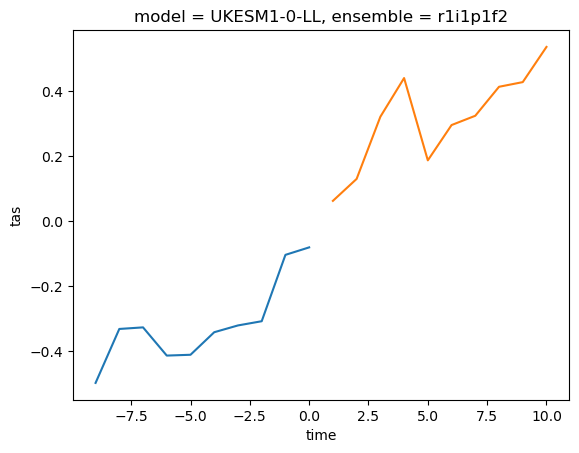

In [191]:
branch_point_smean_anom_t0_da.isel(model=-1).isel(time=slice(0, 10)).plot()
branch_point_smean_anom_t0_da.isel(model=-1).isel(time=slice(10, None)).plot()

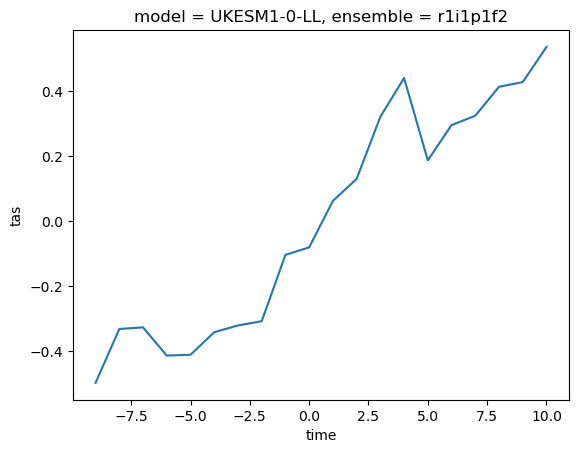

In [192]:
branch_point_smean_anom_t0_da.isel(model=-1).plot()

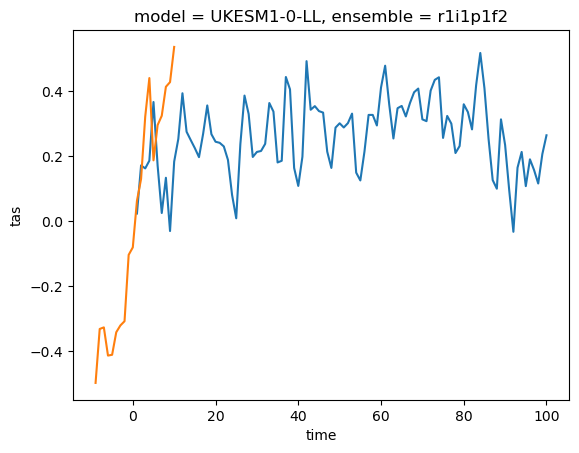

In [193]:
a1_smean_anom_t0_da.isel(model=-1).isel(time=slice(0, 100)).plot()
branch_point_smean_anom_t0_da.isel(model=-1).plot()

In [194]:
# # Example data (you can replace this with your actual data)
# x_values = zec50_smean_da.model.values  # Assuming x-values are based on the 'model' dimension
# y1 = zec50_smean_da.values  # Data from zec25_smean_da
# y2 = forced_smean_50_da.values  # Data from forced_slope_50_data

# # Create an array for the x-axis positions
# x = np.arange(len(x_values))

# # Set up the bar width
# bar_width = 0.35

# # Create the plot
# fig, ax = plt.subplots()

# # Plot the bars for each dataset
# bars1 = ax.bar(x - bar_width/2, y1, bar_width, label='ZEC50', color='green')
# bars2 = ax.bar(x + bar_width/2, y2, bar_width, label='Forced Response', color='magenta')

# # Add labels and title
# ax.set_xlabel('Model')
# ax.set_ylabel('Temperature Change After 50 years' + r'($^\circ$C)')
# # ax.set_title('Comparison of ZEC50 Smean and Forced Slope 50 Data')
# ax.set_xticks(x)
# ax.set_xticklabels(x_values, rotation=45, ha='right')
# ax.legend()

# ax.axhline(0, color='k', linewidth=0.6)

# # Add vertical lines between each bar set for better model division
# for pos in x:
#     ax.axvline(x=pos+bar_width*3/2, color='gray', linestyle='--', linewidth=0.5)



# ax.set_xlim(x[0]-bar_width*3/2, x[-1]+bar_width*3/2);
# # ax.grid()

In [195]:
models = pct_smean_data.model
models

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

In [196]:
 # a1_smean_data[model].squeeze(), pct_smean_data

In [197]:
def plot_raw_a1_vals(ax, model, t_length=60):
    time = np.arange(t_length)
    
    ax.plot(time, a1_smean_data.sel(model=model).isel(time=slice(0,t_length)).squeeze().values, linewidth=2)
    zec50_val = a1_smean_data.sel(model=model).isel(time=slice(40,60)).squeeze().mean().values
    ax.plot([40, 60], [zec50_val, zec50_val], color='orange', linewidth=2)
    ax.scatter([50], zec50_val, s=50, color='orange', linewidth=2)
    
    ax.axhline(branch_point_smean_data.sel(model=model).mean().values.item(),
               color='magenta', linestyle='--', alpha=0.5, zorder=-10, linewidth=2)
    
    ax.set_title(model, fontsize=16)

    ax.set_ylabel(r'GMST ($\circ$c)', fontsize=16)
    ax.set_xlabel('Time After EMission Cessation (Years)', fontsize=16)
    ax.tick_params(axis='both', size=6, labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.3, color='grey')
    ax.set_xlim(0, t_length)



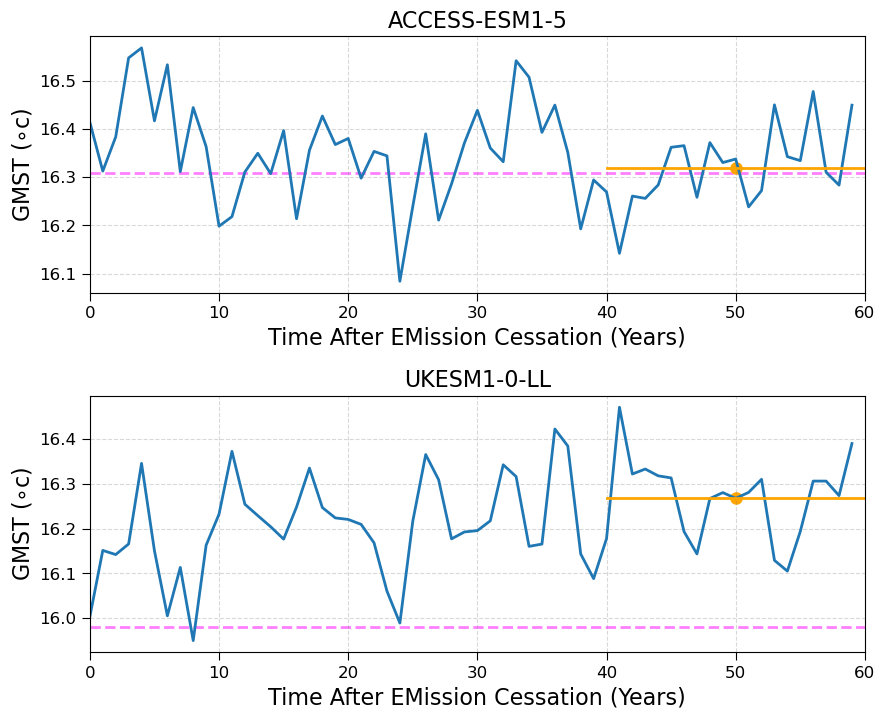

In [198]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, hspace=0.4)
axes = [fig.add_subplot(gs[i]) for i in range(2)]

plot_raw_a1_vals(axes[0], 'ACCESS-ESM1-5')
plot_raw_a1_vals(axes[1], 'UKESM1-0-LL')

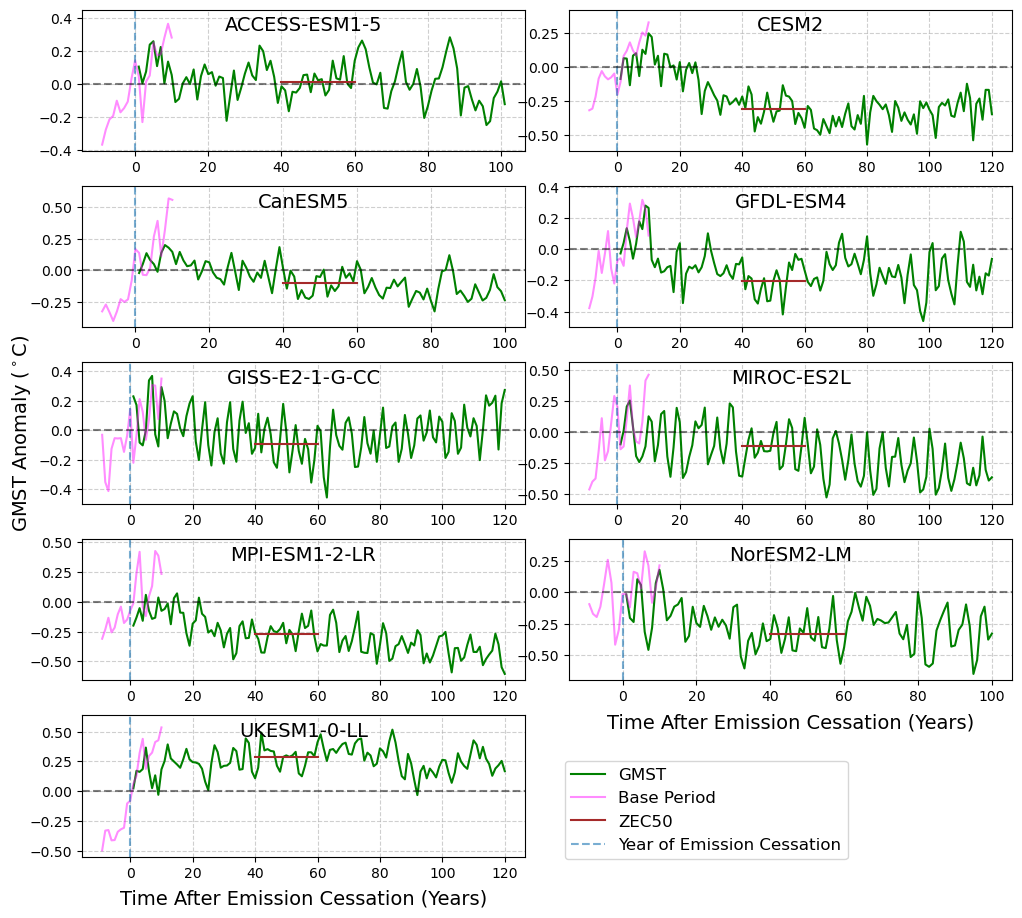

In [199]:

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2.2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(len(models))]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    a1_smean_anom_t0_da.sel(model=model).isel(time=slice(0, 120)).plot(ax=ax, color='green', label='GMST')

    branch_point_smean_anom_t0_da.sel(model=model).plot(ax=ax, color='magenta', label='Base Period', 
                                                       alpha=0.45)
    
    # zec50_model_val = zec25_smean_da.sel(model=model).squeeze().values.item()
    zec50_model_val = a1_smean_anom_t0_da.sel(model=model).isel(time=slice(40, 60)).mean().values.item()

    
    ax.plot([40, 60], np.tile(zec50_model_val,2),  color='brown', label='ZEC50')
    
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.set_title('')


    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    else:
         ax.set_ylabel('')

    # if num in [0, 1]:
    #     axes[num].xaxis.set_label_position('top')
    #     axes[num].xaxis.tick_top()

    ax.axvline(0, label='Year of Emission Cessation', linestyle='--', alpha=0.6)
    ax.axhline(0, linestyle='--', color='k', alpha=0.5)#, label='Base Period Averg')
    # plotting_functions.add_figure_label2(ax, f'{chr(97+num)})', y=.87)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1]+0.05)
    ax.set_xlabel('')
   

# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
# leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.77, 0.1), fontsize=12)

# Add x-axis label to the last subplot

for ax_num in [-1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=20 if ax_num<0 else 12)

# axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
# axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

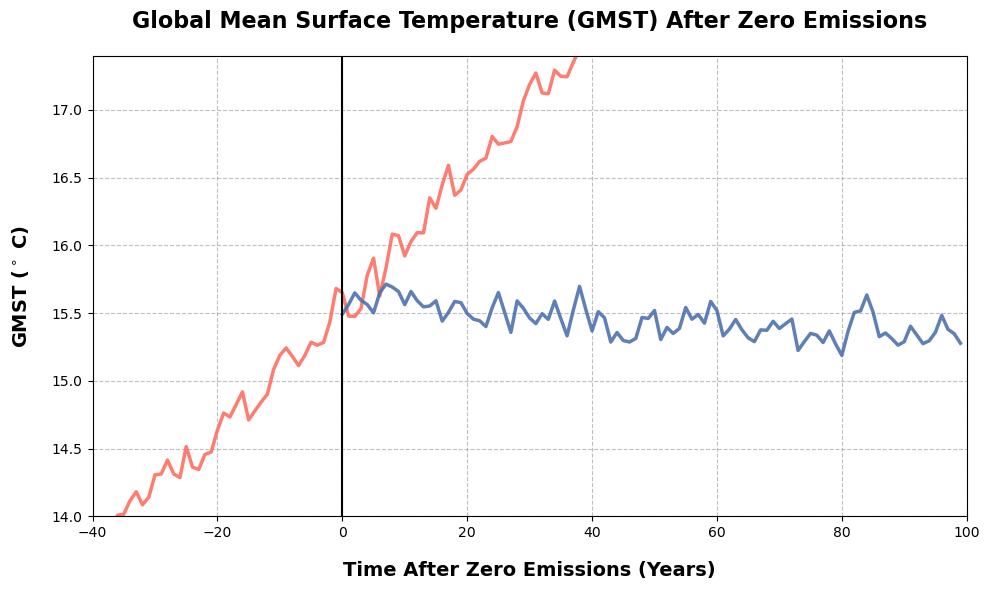

In [200]:
imodel = 2
model = pct_smean_data.model[imodel]
fig, ax = plt.subplots(figsize=(10, 6))  # Larger figure for better visibility

# Time axis adjustments
a1_time = a1_data[model].time.dt.year.values
a1_0 = a1_time[0]
a1_time = a1_time - a1_0
pct_time = pct_smean_data[model].time.dt.year.values - a1_0

# Plot data with improved color scheme and thicker lines
ax.plot(pct_time, pct_smean_data[model].squeeze().values, color='#FF6F61', label='PCT Mean', linewidth=2.5, alpha=0.9)
ax.plot(a1_time, a1_smean_data[model].squeeze().values, color='#4C72B0', label='A1 Mean', linewidth=2.5, alpha=0.9)

# Add grid with subtle appearance
ax.grid(True, linestyle='--', color='grey', alpha=0.5)

# Set limits for y and x axes
ax.set_ylim(14, 17.4)
ax.set_xlim(-40, 100)

# Add a vertical line to mark zero emissions
ax.axvline(0, color='black', linestyle='-', linewidth=1.5)

# Enhance labels with font size, weight, and add some padding
ax.set_ylabel('GMST (' + r'$^\circ$ C)', fontsize=14, fontweight='bold', labelpad=15)
ax.set_xlabel('Time After Zero Emissions (Years)', fontsize=14, fontweight='bold', labelpad=15)

# Improve the legend positioning and aesthetics
# ax.legend(loc='upper left', fontsize=12, frameon=False)

# Add a title to the plot
ax.set_title('Global Mean Surface Temperature (GMST) After Zero Emissions', fontsize=16, fontweight='bold', pad=20)

# Show the enhanced plot
plt.tight_layout()
plt.show()

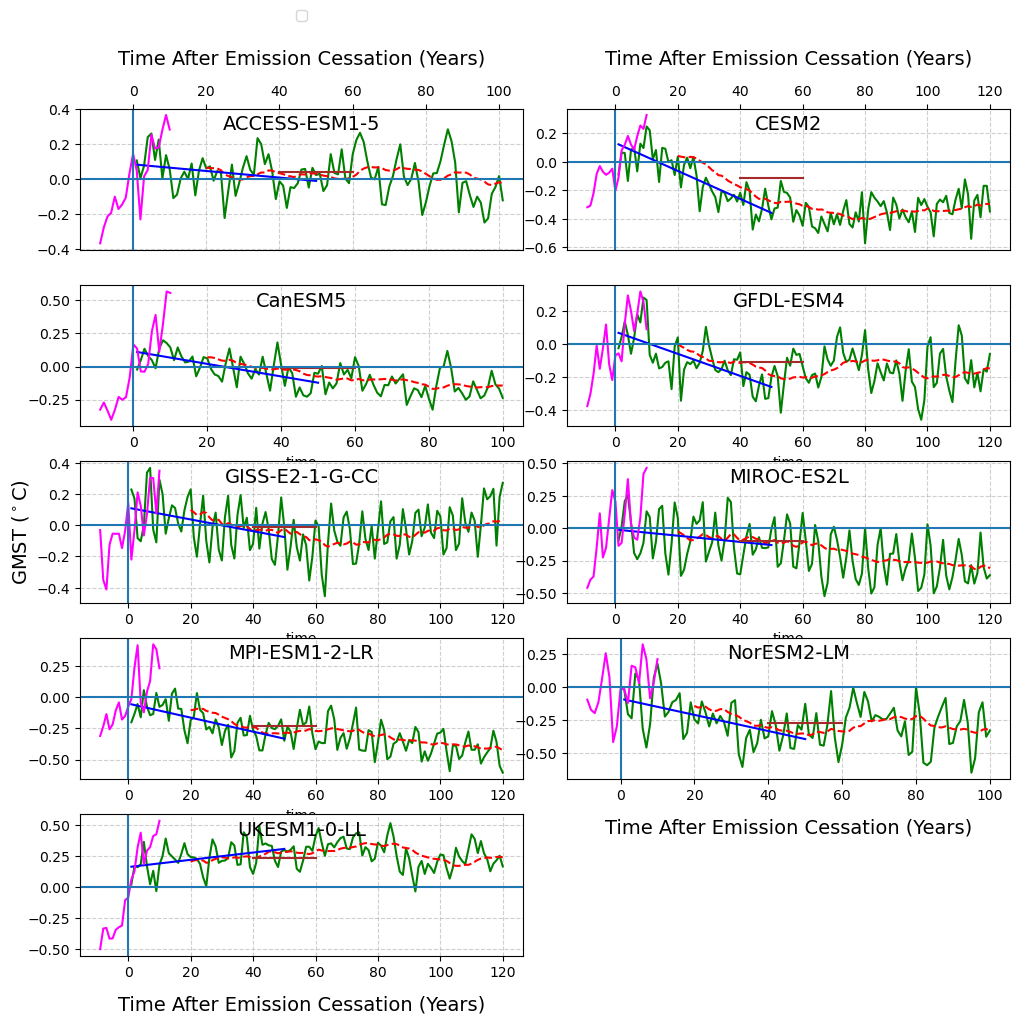

In [201]:
models = pct_smean_data.model

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2.2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(len(models))]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    a1_smean_anom_t0_da.sel(model=model).isel(time=slice(0, 120)).plot(ax=ax, color='green')
    a1_smean_anom_t0_da.sel(model=model).isel(time=slice(0, 120)).rolling(time=20).mean().plot(
        ax=ax, color='red', linestyle='--'
    )
    linear_smean_50_fit_da.sel(model=model).plot(ax=ax, color='blue')
    branch_point_smean_anom_t0_da.sel(model=model).plot(ax=ax, color='magenta')
    
    zec50_model_val = zec25_smean_da.sel(model=model).squeeze().values.item()
    # forced_slope_50_model = forced_smean_50_da.sel(model=model).squeeze().values.item()

    
    ax.plot([40, 60], np.tile(zec50_model_val,2),  color='brown')
    
    ax.grid(True, linestyle='--', alpha=0.6)

    ax.set_title('')


    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    # if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    else:
         ax.set_ylabel('')

    if num in [0, 1]:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()

    ax.axvline(0)
    ax.axhline(0)
   

# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot

for ax_num in [0, 1, -1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=25 if ax_num<0 else 12)

# axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
# axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

In [202]:

def plot_zecmip_data(ax, a1_model_subset, pct_model_subset, zec50_anom, zec25_anom):
    branch_year = a1_model_subset.time.values[0].year
    base_period_years =  np.arange(branch_year-10, branch_year+10)
    
    pct_brach_subset = pct_model_subset.sel(
        time=pct_model_subset.time.dt.year.isin(base_period_years))

    a1_time = np.arange(0, len(a1_model_subset.time.values))
    pct_time = np.arange(-10, 10)
    
    base_period_mean = pct_brach_subset.mean(dim='time').values
    
    
    ax.plot(
        a1_time,
        # a1_model_subset.time.values,
        np.tile(base_period_mean, len(a1_model_subset.time.values)),
        linestyle='--', color='k', label='Base Period Average')
    
    ax.plot(pct_time, pct_brach_subset.values, color='magenta', label='Base Period',
           # linestyle='--', marker='o'
           )
    
    ax.plot(a1_time, a1_model_subset.values, color='green', linewidth=2, label='A1')

    #### ZEC50
    zec50_loc = a1_model_subset.isel(time=slice(40, 60)).mean().values
    # zec50_val= zec50_loc
    ax.plot(np.arange(40, 60),
            np.tile(zec50_loc, 20),
            color='blue', linewidth=2)
    if zec50_loc < base_period_mean: ytrans = -0.2
    else: ytrans = 0.2
    ax.annotate(f'{zec50_anom:.2f}', xy=(50,zec50_loc+ytrans), ha='center', color='blue')

    ### ZEC25
    zec25_loc = a1_model_subset.isel(time=slice(15, 35)).mean().values
    # zec50_val= zec50_loc
    ax.plot(np.arange(15, 35),
            np.tile(zec25_loc, 20),
            color='brown', linewidth=2)
    if zec25_loc < base_period_mean: ytrans = -0.2
    else: ytrans = 0.2
    ax.annotate(f'{zec25_anom:.2f}', xy=(25,zec25_loc+ytrans), ha='center', color='brown')
    
    
    ax.axvline(0, label='Branch Point')
    
    ### Styling
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)

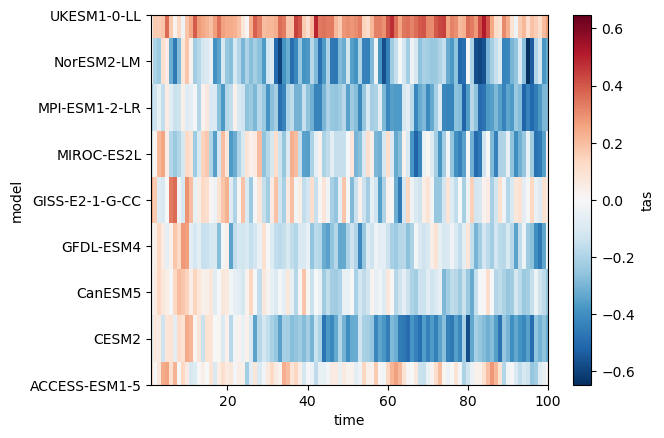

In [203]:
a1_smean_anom_t0_da.isel(time=slice(0, 100)).squeeze().plot()

In [204]:
models = pct_smean_data.model
models

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

Text(0.5, 0, 'Time After Emission Cessation (Years)')

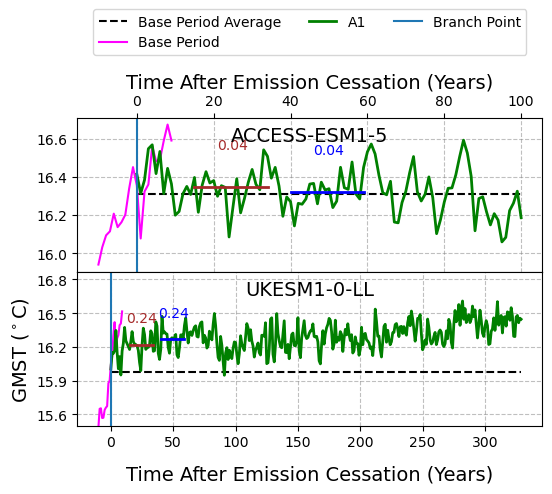

In [205]:
models = ['ACCESS-ESM1-5', 'UKESM1-0-LL']

ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(len(models))]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(models):
    plot_zecmip_data(axes[num], a1_smean_data[model].squeeze(), pct_smean_data[model].squeeze(),
                    zec25_smean_da.sel(model=model).values.item(), zec25_smean_da.sel(model=model).values.item())
    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)

    if num == 0:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()
    


# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

Text(0.5, 0, 'Time After Emission Cessation (Years)')

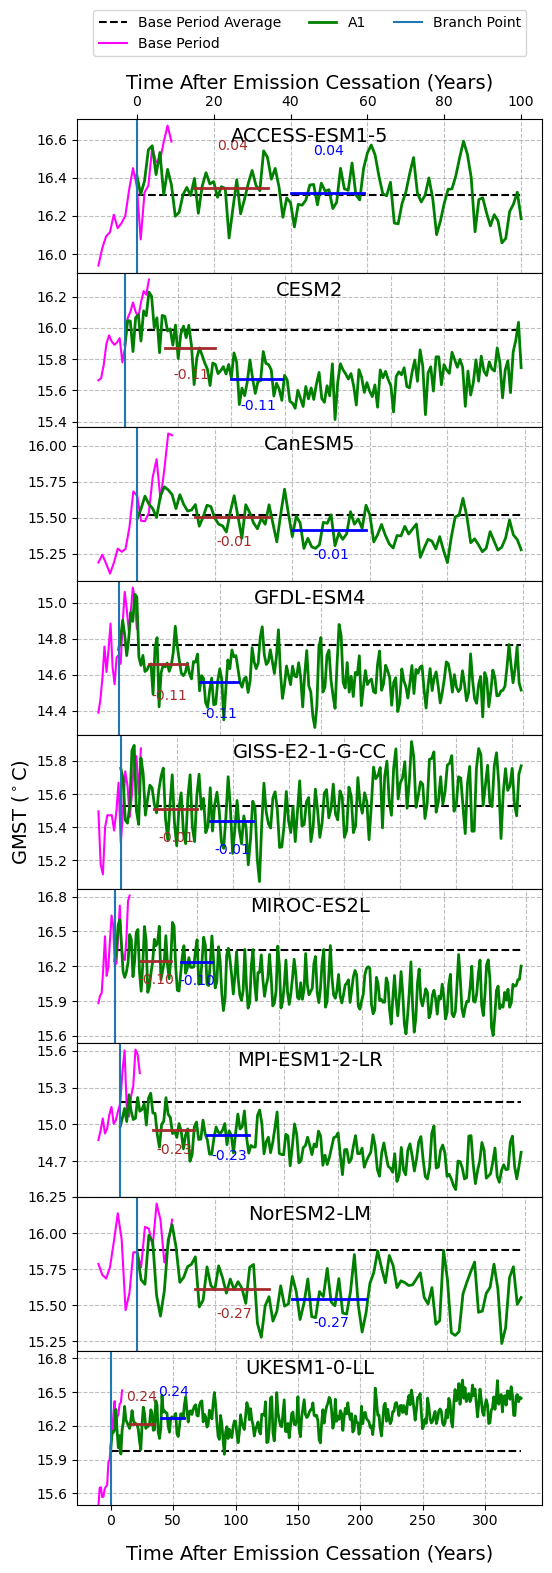

In [206]:
models = pct_smean_data.model

ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(len(models))]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    plot_zecmip_data(axes[num], a1_smean_data[model].squeeze(), pct_smean_data[model].squeeze(),
                    zec25_smean_da.sel(model=model).values.item(), zec25_smean_da.sel(model=model).values.item())
    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)

    if num == 0:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()
    


# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

Text(0.5, 0, 'Time After Emission Cessation (Years)')

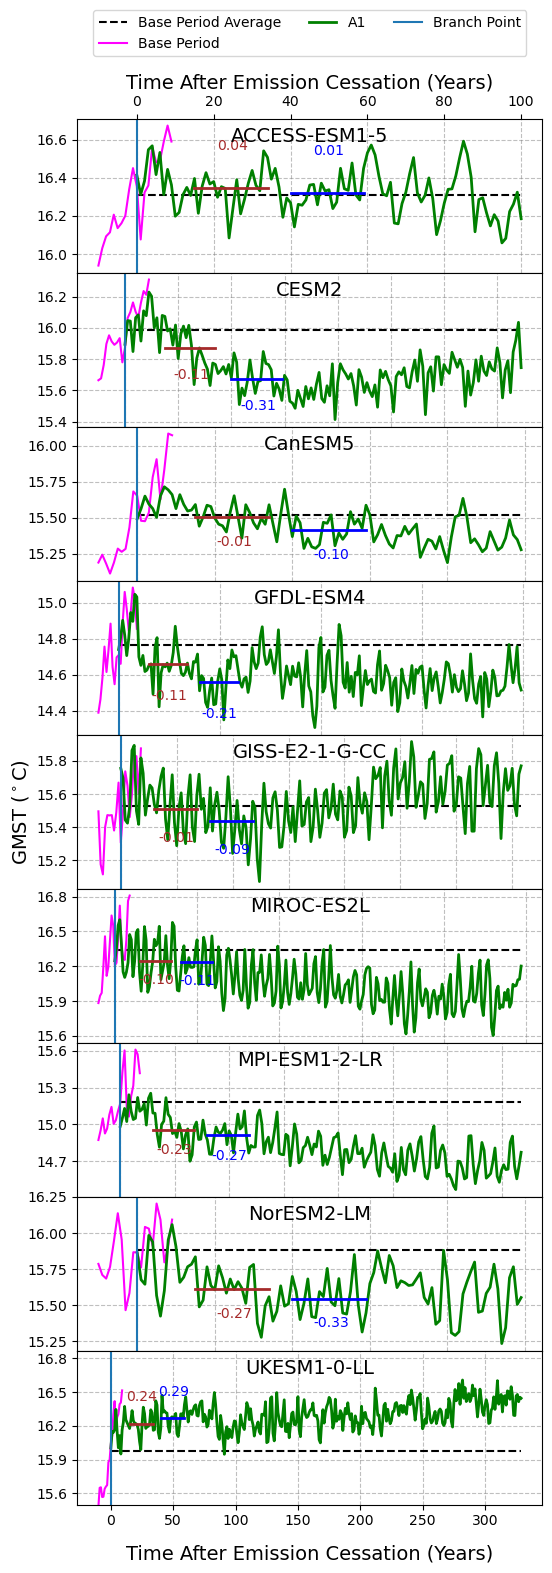

In [207]:
# ncols = 2
# nrows = int(np.ceil(len(models)/ncols))

# fig = plt.figure(figsize=(6*ncols, 2*nrows))
# gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
# axes = [fig.add_subplot(gs[i]) for i in range(9)]

ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.refkeys):
    plot_zecmip_data(axes[num], a1_smean_data[model].squeeze(), pct_smean_data[model].squeeze(),
                    zec50_smean_da.sel(model=model).values.item(), zec25_smean_da.sel(model=model).values.item())
    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)

    if num == 0:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()
    


# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

Text(0.5, 0, 'Time After Emission Cessation (Years)')

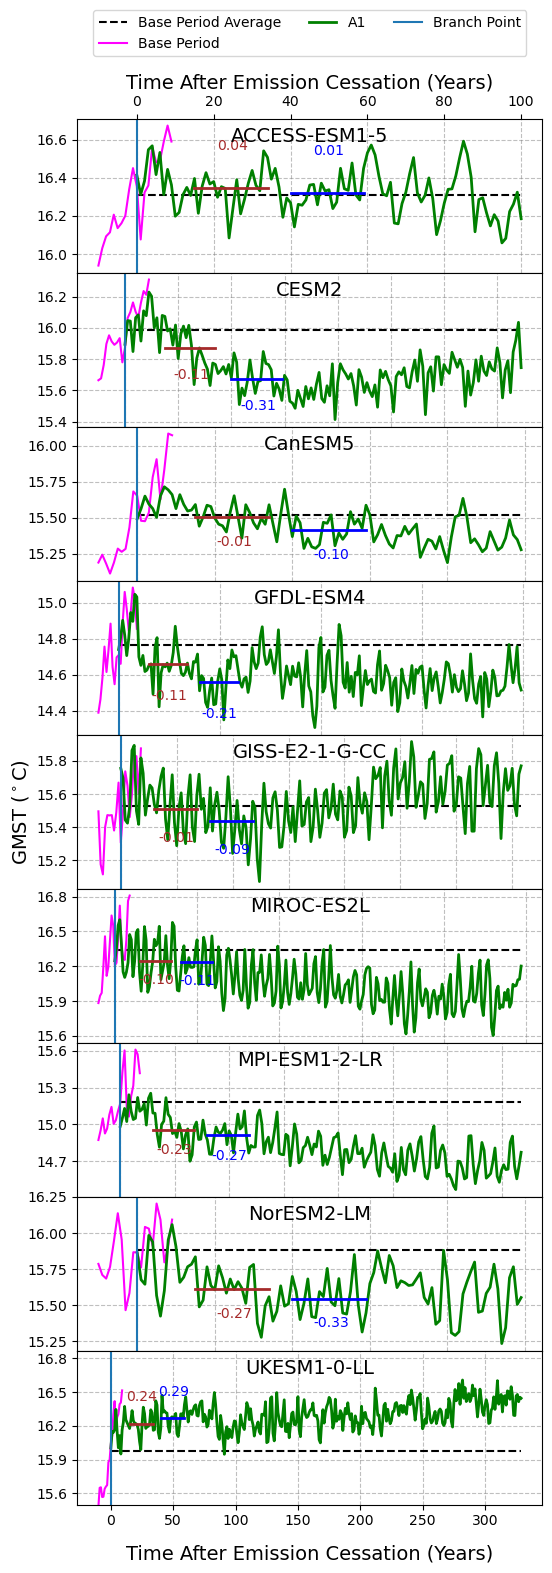

In [208]:
# ncols = 2
# nrows = int(np.ceil(len(models)/ncols))

# fig = plt.figure(figsize=(6*ncols, 2*nrows))
# gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
# axes = [fig.add_subplot(gs[i]) for i in range(9)]

ncols = 1
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.refkeys):
    plot_zecmip_data(axes[num], a1_smean_data[model].squeeze(), pct_smean_data[model].squeeze(),
                    zec50_smean_da.sel(model=model).values.item(), zec25_smean_da.sel(model=model).values.item())
    # plot_model_data(axes[num], model, ds_pct, a1_smean_xrlist[model])
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')

    if model == 'UKESM1-0-LL': axes[num].set_ylim(15.5, 16.87)
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))
    # Add y-axis label to the middle left subplot
    if num == int(len(models)/2):
        axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)

    if num == 0:
        axes[num].xaxis.set_label_position('top')
        axes[num].xaxis.tick_top()
    


# Place the legend above the first row of plots
# leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
leg = axes[0].legend(ncol=3, bbox_to_anchor=[0.5, 1.75], loc='upper center', fontsize=10)

# Add x-axis label to the last subplot
axes[-1].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25)
axes[0].set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=2)

# GMST Change

In [209]:
import statsmodels.api as sm
import patsy

In [210]:
model = 'UKESM1-0-LL'

In [211]:
a1_full_smean_data = a1_full_data.apply(my_stats.space_mean).compute()

model


## Hodrick-Prescot (HP filter) and LOWESS

In [212]:
imodel = -1#'UKESM1-0-LL'
model = a1_full_smean_data.model[imodel]
model

'UKESM1-0-LL'

In [213]:
lowess_1_gm_data = a1_full_smean_data(my_stats.trend_fit, method='lowess', lowess_window=21).compute()
lowess_2_gm_data = a1_full_smean_data(my_stats.trend_fit, method='lowess', lowess_window=41).compute()
lowess_3_gm_data = a1_full_smean_data(my_stats.trend_fit, method='lowess', lowess_window=61).compute()
lowess_4_gm_data = a1_full_smean_data(my_stats.trend_fit, method='lowess', lowess_window=81).compute()
lowess_5_gm_data = a1_full_smean_data(my_stats.trend_fit, method='lowess', lowess_window=99).compute()

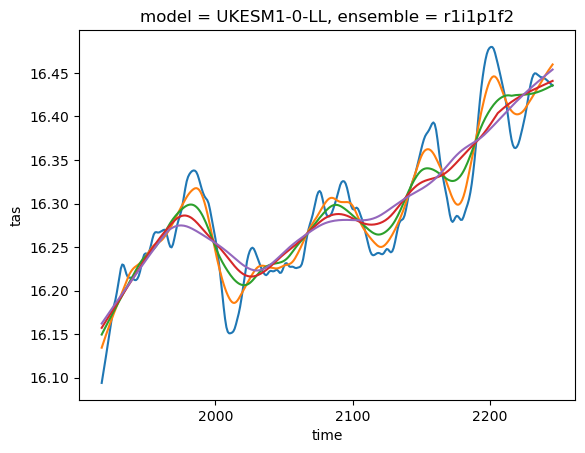

In [214]:
lowess_1_gm_data[model].plot()
lowess_2_gm_data[model].plot()
lowess_3_gm_data[model].plot()
lowess_4_gm_data[model].plot()
lowess_5_gm_data[model].plot()

In [215]:
temperatures = a1_full_smean_data[model].squeeze().dropna(dim='time').values
#a1_smean_anom_data[-1].squeeze().values
temperatures.shape

(330,)

In [216]:
cyclical, hp_trend = sm.tsa.filters.hpfilter(temperatures, lamb=1600) 

In [217]:
def calculate_hp_trend(da):
    
    da = da.dropna(dim='time')
    
    temperatures = da.squeeze().values

    # temperatures = temperatures[np.isfinite(temperatures)]
    cyclical, hp_trend = sm.tsa.filters.hpfilter(temperatures, lamb=1600) 

    da_trend = xr.zeros_like(da) + hp_trend
    return da_trend

In [218]:
hp_trend_data = a1_full_smean_data(calculate_hp_trend)

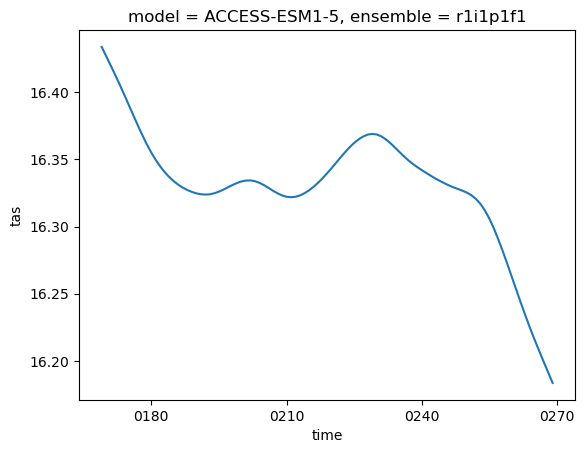

In [219]:
hp_trend_data[0].plot()

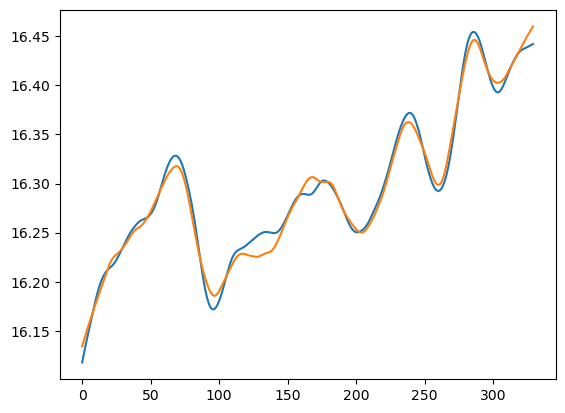

In [220]:
plt.plot(hp_trend)
plt.plot(lowess_2_gm_data[model].squeeze().values);

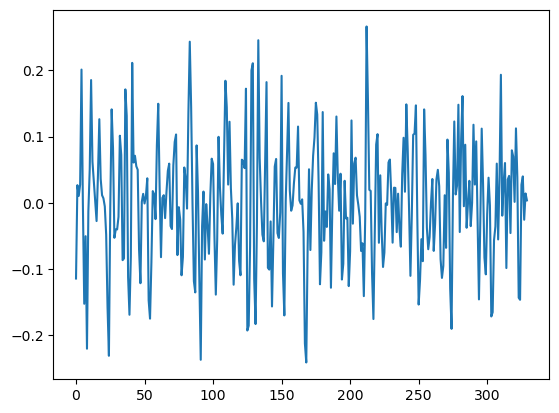

In [221]:
plt.plot(cyclical)

In [222]:
zec50_smean_da.sel(model=model).values.item()

0.2892118302627617

In [223]:
change_in_trend = hp_trend[50] - hp_trend[0]
change_in_trend

0.1510938314923962

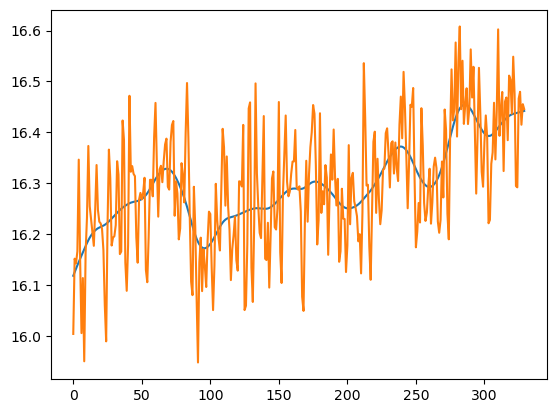

In [224]:
plt.plot(hp_trend)
plt.plot(temperatures)

## Linear Splines

In [225]:
# Example data
# years = np.array([1950, 1951, ..., 2020])  # Replace with actual years
years = np.arange(len(temperatures))
temperatures = temperatures#np.array([...])  # Replace with temperature data

# Define knot positions (e.g., every 20 years)
knots = years[::25]

# Create spline basis
spline_basis = patsy.dmatrix("bs(years, knots=knots, degree=1, include_intercept=True)", {"years": years})

# Fit the model
spline_model = sm.OLS(temperatures, spline_basis)
results = spline_model.fit()

# Get predicted values
predicted_temperatures = results.predict(spline_basis)

In [226]:
# Define knot positions (e.g., every 25 years)
knots = years[::25]

# Calculate midpoints
midpoints = (knots[:-1] + knots[1:]) / 2

# Initialize gradients array
gradients = np.zeros(len(midpoints))

# Calculate gradients at midpoints
for i, midpoint in enumerate(midpoints):
    idx = np.argmin(np.abs(years - midpoint))
    dy = years[1] - years[0]  # Assuming uniform spacing
    gradients[i] = (predicted_temperatures[idx + 1] - predicted_temperatures[idx - 1]) / (2 * dy)

In [227]:
tc1 = gradients[0]*25
tc2 = gradients[1]*25

In [228]:
tc1 + tc2

0.1370780569706298

In [229]:
zec50_smean_da.sel(model=model).values.item()

0.2892118302627617

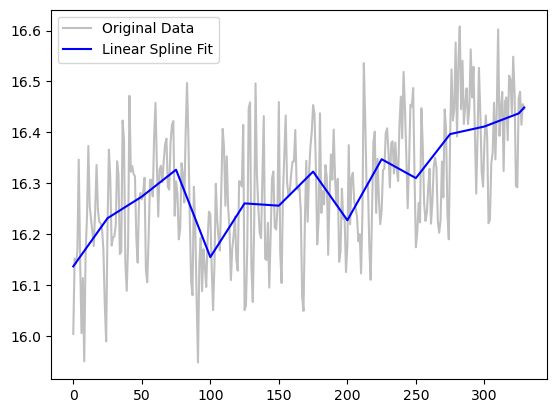

In [230]:
# Plot results
plt.plot(years, temperatures, label="Original Data", color='gray', alpha=0.5)
plt.plot(years, predicted_temperatures, label="Linear Spline Fit", color='blue')
plt.legend()

In [231]:
def calcuilate_splines(da):

    da = da.dropna(dim='time')
    
    temperatures = da.squeeze().values
    # Example data
    # years = np.array([1950, 1951, ..., 2020])  # Replace with actual years
    years = np.arange(len(temperatures))
    temperatures = temperatures#np.array([...])  # Replace with temperature data
    
    # Define knot positions (e.g., every 20 years)
    knots = years[::25]
    
    # Create spline basis
    spline_basis = patsy.dmatrix("bs(years, knots=knots, degree=1, include_intercept=True)", {"years": years})
    
    # Fit the model
    spline_model = sm.OLS(temperatures, spline_basis)
    results = spline_model.fit()
    
    # Get predicted values
    predicted_temperatures = results.predict(spline_basis)
    da_trend = xr.zeros_like(da) + predicted_temperatures

    return da_trend

In [232]:
linear_spline_data = a1_full_smean_data(calcuilate_splines)

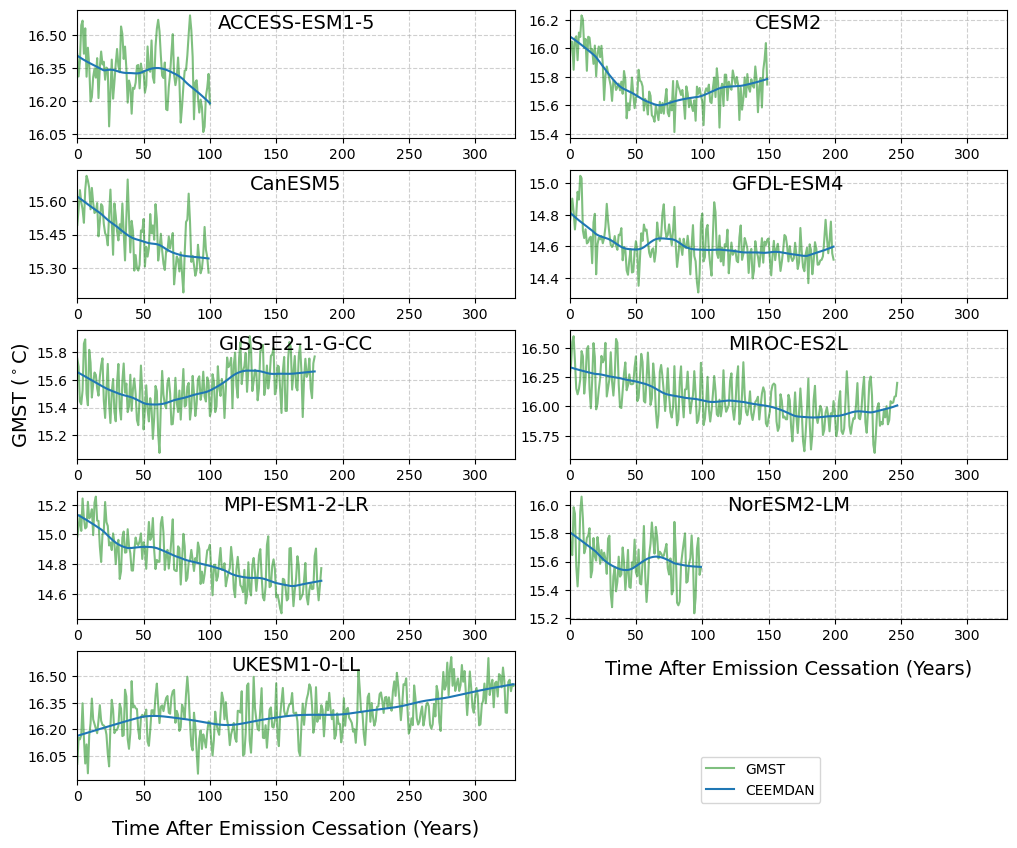

In [246]:
models = pct_smean_data.model

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.125)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    time = np.arange(a1_full_smean_data[model].time.shape[0])
    a1_raw_vals = a1_full_smean_data[model].squeeze().values
    
    # potential_series_vals = potential_series_data[model].squeeze().values
    
    # Plot the data for each model
    ax.plot(time, a1_raw_vals , color='green', label='GMST', alpha=0.5)
    # ax.plot(time, potential_series_vals, label='CEEMDAN')

    if 'UKESM' in model:
        vals = lowess_5_gm_data[model].squeeze().values
    else:
        vals = lowess_2_gm_data[model].squeeze().values
    ax.plot(time,vals , label='CEEMDAN');
    # ax.plot(time, hp_trend_data[model].squeeze().values, label='CEEMDAN', color='brown');
    
    # ax.plot(time, linear_spline_data[model].squeeze().values, label='Linear Splines', color='red');
    # ax.plot(time, hp_trend, label='Hodrick-Prescot');

    
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title('')
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))



    if num == int(len(models)/2):  axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    else:  ax.set_ylabel('')

    # ax.set_xlim(np.take(time, [0, -1]))
    # ax.set_xlim(np.take(time, [0, -1]))
    ax.set_xlim(0, 330)
    # plotting_functions.add_figure_label2(ax, f'{chr(97+num)})', y=.87)
    # ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1]+0.05)
    # ax.set_ylim(-0.7, 0.7)
    # ax.axhline(0, color='k', linewidth=.5)
    

    # if num in [0, 1]: 
    #     axes[num].xaxis.set_label_position('top')

# Add a legend in the lower left hand corner
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.75, 0.08))

# Labeling x-axis for specific subplots
for ax_num in [-1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=25 if ax_num < 0 else 12)


## Ensemble Empirical Mode Decomposition

In [234]:
from PyEMD import EEMD, EMD, CEEMDAN

ModuleNotFoundError: No module named 'PyEMD'

In [ ]:
def calculate_EMD(da):
    # Extract the signal and time from the input xarray.DataArray
    signal = da.values
    time = da.coords['time'].values  # Use the actual time values from the xarray
    
    # Initialize EMD
    emd = EMD()

    # Perform the decomposition
    IMFs = emd.emd(signal)

    # Create an xarray.DataArray directly from the IMFs
    IMF_da = xr.DataArray(IMFs, dims=["imf", "time"],
                          coords={"imf": np.arange(IMFs.shape[0]), "time": time})

    return IMF_da

In [ ]:
ceedman = CEEMDAN(trials=500)

In [ ]:
def calculate_CEEMDAN(da):
    # Extract the signal and time from the input xarray.DataArray
    signal = da.values
    time = da.coords['time'].values  # Use the actual time values from the xarray
    
    # Initialize EMD

    # Perform the decomposition
    IMFs = ceedman(signal)

    # Create an xarray.DataArray directly from the IMFs
    IMF_da = xr.DataArray(IMFs, dims=["imf", "time"],
                          coords={"imf": np.arange(IMFs.shape[0]), "time": time})

    return IMF_da

In [ ]:
ceedman_data = a1_full_smean_data.dropna(dim='time').squeeze()(calculate_CEEMDAN, logginglevel='INFO ')

In [ ]:
emd_data = a1_full_smean_data.dropna(dim='time').squeeze()(calculate_EMD)

In [ ]:
ceedman_data[-1].isel(imf=[-1, -2]).sum(dim='imf').plot()

a1_full_smean_data[-1].squeeze().plot()

In [ ]:
imf_data = ceedman_data

In [ ]:
ceedman_data

In [ ]:
imf_da = ceedman_data[-1]

# Plot the results
n_imfs = len(imf_da.imf)
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(n_imfs+1, 1, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(n_imfs+1)]

# Plot original signal
axes[0].plot(a1_full_smean_data[-1].squeeze().time.values, 
             a1_full_smean_data[-1].squeeze().values)
axes[0].set_ylabel("Original\nSignal", rotation=0, labelpad=25)

# Plot IMFs
for i in range(n_imfs):
    axes[i + 1].plot(imf_data[-1].time.values, imf_data[-1].squeeze().sel(imf=i), color='green')

    axes[i + 1].set_ylabel(f"IMF {i + 1}" if i < n_imfs-1 else 'Residual', rotation=0, labelpad=25)

## Filtering IMFs

In [ ]:
# Calculate dominant frequency for each IMF using FFT
def dominant_frequency(imf, time):
    # Compute FFT
    fft_vals = np.fft.fft(imf)
    freqs = np.fft.fftfreq(len(imf), d=(time[1] - time[0]))
    
    # Get positive frequencies and corresponding power
    positive_freqs = freqs[freqs > 0]
    power_spectrum = np.abs(fft_vals[freqs > 0])**2
    
    # Dominant frequency is the one with the highest power
    dominant_freq = positive_freqs[np.argmax(power_spectrum)]
    return dominant_freq

# Convert frequency to wavelength (years per cycle)
def frequency_to_wavelength(freq):
    return 1 / freq

In [ ]:
def filter_imf_arr(imfs, time, wavelength_threshold:int=50):
    # Filter IMFs based on their wavelength
    filtered_imfs = []
    for imf in imfs:
        freq = dominant_frequency(imf, time)
        wavelength = frequency_to_wavelength(freq)
        
        if wavelength >= wavelength_threshold:
            filtered_imfs.append(imf)
        # Convert the list of filtered IMFs back to an array
    filtered_imfs = np.array(filtered_imfs)
    return filtered_imfs

In [ ]:

def filter_imfs_by_wavelgnth(imf_da, wavelength_threshold:int=50):
    imfs = imf_da.squeeze().values
    time = np.arange(0, len(imf_da.time.values))
    filtered_imfs = filter_imf_arr(imfs, time, wavelength_threshold)

    n_filtered_imfs = filtered_imfs.shape[0]

    imf_filtered_da = xr.zeros_like(imf_da.isel(imf=slice(-n_filtered_imfs, None)))
    
    imf_filtered_da += filtered_imfs
    return imf_filtered_da

In [ ]:
imf_data

In [ ]:
imf_filtered_data = imf_data(filter_imfs_by_wavelgnth)
imf_filtered_data

In [ ]:
imf_data[model]

In [ ]:
# filtered_imfs.shape

In [ ]:
imodel = 7
imfs = imf_data[imodel].squeeze().values
time = np.arange(imf_data[imodel].squeeze().time.values.shape[0])

In [ ]:
imf_data.model[imodel]

In [ ]:
imfs.shape

In [ ]:
imf = imfs[3]

In [ ]:
fft_vals = np.fft.fft(imf)
fft_vals.shape

In [ ]:
freqs = np.fft.fftfreq(len(imf), d=(time[1] - time[0]))
freqs.shape

In [ ]:
# Get positive frequencies and corresponding power
positive_freqs = freqs[freqs > 0]
power_spectrum = np.abs(fft_vals[freqs > 0])**2

# Dominant frequency is the one with the highest power
dominant_freq = positive_freqs[np.argmax(power_spectrum)]

In [ ]:
dominant_freq

In [ ]:
power_spectrum.shape

In [ ]:
plt.plot(power_spectrum)

In [ ]:
plt.plot(positive_freqs)

In [ ]:
plt.plot(fft_vals)

In [ ]:
plt.plot(imf)

In [ ]:
imodel = -1
imfs = imf_data[imodel].squeeze().values
time = np.arange(imf_data[imodel].squeeze().time.values.shape[0])
imf_data.model[imodel]

In [ ]:
# Threshold for filtering (wavelengths less than 30 years)
threshold = 50

# Filter IMFs based on their wavelength
filtered_imfs = []
for num,imf in enumerate(imfs):
    freq = dominant_frequency(imf, time)
    wavelength = frequency_to_wavelength(freq)

    print(num, freq, wavelength)
    
    if wavelength >= threshold:
        filtered_imfs.append(imf)

# Convert the list of filtered IMFs back to an array
filtered_imfs = np.array(filtered_imfs)

print(f"Number of filtered IMFs: {filtered_imfs.shape[0]}")


In [ ]:
filtered_imfs.shape

In [ ]:
tps = np.sum(filtered_imfs, axis=0)

In [ ]:
plt.plot(a1_smean_data[imodel].squeeze().values)
plt.plot(tps)

In [ ]:
# Plotting the filtered IMFs
plt.figure(figsize=(10, len(filtered_imfs) * 2))

for i, imf in enumerate(filtered_imfs):
    plt.subplot(len(filtered_imfs), 1, i + 1)
    plt.plot(time, imf, label=f'IMF {i + 1}')
    plt.title(f'Filtered IMF {i + 1}')
    plt.xlabel('Time (years)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

In [ ]:
# Plotting the filtered IMFs
plt.figure(figsize=(10, len(imfs) * 2))

for i, imf in enumerate(imfs):
    plt.subplot(len(imfs), 1, i + 1)
    plt.plot(time, imf, label=f'IMF {i + 1}')
    plt.title(f'Filtered IMF {i + 1}')
    plt.xlabel('Time (years)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

## Constructing Potential Series

In [ ]:
imodel = -1#'UKESM1-0-LL'
model = a1_smean_data.model[imodel]
print(model)
plt.plot(a1_smean_data[model].squeeze().values, alpha=0.4)
plt.plot(imf_data[model].isel(imf=[-1, -2]).sum(dim='imf').squeeze().values, label='CEEMDAN')
plt.plot(lowess_5_gm_data[model].squeeze().values, label='LOWESS');
plt.legend()

In [ ]:
# model = 'UKESM1-0-LL'
plt.plot(a1_smean_data[model].squeeze().values, alpha=0.4)
plt.plot(imf_data[model].isel(imf=[-1, -2, -3]).sum(dim='imf').squeeze().values, label='CEEMDAN')
plt.plot(lowess_3_gm_data[model].squeeze().values, label='LOWESS');
plt.legend()

In [ ]:
# model = 'UKESM1-0-LL'
plt.plot(a1_smean_data[model].squeeze().values, alpha=0.4)
plt.plot(imf_data[model].isel(imf=[-1, -2, -3]).sum(dim='imf').squeeze().values, label='CEEMDAN')
plt.plot(lowess_2_gm_data[model].squeeze().values, label='LOWESS');
plt.plot(hp_trend, label='Hodrick-Prescot');
plt.legend()

In [ ]:
imf_filtered_data

In [ ]:
# The potential series is the sum of the residual (last imf) and second last imf
potential_series_data = imf_filtered_data.sum(dim='imf')
# potential_series_data = imf_data.isel(imf=[-1, -2]).sum(dim='imf')
potential_series_data

In [ ]:
potential_series_da = potential_series_data.copy()(utils.reset_time_to_0_start).concat('model')
potential_series_anom_da = potential_series_da - potential_series_da.isel(time=0)

In [ ]:
a1_smean_da  =a1_smean_data(utils.reset_time_to_0_start).concat('model')
a1_smean_anom_emd_da  = a1_smean_da - potential_series_da.isel(time=0)

In [ ]:
lowess_gm_da = lowess_3_gm_data.copy()(utils.reset_time_to_0_start).concat('model')
lowess_gm_anom_da = lowess_gm_da - lowess_gm_da.isel(time=0)

In [ ]:
potential_series_anom_da['time'] = np.arange(0, 330)
lowess_gm_anom_da['time'] = np.arange(0, 330)
a1_smean_anom_emd_da['time'] = np.arange(0, 330)


In [ ]:
models = potential_series_anom_da['model'].values  # Use values to get the model dimension


In [ ]:
models = pct_smean_data.model

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.125)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    time = np.arange(a1_full_smean_data[model].time.shape[0])
    a1_raw_vals = a1_full_smean_data[model].squeeze().values
    
    potential_series_vals = potential_series_data[model].squeeze().values
    
    # Plot the data for each model
    ax.plot(time, a1_raw_vals , color='green', label='GMST', alpha=0.5)
    ax.plot(time, potential_series_vals, label='CEEMDAN')

    ax.plot(time, lowess_2_gm_data[model].squeeze().values, label='LOWESS');
    ax.plot(time, hp_trend_data[model].squeeze().values, label='Hodrick-Prescott', color='brown');
    
    ax.plot(time, linear_spline_data[model].squeeze().values, label='Linear Splines', color='red');
    # ax.plot(time, hp_trend, label='Hodrick-Prescot');

    
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title('')
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))



    if num == int(len(models)/2):  axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    else:  ax.set_ylabel('')

    # ax.set_xlim(np.take(time, [0, -1]))
    # ax.set_xlim(np.take(time, [0, -1]))
    ax.set_xlim(0, 330)
    # plotting_functions.add_figure_label2(ax, f'{chr(97+num)})', y=.87)
    # ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1]+0.05)
    # ax.set_ylim(-0.7, 0.7)
    # ax.axhline(0, color='k', linewidth=.5)
    

    # if num in [0, 1]: 
    #     axes[num].xaxis.set_label_position('top')

# Add a legend in the lower left hand corner
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.75, 0.08))

# Labeling x-axis for specific subplots
for ax_num in [-1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=25 if ax_num < 0 else 12)


In [ ]:
# Create a color palette for the unique models
colors = sns.color_palette("husl", len(models))

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1,1) 

for num, model in enumerate(models):
 
    color = colors[num]
    potential_series_anom_da.sel(model=model).plot(ax=ax, color=color, label=model);

ax.axhline(0, color='k' )
ax.grid(True, linestyle='--', color='grey', alpha=0.5)
ax.set_xlim(0, 320)

ax.legend()

In [ ]:
models = ['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'][::-1]


# models = models[-3:][::-1]
# models = [models[-1]]
# models = np.take(models, [-1, -3, -5])


# Text scaling factor
scale = 2  # Change this to adjust all text sizes

# Set up Seaborn theme with a clean, high-contrast style for presentations
sns.set(style="whitegrid")

# Create figure and axis with a large size for presentation
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

# Loop through models and plot each with customized settings
for num, model in enumerate(models):
    color = sns.color_palette("muted", len(models))[num]  # Husl color palette for vivid colors
    potential_series_anom_da.sel(model=model).plot(ax=ax, color=color, label=model, 
                                                   linewidth=2.5, alpha=1)  # Thicker lines

# Add horizontal line at y=0 with a thicker line and darker color
ax.axhline(0, color='black', linestyle='-', linewidth=3)

# Set x and y axis limits if needed
ax.set_xlim(0, 320)

# Customize grid with subtle settings
ax.grid(True, linestyle='--', color='grey', alpha=0.65)

# Customize axis labels and title with scaling applied
ax.set_xlabel('Time After Emission Cessation (Years)', fontsize=14 * scale, 
              # fontweight='bold',
              labelpad=22 * scale)
ax.set_ylabel('GMST Anomaly (°C)', fontsize=14 * scale, 
              # fontweight='bold', 
              labelpad=22 * scale)
ax.set_title('')
# ax.set_title('Global Mean Surface Temperature Anomalies by Climate Model', 
#              fontsize=22 * scale, fontweight='bold', pad=20 * scale)

# Enhance tick parameters: bigger ticks with scaling
ax.tick_params(axis='both', which='major', labelsize=16 * scale, width=2 * scale)

# Adding a legend with scaling
ax.legend(title='ESM', title_fontsize=22, fontsize=18 , loc='lower right', 
          frameon=True, fancybox=True, shadow=True, borderpad=0.7 * scale)

# Add annotation to highlight key points, e.g., an important model trend
max_anom = potential_series_anom_da.max().values
max_time = potential_series_anom_da['time'].values[-1]  # Last time point
# ax.annotate('Max Anomaly', xy=(max_time, max_anom), xytext=(max_time-50, max_anom+0.2),
#             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10),
#             fontsize=12 * scale, fontweight='bold', color='red')

# Customize the background and border for extra flair
ax.set_facecolor('#f5f5f5')  # Light grey background
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5 * scale)

# Tight layout to improve spacing
plt.tight_layout()

# Show plot
ax.set_ylim(-0.6, 0.3)

In [ ]:
# Set up Seaborn theme with a clean white background
sns.set(style="whitegrid")

# Create figure and axis with a more subdued size
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)
color_palette = sns.color_palette("muted", len(models))  # Muted palette for subtle colors

# Loop through models and plot each with a muted color palette
for num, model in enumerate(models):
    color = color_palette[num]
    potential_series_anom_da.sel(model=model).plot(ax=ax, color=color, label=model, linewidth=2, alpha=0.85)

# Add horizontal line at y=0 with a subtle dark gray color
ax.axhline(0, color='darkgrey', linestyle='-', linewidth=1.5)

# Set a light gray grid with even subtler settings
ax.grid(True, linestyle='--', color='lightgrey', alpha=0.4)

# Set x and y axis limits if needed
ax.set_xlim(0, 320)

# Update axis labels and title with a clean, professional font style
ax.set_xlabel('Time After Emission Cessation (Years)', fontsize=14, labelpad=12)
ax.set_ylabel('GMST Anomaly (°C)', fontsize=14, labelpad=12)
ax.set_title('Global Mean Surface Temperature Anomalies by Climate Model', 
             fontsize=18, fontweight='bold', pad=15)

# Make ticks less prominent and more professional
ax.tick_params(axis='both', which='major', labelsize=11, width=1.5)

# Legend with a subtle, simple look
ax.legend(title='Climate Models', title_fontsize=13, fontsize=10, loc='upper right', 
          frameon=False, borderpad=0.8)

# Adjust annotation with a more professional color and less flair
max_anom = potential_series_anom_da.max().values
max_time = potential_series_anom_da['time'].values[-1]
ax.annotate('Max Anomaly', xy=(max_time, max_anom), xytext=(max_time-50, max_anom+0.1),
            arrowprops=dict(facecolor='grey', arrowstyle="->", linewidth=1),
            fontsize=12, color='darkgrey')

# Set a very light gray background for clarity
ax.set_facecolor('#fafafa')  # Nearly white background
for spine in ax.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(1)

# Tight layout to improve spacing
plt.tight_layout()


In [ ]:
models = ['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL']


# models = models[-1:][::-1]
# Set up Seaborn theme with a dark background for a more striking look
sns.set(style="whitegrid")

# Create figure and axis with a larger size
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1)

# Loop through models and plot each with customized settings
for num, model in enumerate(models):
    color = sns.color_palette("muted", len(models))[num]  # Husl color palette for unique, vivid colors
    potential_series_anom_da.sel(model=model).plot(ax=ax, color=color, label=model, linewidth=3, alpha=0.8)

# Add horizontal line at y=0 with a thicker line and darker color
ax.axhline(0, color='black', linestyle='-', linewidth=2)

# Customize grid with even subtler settings
ax.grid(True, linestyle='--', color='grey', alpha=0.25)

# Set x and y axis limits if needed
ax.set_xlim(0, 320)

# Customize axis labels and title with a modern, sans-serif font and larger size
ax.set_xlabel('Time After Emission Cessation (Years)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('GMST Anomaly (°C)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_title('Global Mean Surface Temperature Anomalies by Climate Model', 
             fontsize=20, fontweight='bold', pad=20)

# Enhance tick parameters: bolder and bigger
ax.tick_params(axis='both', which='major', labelsize=13, width=2)

# Adding a legend with a cleaner look and a more integrated feel
ax.legend(title='Climate Models', title_fontsize=15, fontsize=12, loc='upper right', 
          frameon=True, fancybox=True, shadow=True, borderpad=1)

# Add annotation to highlight key points, e.g., an important model trend
max_anom = potential_series_anom_da.max().values
max_time = potential_series_anom_da['time'].values[-1]  # Last time point
ax.annotate('Max Anomaly', xy=(max_time, max_anom), xytext=(max_time-50, max_anom+0.2),
            arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10),
            fontsize=13, fontweight='bold', color='red')

# Customize the background and border for extra flair
ax.set_facecolor('#f5f5f5')  # Light grey background
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Tight layout to improve spacing
plt.tight_layout()

# Show plot
ax.set_ylim(-0.6, 0.2)

In [ ]:
fig = plt.figure(figsize=(12, 12))
axes = [fig.add_subplot(2, 1, i+1) for i in range(2)]

for num, model in enumerate(models):
 
    color = colors[num]
    potential_series_anom_da.sel(model=model).plot(ax=axes[0], color=color, label=model);
    # a1_smean_anom_emd_da.sel(model=model).plot(ax=axes[0], color=color, label=model, alpha=0.25);
    lowess_gm_anom_da.sel(model=model).plot( ax=axes[0], linestyle='--', color=color);
    a1_smean_anom_t0_da.sel(model=model).rolling(time=20, min_periods=10).mean().plot(
        ax=axes[1], color=color);

for ax in axes:
    ax.axhline(0, color='k' )
    ax.grid(True, linestyle='--', color='grey', alpha=0.5)
    ax.set_xlim(0, 320)

axes[0].legend()

In [ ]:
# imodel = -1
# imf_data[imodelpotential_series_da].isel(imf=[-1, -2, -3]).sum(dim='imf').plot()
# potential_series_data[imodel].plot()
# a1_smean_data[imodel].plot()

In [ ]:
imf50_anom_da = (potential_series_data.isel(time=50).concat('model')-\
                   potential_series_data.isel(time=0).concat('model'))#.values

In [ ]:
imf90_anom_da = (potential_series_data.isel(time=90).concat('model')-\
                   potential_series_data.isel(time=0).concat('model'))

In [ ]:
imffinal_anom_da = (potential_series_data.isel(time=-1).concat('model')-\
                   potential_series_data.isel(time=0).concat('model'))

In [ ]:
plt.plot(imffinal_anom_da.values)#.plot()

In [ ]:
zec50_smean_da = zec50_smean_da.drop('ensemble', errors='ignore').sortby('model')
imf50_anom_da = imf50_anom_da.sortby('model')

In [ ]:
zec50_smean_da .min(), zec50_smean_da.max(),zec50_smean_da.median()

In [ ]:
np.min(imf50_anom_da.values),np.max(imf50_anom_da.values), np.median(imf50_anom_da.values)

In [ ]:
np.min(imf90_anom_da.values),np.max(imf90_anom_da.values), np.median(imf90_anom_da.values)

In [ ]:
zec50_smean_da.median(), zec50_smean_da.mean()

In [ ]:
imf50_anom_da.median(), imf50_anom_da.mean()

In [ ]:
def plot_temperature_change(x_values, y1, y2, c1='magenta', c2='green', year_num=50, ax=None,
                           fig=None):
    """
    Plots the temperature change after 50 years for two datasets.

    Parameters:
        x_values (np.ndarray): Array of model names or x-values.
        y1 (np.ndarray): Data array for the first dataset (ZEC50).
        y2 (np.ndarray): Data array for the second dataset (EEMD).
        c1 (str): Color for the first dataset bars (default is 'magenta').
        c2 (str): Color for the second dataset bars (default is 'green').
    """
    plt.style.use('default')
    # Create an array for the y-axis positions
    y = np.arange(len(x_values))

    # Set up the bar height and text offset
    bar_height = 0.35

    # Create the plot
    if ax is None:
        fig, ax = plt.subplots()

    # For y1 dataset
    ax.barh(9 - bar_height / 2, np.max(y1) - np.min(y1), 
            bar_height, left=np.min(y1), color=c1)
    
    # For y2 dataset (EEMD)
    ax.barh(9 + bar_height / 2, np.max(y2) - np.min(y2), 
            bar_height, left=np.min(y2), color=c2)
    
    # Adjust lines to still represent the original min and max if needed
    ax.plot([np.min(y1), np.max(y1)], [9 - bar_height / 2, 9 - bar_height / 2], color=c1)
    ax.plot([np.min(y2), np.max(y2)], [9 + bar_height / 2, 9 + bar_height / 2], color=c2)


    # ax.barh(9 - bar_height / 2, np.nanpercentile(y1, 75) - np.nanpercentile(y1, 25), 
    #         bar_height, left=np.nanpercentile(y1, 25), color=c1)
    
    # # For y2 dataset (EEMD)
    # ax.barh(9 + bar_height / 2, np.nanpercentile(y2, 75) - np.nanpercentile(y2, 25), 
    #         bar_height, left=np.nanpercentile(y2, 25), color=c2)

    
    # ax.plot([np.min(y2), np.max(y2)], [9 + bar_height / 2, 9 + bar_height / 2], color=c2)
    # ax.plot([np.min(y1), np.max(y1)], [9 - bar_height / 2, 9 - bar_height / 2], color=c1)



    # Plot the bars for each dataset
    bars1 = ax.barh(y - bar_height / 2, y1, bar_height, label='20-Year Average', color=c1)
    bars2 = ax.barh(y + bar_height / 2, y2, bar_height, label='CEEMDAN', color=c2)

    # Add labels and title
    ax.set_ylabel('Earth System Model')
    ax.set_xlabel(f'Temperature Change After {year_num} years ' + r'($^\circ$C)')
    y = np.append(y, 9)
    ax.set_yticks(y)
    x_values = np.append(x_values, 'Model Range')
    ax.set_yticklabels(x_values)
    ax.legend(loc='lower right')

    ax.axvline(0, color='k', linewidth=0.6)

    # Add vertical lines between each bar set for better model division
    for pos in y:
        ax.axhline(y=pos + 1.5 * bar_height, color='gray', linestyle='--', linewidth=0.5)

    text_offset_base = 0.07  # Variable for text offset

    for i in range(len(y1)):
        text_offset1 = 0 if y1[i] >= 0 else -text_offset_base
        ax.text(y1[i] + text_offset1, i - bar_height / 2, f"{y1[i]:.2f}", va='center', ha='left', color=c1)

        text_offset2 = 0 if y2[i] >= 0 else -text_offset_base
        ax.text(y2[i] + text_offset2, i + bar_height / 2, f"{y2[i]:.2f}", va='center', ha='left', color=c2)

    ax.set_xlim(-0.55, 0.4)

    ax.vlines(x=np.median(y1), ymin=9 - 0.9 * bar_height, ymax=9, color='k', linewidth=2)
    ax.vlines(x=np.median(y2), ymin=9, ymax=9 + bar_height, color='k', linewidth=2)
    ax.annotate(f'{np.median(y1):.2f}', xy=(np.median(y1), 9 - 3.2 * bar_height / 2), ha='center', va='center', 
                color=c1)

    ax.annotate(f'{np.median(y2):.2f}', xy=(np.median(y2), 9 + 3.2 * bar_height / 2), ha='center', va='center', 
                color=c2)

    ax.text(np.max(y1), y[-1] - bar_height / 2, f"{np.max(y1):.2f}", va='center', ha='left', color=c1)
    ax.text(np.min(y1) - text_offset_base, y[-1] - bar_height / 2, f"{np.min(y1):.2f}", va='center',
            ha='left', color=c1)

    ax.set_ylim(y[0] - bar_height * 3 / 2, None)
    ax.text(np.max(y2), y[-1] + bar_height / 2, f"{np.max(y2):.2f}", va='center', ha='left', color=c2)
    ax.text(np.min(y2) - text_offset_base, y[-1] + bar_height / 2, f"{np.min(y2):.2f}", va='center',
            ha='left', color=c2)

    fig.suptitle(f'GMST Changes {year_num} Years After Emission Cessation',
                fontsize=12, y=0.92)

In [ ]:
def plot_temperature_change_v2(x_values, y1, y2, c1='magenta', c2='green', year_num=50):
    """
    Plots the temperature change after 50 years for two datasets.

    Parameters:
        x_values (np.ndarray): Array of model names or x-values.
        y1 (np.ndarray): Data array for the first dataset (ZEC50).
        y2 (np.ndarray): Data array for the second dataset (EEMD).
        c1 (str): Color for the first dataset bars (default is 'magenta').
        c2 (str): Color for the second dataset bars (default is 'green').
    """
    plt.style.use('default')
    y = np.arange(len(x_values))

    bar_height = 0.35

    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[0.14, 0.9], hspace=0.05)
    ax0 = fig.add_subplot(gs[0])
    ax = fig.add_subplot(gs[1])
    
    # Plot dataset ranges in ax0
    ax0.barh(1 - bar_height / 2, np.max(y1) - np.min(y1), bar_height, left=np.min(y1), color=c1)
    ax0.barh(1 + bar_height / 2, np.max(y2) - np.min(y2), bar_height, left=np.min(y2), color=c2)
    ax0.plot([np.min(y1), np.max(y1)], [1 - bar_height / 2] * 2, color=c1)
    ax0.plot([np.min(y2), np.max(y2)], [1 + bar_height / 2] * 2, color=c2)
    
    # Main bars for each dataset in ax
    bars1 = ax.barh(y - bar_height / 2, y1, bar_height, label='20-Year Average', color=c1)
    bars2 = ax.barh(y + bar_height / 2, y2, bar_height, label='CEEMDAN', color=c2)

    ax.set_ylabel('Earth System Model', fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(x_values)
    ax.legend(loc='lower right')
    ax.axvline(0, color='k', linewidth=0.6)
    ax0.axvline(0, color='k', linewidth=0.6, zorder=-1000)

    for pos in y:
        ax.axhline(y=pos + 1.5 * bar_height, color='gray', linestyle='--', linewidth=0.5)

    text_offset_base = 0.07

    for i in range(len(y1)):
        text_offset1 = 0 if y1[i] >= 0 else -text_offset_base
        ax.text(y1[i] + text_offset1, i - bar_height / 2, f"{y1[i]:.2f}", va='center', ha='left', color=c1)

        text_offset2 = 0 if y2[i] >= 0 else -text_offset_base
        ax.text(y2[i] + text_offset2, i + bar_height / 2, f"{y2[i]:.2f}", va='center', ha='left', color=c2)

    ax.set_xlim(-0.55, 0.4)
    ax0.set_xlim(-0.55, 0.4)



    # ax0.vlines(x=np.median(y1), ymin=-1, ymax=-1, color=c1, linewidth=2)
    # ax0.vlines(x=np.median(y2), ymin=1, ymax=1, color=c2, linewidth=2)

    ax0.annotate(f'{np.median(y1):.2f}', xy=(np.median(y1), 1 - 1.5 * bar_height), ha='center', va='center', color=c1)
    ax0.annotate(f'{np.median(y2):.2f}', xy=(np.median(y2), 1 + 1.5 * bar_height), ha='center', va='center', color=c2)
    ax0.annotate(f'{np.min(y1):.2f}', xy=(np.min(y1)-0.06, 1-bar_height), color='magenta')
    ax0.annotate(f'{np.max(y1):.2f}', xy=(np.max(y1)+0.01, 1-bar_height), color='magenta')

    ax0.annotate(f'{np.min(y2):.2f}', xy=(np.min(y2)-0.06, 1+bar_height/10), color='green')
    ax0.annotate(f'{np.max(y2):.2f}', xy=(np.max(y2)+0.01, 1+bar_height/10), color='green')

    

    ax0.set_yticks([1])
    ax0.set_yticklabels(['Model Range'])
    ax0.set_ylim(1-2.2*bar_height, 1+2.2*bar_height)

    ax0.xaxis.set_label_position('top')
    ax0.xaxis.tick_top()

    ax0.vlines(x=np.median(y1), ymin=1 - 0.9 * bar_height, ymax=1, color='k', linewidth=2)
    ax0.vlines(x=np.median(y2), ymin=1, ymax=1 + bar_height, color='k', linewidth=2)
    
    fig.suptitle(f'GMST Changes {year_num} Years After Emission Cessation' + r'($^\circ$C)', 
                 fontsize=12, y=0.97)
    ax.set_xlabel(f'GMST Changes {year_num} Years After Emission Cessation' + r'($^\circ$C)',
                  fontsize=12)
    # ax.set_xlabel(f'Temperature Change After {year_num} years ' + r'($^\circ$C)')


In [ ]:
ceemdan_repeat_values = [0.03, -0.2, -0.18, -0.06, -0.18, -0.21, -0.13, -0.42, -0.08][::-1]
zec_50_repeat_values =  [0.29, -0.33, -0.27, -0.11, -0.09, -0.21, -0.10, -0.31, 0.01][::-1]
plot_temperature_change_v2(zec50_smean_da.model.values, zec_50_repeat_values, ceemdan_repeat_values, 
                        c1='magenta', c2='green')


In [ ]:
plot_temperature_change(zec50_smean_da.model.values, zec50_smean_da.values, imf50_anom_da.values, 
                        c1='magenta', c2='green')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_temperature_change(zec50_smean_da.model.values, zec50_smean_da.values, imf50_anom_da.values, 
                        c1='magenta', c2='green', ax=ax1, fig=fig)


plot_temperature_change(zec90_smean_da.model.values, zec90_smean_da.values, imf90_anom_da.values, 
                        c1='magenta', c2='green', year_num='90', ax=ax2, fig=fig)




In [ ]:
plot_temperature_change(zecfinal_smean_da.model.values, zecfinal_smean_da.values, imffinal_anom_da.values, 
                        c1='magenta', c2='green', year_num='final')


In [ ]:
plot_temperature_change_v2(zec90_smean_da.model.values, zec90_smean_da.values, imf90_anom_da.values, 
                        c1='magenta', c2='green', year_num='90')


In [ ]:
plot_temperature_change(zec90_smean_da.model.values, zec90_smean_da.values, imf90_anom_da.values, 
                        c1='magenta', c2='green', year_num='90')


In [ ]:
models = imf_data.model

ncols = 2
nrows = int(np.ceil(len(models) / ncols))

fig = plt.figure(figsize=(10 * ncols, 9 * nrows))
gs_outer = gridspec.GridSpec(nrows, ncols, hspace=.15, wspace=.025)

for num, model in enumerate(models):
    
    imf_model_da = imf_data[model]
    num_imfs = len(imf_model_da.imf)

    time_years = np.arange(a1_full_smean_data[model].time.shape[0])

    # Create GridSpec for inner plots (a1 plot + IMFs)
    gs_inner = gridspec.GridSpecFromSubplotSpec(
        num_imfs + 1, 1, subplot_spec=gs_outer[num],
        height_ratios=[1] + [.5] * num_imfs, hspace=0.35)

    # Create the a1 plot
    ax_a1 = fig.add_axes(gs_inner[0].get_position(fig))
    ax_a1.plot(time_years, a1_full_smean_data[model].squeeze().values,
               color='green')
    ax_a1.set_title(model, fontsize=14)
    ax_a1.set_xlim(np.take(time_years, [0, -1]))
    ax_a1.yaxis.set_major_locator(MaxNLocator(4))
    ax_a1.grid(True, linestyle='--', alpha=.6)

    # Create IMF plots
    for i, imf in enumerate(imf_model_da.imf.values):
        ax_imf = fig.add_axes(gs_inner[i + 1].get_position(fig))
        ax_imf.plot(time_years, imf_model_da.squeeze().sel(imf=imf).values)


        ax_imf.set_xlim(np.take(time_years, [0, -1]))
        ax_imf.set_ylabel(f'IMF-{imf + 1}' if imf < num_imfs-1 else 'Residual', fontsize=12)

        ax_imf.xaxis.set_major_locator(MaxNLocator(10))
        ax_imf.yaxis.set_major_locator(MaxNLocator(4))
        
        ax_imf.grid(True, linestyle='--', alpha=.6)
        if num%2:
            ax_imf.yaxis.tick_right()
            ax_imf.spines['right'].set_position(('outward', 0))  # Move it outward by 0 points
            ax_imf.yaxis.set_ticks_position('both')  # Ticks on both left and right sides
            ax_imf.yaxis.set_tick_params(which='both', labelright=True)
            ax_imf.yaxis.set_label_position("right")
            # ax_imf.spines['left'].set_visible(False)


    if num%2:
        ax_a1.yaxis.tick_right()
        ax_a1.spines['right'].set_position(('outward', 0))  # Move it outward by 0 points
        ax_a1.yaxis.set_ticks_position('both')  # Ticks on both left and right sides
        ax_a1.yaxis.set_tick_params(which='both', labelright=True)
        ax_a1.yaxis.set_label_position("right")
        # ax_imf.spines['left'].set_visible(False)

        
    ax_imf.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)

In [ ]:
branch_point_mean_smean_data

In [ ]:
# Select the model you want to visualize
model = pct_smean_data.model[-1]  # You can change this index to select different models

# Create a single figure and axis for one model
fig, ax = plt.subplots(figsize=(6, 4))
time_lim = 100

# Time data for the selected model
time = np.arange(a1_full_smean_data[model].time.shape[0])[:time_lim]

branch_time = np.arange(-10, 10)
a1_raw_vals = a1_full_smean_data[model].squeeze().values[:time_lim]
potential_series_vals = potential_series_data[model].squeeze().values[:time_lim]

# Plot the data for the selected model
ax.plot(time, a1_raw_vals, color='green', label='GMST')
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_title(model, fontsize=14)

# Annotate specific points and add reference lines
base_period_mean = np.mean(branch_point_mean_smean_data[model].squeeze().values)
ax.plot(branch_time, branch_point_smean_data[model].squeeze().values, label='1%CO2 Base Period', 
       color='magenta', alpha=0.6)

ax.axhline(base_period_mean, linestyle='--', color='magenta', alpha=0.55, label='1%CO2 Base Period\nAverage')
ax.plot([40, 60], np.tile(np.mean(a1_raw_vals[40:60]), 2), color='red', label='ZEC50', linewidth=2)




# ax.plot(time, potential_series_vals, label='CEEMDAN Residual\n+ Last IMF', color='brown', linewidth=2)
# ax.axhline(potential_series_vals[0], linestyle='--', color='brown', alpha=0.55, label='CEEMDAN Initial Value')
# ax.scatter(50, potential_series_vals[50], label='Year 50', color='brown', zorder=1000)



# Set labels
ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
ax.set_xlabel('Time After Emission Cessation (Years)', fontsize=14)

# Set the x-axis limits
ax.set_xlim(-10, time_lim)

# Add a legend in the lower right-hand corner
ax.legend(loc='best')
# ax.legend(loc='center right', bbox_to_anchor=[1.5, 0.5])

In [ ]:
models = pct_smean_data.model

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.125)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    time = np.arange(a1_full_smean_data[model].time.shape[0])
    a1_raw_vals = a1_full_smean_data[model].squeeze().values
    potential_series_vals = potential_series_data[model].squeeze().values
    
    # Plot the data for each model
    ax.plot(time, a1_raw_vals , color='green', label='GMST')
    ax.plot(time, potential_series_vals, label='CEEMDAN Residual + Last IMF')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title('')
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.scatter(50, potential_series_vals[50], label='Year 50')

    base_period_mean = np.mean(branch_point_mean_smean_data[model].squeeze().values)
    ax.axhline(base_period_mean, linestyle='--', color='grey', alpha=0.9, label='1%CO2 Base Period')
    ax.axhline(potential_series_vals[0], linestyle='--', color='black', alpha=0.9, label='CEEMDAN inital value')

    ax.plot([40, 60], np.tile(np.mean(a1_raw_vals[40:60]), 2), color='magenta', label='ZEC50')

    if num == int(len(models)/2):  axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    else:  ax.set_ylabel('')

    ax.set_xlim(np.take(time, [0, -1]))

    if num in [0, 1]: 
        axes[num].xaxis.set_label_position('top')

# Add a legend in the lower left hand corner
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.75, 0.05))

# Labeling x-axis for specific subplots
for ax_num in [0, 1, -1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=25 if ax_num < 0 else 12)


In [ ]:
models = pct_smean_data.model

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.125)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    time = np.arange(a1_full_smean_data[model].time.shape[0])
    a1_raw_vals = a1_full_smean_data[model].squeeze().values
    potential_series_vals = potential_series_data[model].squeeze().values
    a1_raw_vals = a1_raw_vals - potential_series_vals[0]
    potential_series_vals = potential_series_vals - potential_series_vals[0]
    
    # Plot the data for each model
    ax.plot(time, a1_raw_vals , color='green', label='GMST', alpha=0.5)
    ax.plot(time, potential_series_vals, label='CEEMDAN')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title('')
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.scatter(25, potential_series_vals[25], label='Year 25', s=50, marker='x', color='magenta')
    ax.scatter(50, potential_series_vals[50], label='Year 50', s=50, color='magenta')
    ax.scatter(90, potential_series_vals[90], label='Year 90', s=50, marker='v', color='magenta')

    # ax.scatter(0, potential_series_vals[0], label='Year 0', color='magenta', s=50)


    if num == int(len(models)/2):  axes[num].set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    else:  ax.set_ylabel('')

    # ax.set_xlim(np.take(time, [0, -1]))
    ax.set_xlim(0, 330)
    # plotting_functions.add_figure_label2(ax, f'{chr(97+num)})', y=.87)
    # ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[-1]+0.05)
    ax.set_ylim(-0.7, 0.7)
    ax.axhline(0, color='k', linewidth=.5)


    # if num in [0, 1]:  axes[num].xaxis.set_label_position('top')


# Get legend handles and labels
handles, labels = axes[-1].get_legend_handles_labels()

# Split handles and labels: first two are lines, last three are markers
line_handles = handles[:2]
line_labels = labels[:2]
marker_handles = handles[2:]
marker_labels = labels[2:]

# Add the first legend for lines with a title
legend1 = fig.legend(line_handles, line_labels, loc='lower left', bbox_to_anchor=(0.55, 0.09), 
                     fontsize=12, title="Lines", title_fontsize='13')

# Add the second legend for markers with a title, positioned next to the first one
legend2 = fig.legend(marker_handles, marker_labels, loc='lower left', bbox_to_anchor=(0.7, 0.075), 
                     fontsize=12, title="Markers", title_fontsize='13')

# # Ensure that the legends don't overlap with each other or the plot
# fig.tight_layout()


# # Add a legend in the lower left hand corner
# handles, labels = axes[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.8, 0.075), fontsize=12,
#           ncol=2)

# Labeling x-axis for specific subplots
for ax_num in [-1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=20 if ax_num < 0 else 12)


In [ ]:
models = pct_smean_data.model

ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.25, wspace=0.125)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

# Iterate over the models and plot each one using plot_model_data
for num, model in enumerate(pct_smean_data.model):
    ax = axes[num]
    time = np.arange(a1_full_smean_data[model].time.shape[0])
    
    ax.plot(time, a1_full_smean_data[model].squeeze().values, color='green')
    # imf_data[model].isel(imf=[-1, -2]).sum(dim='imf').plot(ax=ax)
    ax.plot(time, potential_series_data[model].squeeze().values)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title('')
    axes[num].annotate(model, xy=(0.5, 0.85), ha='center', fontsize=14, xycoords='axes fraction')
    axes[num].yaxis.set_major_locator(MaxNLocator(nbins=5))

    
    if num == int(len(models)/2): axes[num].set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    else: ax.set_ylabel('')

    if num in [0, 1]: axes[num].xaxis.set_label_position('top')

    ax.set_xlim(np.take(time, [0, -1]))

for ax_num in [0, 1, -1, -2]:
    ax = axes[ax_num]
    ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', 
                  fontsize=14, labelpad=25 if ax_num<0 else 12)


# Pi-Control

In [ ]:
# pi-Control (not ESM)
esmpi_raw_data = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

In [ ]:
esmpi_raw_data = esmpi_raw_data.isel(ensemble=0)
esmpi_raw_data = esmpi_raw_data - 273.15
esmpi_data = esmpi_raw_data.chunk({'time':-1}).resample(time='Y').mean(dim='time').set_refkeys('model')
# Can see this in the global mean time series. But this has errors after 1000
esmpi_data['CanESM5'] = esmpi_data['CanESM5'].isel(time=slice(None, 1000))

In [ ]:
esmpi_smean_data = esmpi_data(my_stats.space_mean).compute()

In [ ]:
esmpi_smean_data[-1].plot()

In [ ]:
esmpi_smean_data[-1].squeeze()

In [ ]:
ceedman_esmpi_da = calculate_CEEMDAN(esmpi_smean_data.squeeze()[-1])

In [ ]:

n_imfs = len(ceedman_esmpi_da.imf)
n_imfs2 = len(ceedman_data[-1].imf.values)

# Create a figure with GridSpec
fig = plt.figure(figsize=(16, 15))
gs = gridspec.GridSpec(n_imfs + 1, 2, figure=fig)

# Plot original signal (left column)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(esmpi_smean_data[-1].squeeze().time.values, 
         esmpi_smean_data[-1].squeeze().values)
ax1.set_title("Original Signal")

# Plot IMFs (left column)
for i in range(n_imfs):
    ax = fig.add_subplot(gs[i + 1, 0])
    ax.plot(ceedman_esmpi_da.time.values, ceedman_esmpi_da.squeeze().sel(imf=i), color='green')
    ax.set_title(f"IMF {i + 1}")

# Plot original signal (right column)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(a1_full_smean_data[-1].squeeze().time.values, 
         a1_full_smean_data[-1].squeeze().values)
ax2.set_title("Original Signal")

# Plot IMFs (right column)
for i in range(n_imfs2):
    ax = fig.add_subplot(gs[i + 1, 1])
    ax.plot(ceedman_data[-1].time.values, ceedman_data[-1].squeeze().sel(imf=i), color='green')
    ax.set_title(f"IMF {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ceedman_data[-1].isel(imf=-2).plot(ax=ax1)
ceedman_esmpi_da.isel(imf=-5).plot(ax=ax1)


ceedman_data[-1].isel(imf=-3).plot(ax=ax2)
ceedman_esmpi_da.isel(imf=-6).plot(ax=ax2)

ax2.grid(True)

In [ ]:

n_imfs = len(ceedman_esmpi_da.imf)
n_imfs2 = len(ceedman_data[-1].imf.values)

esmpi_time = np.arange(len(esmpi_smean_data[-1].squeeze().time.values))
a1_time = np.arange(len(ceedman_data[-1].time.values))

# Create a figure with GridSpec
fig = plt.figure(figsize=(16, 15))
gs = gridspec.GridSpec(n_imfs + 1, 2, figure=fig)

# Plot original signal (left column)
ax1 = fig.add_subplot(gs[0, 0])


ax1.plot(esmpi_time[:320], 
         esmpi_smean_data[-1].squeeze().values[:320])
ax1.set_title("Original Signal")

# Plot IMFs (left column)
for i in range(n_imfs):
    ax = fig.add_subplot(gs[i + 1, 0])
    ax.plot(esmpi_time[:320], ceedman_esmpi_da.squeeze().sel(imf=i).values[:320], color='green')
    ax.set_title(f"IMF {i + 1}")

# Plot original signal (right column)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(a1_time, 
         a1_full_smean_data[-1].squeeze().values)
ax2.set_title("Original Signal")

# Plot IMFs (right column)
for i in range(n_imfs2):
    ax = fig.add_subplot(gs[i + 1, 1])
    ax.plot(a1_time, ceedman_data[-1].squeeze().sel(imf=i), color='green')
    ax.set_title(f"IMF {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:

n_imfs = len(ceedman_esmpi_da.imf)
n_imfs2 = len(ceedman_data[-1].imf.values)

esmpi_time = np.arange(len(esmpi_smean_data[-1].squeeze().time.values))
a1_time = np.arange(len(ceedman_data[-1].time.values))

# Create a figure with GridSpec
fig = plt.figure(figsize=(16, 15))
gs = gridspec.GridSpec(n_imfs + 1, 2, figure=fig)

# Plot original signal (left column)
ax1 = fig.add_subplot(gs[0, 0])


ax1.plot(esmpi_time, 
         esmpi_smean_data[-1].squeeze().values)
ax1.set_title("Original Signal")

# Plot IMFs (left column)
for i in range(n_imfs):
    ax = fig.add_subplot(gs[i + 1, 0])
    ax.plot(esmpi_time, ceedman_esmpi_da.squeeze().sel(imf=i), color='green')
    ax.set_title(f"IMF {i + 1}")

# Plot original signal (right column)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(a1_full_smean_data[-1].squeeze().time.values, 
         a1_full_smean_data[-1].squeeze().values)
ax2.set_title("Original Signal")

# Plot IMFs (right column)
for i in range(n_imfs2):
    ax = fig.add_subplot(gs[i + 1, 1])
    ax.plot(a1_time, ceedman_data[-1].squeeze().sel(imf=i), color='green')
    ax.set_title(f"IMF {i + 1}")

plt.tight_layout()
plt.show()


# Local EMD

## Anomaly Calculations

In [247]:
branch_point_data = pct_data(
    zec_calculation_functions.isolate_base_period,
    a1_data, logginglevel='INFO')

- <function isolate_base_period at 0x145b2b048820> has been called
- ACCESS-ESM1-5


In [248]:
branch_point_mean_data = pct_data(
    zec_calculation_functions.calculate_branch_average,
    a1_data, logginglevel='INFO')

- <function calculate_branch_average at 0x145b2b0488b0> has been called
- ACCESS-ESM1-5


In [249]:
branch_point_anom_data = branch_point_data - branch_point_mean_data

In [250]:
# Amomaly time series from the branch point (previosuly called 'experiment_zec_da_anom')
a1_anom_data = (a1_data - branch_point_mean_data)#.compute()

In [251]:
# These two can be computed as they are small (combined is around  100mb with each 
# model being around 7mb
a1_anom_data = a1_anom_data.compute()
pct_data = pct_data.compute()

In [252]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_data = a1_anom_data.isel(time=slice(15, 35)).mean(dim='time').compute()
zec50_data = a1_anom_data.isel(time=slice(40, 60)).mean(dim='time').compute()
zec90_data = a1_anom_data.isel(time=slice(80, 100)).mean(dim='time').compute()
zec50_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192})

In [253]:
a1_anom_data = a1_anom_data.chunk(chunks_model_based)

In [254]:
a1_anom_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192, 'time': 101})
              (Array: 10.73, Chunk: 1.33Mib) ({'model': (1,), 'lat': (36, 36, 36, 36, 1), 'lon': (96, 96), 'time': (101,)})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288, 'time': 150})
              (Array: 31.64, Chunk: 0.99Mib) ({'model': (1,), 'lat': (36, 36, 36, 36, 36, 12), 'lon': (48, 48, 48, 48, 48, 48), 'time': (150,)})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 100})
              (Array: 3.12, Chunk: 0.2Mib) ({'model': (1,), 'lat': (16, 16, 16, 16), 'lon': (32, 32, 32, 32), 'time': (100,)})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288, 'time': 200})
              (Array: 39.55, Chunk: 1.65Mib) ({'model': (1,), 'lat': (60, 60, 60), 'lon': (36, 36, 36, 36, 36, 36, 36, 36), 'time': (200,)})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144, 'time': 180})
              (Array: 8.90, Ch

In [255]:
start_grad_data = apply_ufunc(
    calculate_slope,
    branch_point_data.isel(time=slice(0, 10)),  # your xarray.Dataset or DataArray
    input_core_dims=[['time']],  # specify the dimension to apply the function along
    vectorize=True,
    dask='parallelized',
)

In [256]:
end_grad_data = apply_ufunc(
    calculate_slope,
    branch_point_data.isel(time=slice(10, None)),  # your xarray.Dataset or DataArray
    input_core_dims=[['time']],  # specify the dimension to apply the function along
    vectorize=True,
    dask='parallelized',
)

In [257]:
start_end_grad_diff = start_grad_data - end_grad_data

## Local Broken Locations

In [ ]:
# This location is found to have a really large shock
# THis is for 
model = 'UKESM1-0-LL'
jump_loc = dict(lat=85.5,lon=80, method='nearest')

# model = 'MPI-ESM1-2-LR'
# jump_loc = dict(lat=85.5,lon=80, method='nearest')


# model = 'GISS-E2-1-G-CC'
# jump_loc = dict(lat=-1,lon=301.2, method='nearest')

# model = 'MIROC-ES2L'
# jump_loc = dict(lat=54, lon =45, method='nearest')

In [ ]:
a1_model_subset = a1_anom_data[model].isel(time=slice(0,100)).sel(**jump_loc).squeeze().compute()#.plot()
pct_brach_subset =  branch_point_anom_data[model].sel(**jump_loc).squeeze().compute()

In [ ]:
a1_subset_50_slope, a1_subset_50_fitted= calculate_slope_and_line(a1_model_subset.isel(time=slice(0,50)))
a1_subset_50_total_fit_slope = 50 * a1_subset_50_slope

In [ ]:
a1_subset_50_total_fit_slope

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

a1_time = np.arange(0, len(a1_model_subset.time.values))
pct_time = np.arange(-10, 10)

base_period_mean = pct_brach_subset.mean(dim='time').values


ax.plot(
    a1_time,
    np.tile(base_period_mean, len(a1_model_subset.time.values)),
    linestyle='--', color='k', label='Base Period Average')

ax.plot(pct_time, pct_brach_subset.values-base_period_mean, color='magenta', label='Base Period',
       linestyle='--', marker='o')

# ax.plot(a1_time, a1_subset_fitted, color='green', linewidth=2, linestyle='--',
#         label=f'A1 Linear Trend\n({a1_subset_50_total_fit_slope:.2f}' + r'$^\circ$C/50 years}')

ax.plot(a1_time[:len(a1_subset_50_fitted)], a1_subset_50_fitted, color='green', linewidth=2, linestyle='--',
        label=f'A1 Linear Trend\n({a1_subset_50_total_fit_slope:.2f}' + r'$^\circ$C/50 years}')

ax.plot(a1_time, a1_model_subset.values, color='green', linewidth=2, label='A1')

zec50_val = zec50_data[model].sel(**jump_loc).values.item() #a1_anom_data[model].sel(**jump_loc).isel(time=slice(40, 60)).mean().values
ax.plot(np.arange(40, 60),
        np.tile(zec50_val, 20),
        color='blue', linewidth=2, label=f'ZEC50 ({zec50_val:.2f}' + r'$^\circ$C)')


ax.axvline(0, label='Branch Point')

ax.legend(ncol=1, bbox_to_anchor=[1, 1])
ax.grid(True, linestyle='--', color='grey', alpha=0.5)
ax.set_xlabel('Time After Emission Cessation (Years)', va='bottom', fontsize=14, labelpad=25);
ax.set_ylabel('Temperature ' + r'($^\circ C$)' , fontsize=14);

ax.set_title(str(jump_loc['lat']) + r'$^\circ$N' + ', ' + str(jump_loc['lon']) + r'$^\circ$E')

In [ ]:
pct_brach_subset_vals = pct_brach_subset.values
pct_time = np.arange(-10, 10, 1)

In [ ]:
s1, l1 = calculate_slope_and_line(pct_brach_subset.isel(time=slice(0,10)).values)
s2, l2 = calculate_slope_and_line(pct_brach_subset.isel(time=slice(10, None)).values)


s1, s2

In [ ]:
l1

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.plot(pct_time[:10], pct_brach_subset_vals[:10], marker='o', color='blue')
ax.plot(pct_time[:10], l1, linestyle='--', color='blue')

ax.annotate(f'grad = {s1*10:.2f} K/decade', xy=(-6, pct_time[6]+2.5), ha='center', va='center', color='blue',
           size=10)

ax.plot(pct_time[-10:], pct_brach_subset_vals[-10:], marker='o', color='red')
ax.plot(pct_time[-10:], l2, linestyle='--', color='red')


ax.annotate(f'grad = {s2*10:.2f} K/decade', xy=(1.5, pct_time[-9]+3.5), ha='center', va='center', color='red',
           size=10)

ax.grid(True, linestyle='--', alpha=0.6)

ax.set_xticks(np.arange(-10, 12, 2));

ax.set_xlabel('Time After Emission Cessation (Years)')
ax.set_ylabel('Temperature Anomaly (K)')

ax.set_title(str(jump_loc['lat']) + r'$^\circ$N' + ', ' + str(jump_loc['lon']) + r'$^\circ$E')

## Sample Proto-type

In [ ]:
grad_50_data = apply_ufunc(
    calculate_slope,
    a1_anom_data.isel(time=slice(0, 50)).chunk({'time':-1, 'lat':200/4}),  # your xarray.Dataset or DataArray
    input_core_dims=[['time']],  # specify the dimension to apply the function along
    vectorize=True,
    dask='parallelized',
).compute()

forced_50_data  = grad_50_data * 50

In [ ]:
zec50_data[-1].plot(robust=True)

In [ ]:
diff_trend_loc = dict(lat=50, lon=15, method='nearest')

In [ ]:
zec50_data[-1].sel(**diff_trend_loc).values.item()

In [ ]:
sub_data = a1_data[-1].sel(**diff_trend_loc).squeeze().isel(time=slice(0, 60))
pct_sub_data = branch_point_data[-1].sel(**diff_trend_loc).squeeze()

sub_data

In [ ]:
subdata_abs_zec = np.mean(sub_data.values[40:60])
subdata_zec = subdata_abs_zec - pct_sub_data.mean().values.item()
subdata_abs_zec, subdata_zec

In [ ]:
zec50_data[-1].sel(**diff_trend_loc).values.item()

In [ ]:
sub_data_ceemdan = calculate_CEEMDAN(sub_data)
sub_data_ceemdan

In [ ]:
sub_data_ceemdan_potential_fit = sub_data_ceemdan.isel(imf=[-1, -2]).sum(dim='imf')
sub_data_ceemdan_potential_fit

In [ ]:
np.mean(sub_data[40:60])

In [ ]:
sub_data_emd_est = sub_data_ceemdan_potential_fit[50].values.item() - sub_data_ceemdan_potential_fit[0].values.item()
sub_data_emd_est

In [ ]:
fig, ax = plt.subplots(1, 1)

time = np.arange(sub_data.time.shape[0])

ax.plot(time[:60], sub_data.squeeze().values[:60], color='green', linewidth=2)
# ax.plot(time[:60], sub_data_ceemdan_potential_fit.values[:60], color='blue',
#         label=f'EEMD ({sub_data_emd_est:.2f}K)')


pct_time = np.arange(-10, 10, 1)

ax.plot(pct_time, pct_sub_data.values, color='magenta', linestyle='--')

ax.axhline(np.mean(pct_sub_data.values), color='grey', linestyle='--')

ax.axvline(0, color='grey', linestyle='--')

ax.set_xlim(-10, 60)

ax.plot([40, 60], np.tile(subdata_abs_zec, 2), color='orange', label=f'ZEC50 (+{subdata_zec:.2f}K)')

ax.set_title('Surface Temperature')
ax.set_xlabel('Time After Emission Cessation (Years)')

ax.legend()

ax.set_title('UKESM1-0-LL: ' + str(diff_trend_loc['lat']) + r'$^\circ$N' + ', ' + str(diff_trend_loc['lon']) + r'$^\circ$E')

In [ ]:
fig, ax = plt.subplots(1, 1)


time = np.arange(sub_data.time.shape[0])

ax.plot(time[:60], sub_data.squeeze().values[:60], color='green', linewidth=2)
ax.plot(time[:60], sub_data_ceemdan_potential_fit.values[:60], color='blue',
        label=f'EEMD ({sub_data_emd_est:.2f}K)')


pct_time = np.arange(-10, 10, 1)

ax.plot(pct_time, pct_sub_data.values, color='magenta', linestyle='--')

ax.axhline(np.mean(pct_sub_data.values), color='grey', linestyle='--')

ax.axvline(0, color='grey', linestyle='--')

ax.set_xlim(-10, 60)

ax.plot([40, 60], np.tile(subdata_abs_zec, 2), color='orange', label=f'ZEC50 (+{subdata_zec:.2f}K)')

ax.set_title('Surface Temperature')
ax.set_xlabel('Time After Emission Cessation (Years)')

ax.legend()

ax.set_title('UKESM1-0-LL: ' + str(diff_trend_loc['lat']) + r'$^\circ$N' + ', ' + str(diff_trend_loc['lon']) + r'$^\circ$E')

In [ ]:
forced_50_data[-1].plot(robust=True)

## All Grid Cells

In [ ]:
client.close()
client = Client(memory_limit=None, threads_per_worker=1, n_workers=80)
client

In [ ]:
ceedman = CEEMDAN()

In [266]:
def calculate_CEEMDAN_local(signal):

    # Perform the decomposition
    IMFs = ceedman(signal)

    # Get the last two IMFs
    res = IMFs[-1]
    last_imf = IMFs[-2]

    # Stack them along a new axis (0) to create an array of shape (2, time)
    return last_imf + res

In [267]:
def calculate_CEEMDAN_local_with_FFT_filter(signal):
    print(signal.shape)
    # Perform the decomposition
    IMFs = ceedman(signal)

    # Get the last two IMFs
    res = IMFs[-1]
    imfs = IMFs[:-1]
    time = np.arange(len(res))
    filtered_imfs = filter_imf_arr(imfs, time)

    series = res + np.sum(filtered_imfs, axis=0)

    return series

In [268]:
chunks_model_based_tiny = {
    'ACCESS-ESM1-5': {'time': -1, 'lat': 145//5, 'lon': 192//16},   # 5 * 16 = 80
    'CESM2': {'time': -1, 'lat': 144//6, 'lon': 192//14},           # 6 * 14 = 84
    'CanESM5': {'time': -1, 'lat': 60//2, 'lon': 128//8},           # 2 * 8 = 64
    'GFDL-ESM4': {'time': -1, 'lat': 180//6, 'lon': 144//9},        # 6 * 9 = 54
    'GISS-E2-1-G-CC': {'time': -1, 'lat': 90//3, 'lon': 192//8},    # 3 * 8 = 72
    'MIROC-ES2L': {'time': -1, 'lat': 64//4, 'lon': 128//8},        # 4 * 8 = 32
    'MPI-ESM1-2-LR': {'time': -1, 'lat': 96//4, 'lon': 192//16},    # 4 * 16 = 64
    'NorESM2-LM': {'time': -1, 'lat': 96//4, 'lon': 144//9},        # 4 * 9 = 36
    'UKESM1-0-LL': {'time': -1, 'lat': 144//6, 'lon': 192//14},     # 6 * 14 = 84
}
chunks_model_based_tiny


{'ACCESS-ESM1-5': {'time': -1, 'lat': 29, 'lon': 12},
 'CESM2': {'time': -1, 'lat': 24, 'lon': 13},
 'CanESM5': {'time': -1, 'lat': 30, 'lon': 16},
 'GFDL-ESM4': {'time': -1, 'lat': 30, 'lon': 16},
 'GISS-E2-1-G-CC': {'time': -1, 'lat': 30, 'lon': 24},
 'MIROC-ES2L': {'time': -1, 'lat': 16, 'lon': 16},
 'MPI-ESM1-2-LR': {'time': -1, 'lat': 24, 'lon': 12},
 'NorESM2-LM': {'time': -1, 'lat': 24, 'lon': 16},
 'UKESM1-0-LL': {'time': -1, 'lat': 24, 'lon': 13}}

### Local Lowess

In [269]:
import statsmodels.api as sm 
lowess = sm.nonparametric.lowess

In [270]:
a1_full_data = a1_full_data.astype(np.float16).compute().chunk(chunks_model_based_tiny)

In [271]:
def calculate_lowess(arr, window:int=41):
    time = np.arange(len(arr))
    frac =  window/len(arr)
    lowess_fitted = lowess(arr, time, frac=frac, return_sorted=False)
    return lowess_fitted

In [272]:
print( a1_full_data[0])

<xarray.DataArray 'tas' (model: 1, lat: 145, lon: 192, time: 101)> Size: 6MB
dask.array<chunksize=(1, 29, 12, 101), meta=np.ndarray>
Coordinates:
  * lat       (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon       (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * model     (model) <U13 52B 'ACCESS-ESM1-5'
    ensemble  <U8 32B 'r1i1p1f1'
  * time      (time) object 808B 0168-12-31 00:00:00 ... 0268-12-31 00:00:00


In [273]:
test_local_lowess = xr.apply_ufunc(
    calculate_lowess, 
    a1_full_data[0], 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    dask='parallelized',
    vectorize=True,
    output_dtypes=[float],    
    kwargs={'window':81}
)

In [274]:
test_local_lowess = test_local_lowess.compute()

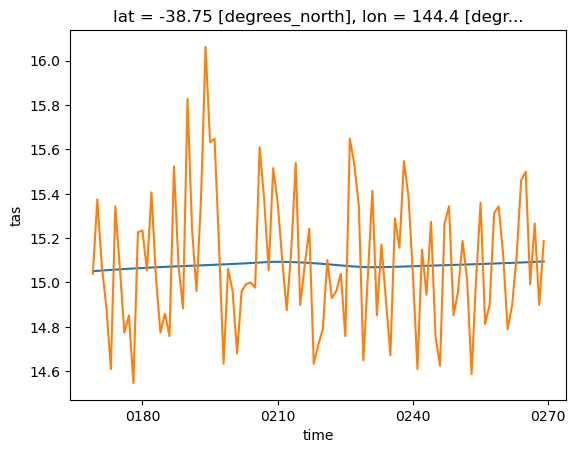

In [275]:
test_local_lowess.sel(lat=-39, lon=145, method='nearest').plot()
a1_full_data[0].sel(lat=-39, lon=145, method='nearest').plot()

In [276]:
local_lowess_list = []

for model in a1_full_data.model:
    print(model)
    local_lowess_model = xr.apply_ufunc(
        calculate_lowess, 
        a1_full_data[model], 
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        dask='parallelized',
        vectorize=True,
        output_dtypes=[float],    
        kwargs={'window':81}
    ).compute()
    local_lowess_list.append(local_lowess_model)

ACCESS-ESM1-5
CESM2
CanESM5
GFDL-ESM4
GISS-E2-1-G-CC
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL


In [277]:
local_lowess_data = listXarray(local_lowess_list, 'model')
local_lowess_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192, 'time': 101})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288, 'time': 150})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 100})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288, 'time': 200})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144, 'time': 180})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 248})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192, 'time': 185})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144, 'time': 100})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192, 'time': 330})

In [278]:
local_lowess_50_data = local_lowess_data.isel(time=50) - local_lowess_data.isel(time=0)

In [279]:
local_lowess_90_data = local_lowess_data.isel(time=50) - local_lowess_data.isel(time=0)

### All Models - Plotting

Note, the code for the plotting comes after the calculation. But, easier ton do this way around so I don't have to comment things out.

In [280]:
client.cluster.scale(12)

In [281]:
from listXarray import read_listxarray

In [282]:
OPEN_DIR = '/g/data/w40/ab2313/zecmip_new_temp_estimation/a1_local_ceemdan_t2'

In [283]:
local_emd_data = read_listxarray(OPEN_DIR).to_dataarray('tas')

In [284]:
local_emd_data

key_dim = model


Number of da/ds: 9
---------------
ACCESS-ESM1-5  (dataArray): ({'model': 1, 'lat': 145, 'lon': 192, 'time': 101})
CESM2          (dataArray): ({'model': 1, 'lat': 192, 'lon': 288, 'time': 150})
CanESM5        (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 100})
GFDL-ESM4      (dataArray): ({'model': 1, 'lat': 180, 'lon': 288, 'time': 200})
GISS-E2-1-G-CC (dataArray): ({'model': 1, 'lat': 90, 'lon': 144, 'time': 180})
MIROC-ES2L     (dataArray): ({'model': 1, 'lat': 64, 'lon': 128, 'time': 248})
MPI-ESM1-2-LR  (dataArray): ({'model': 1, 'lat': 96, 'lon': 192, 'time': 185})
NorESM2-LM     (dataArray): ({'model': 1, 'lat': 96, 'lon': 144, 'time': 100})
UKESM1-0-LL    (dataArray): ({'model': 1, 'lat': 144, 'lon': 192, 'time': 330})

In [285]:
local_emd_50 = local_emd_data.isel(time=50) - local_emd_data.isel(time=0)

In [286]:
local_emd_90 = local_emd_data.isel(time=90) - local_emd_data.isel(time=0)

In [287]:
temp_levels = np.arange(-2, 2.25, .25)

In [288]:
local_lowess_50_data = local_lowess_50_data.compute()
local_emd_50 = local_emd_50.compute()
zec50_data = zec50_data.compute()
# local_lowess_50_data = local_lowess_50_data.compute()

Text(0.5, 0.91, 'Temperature Estimate 90 Years After Emission Cessation')

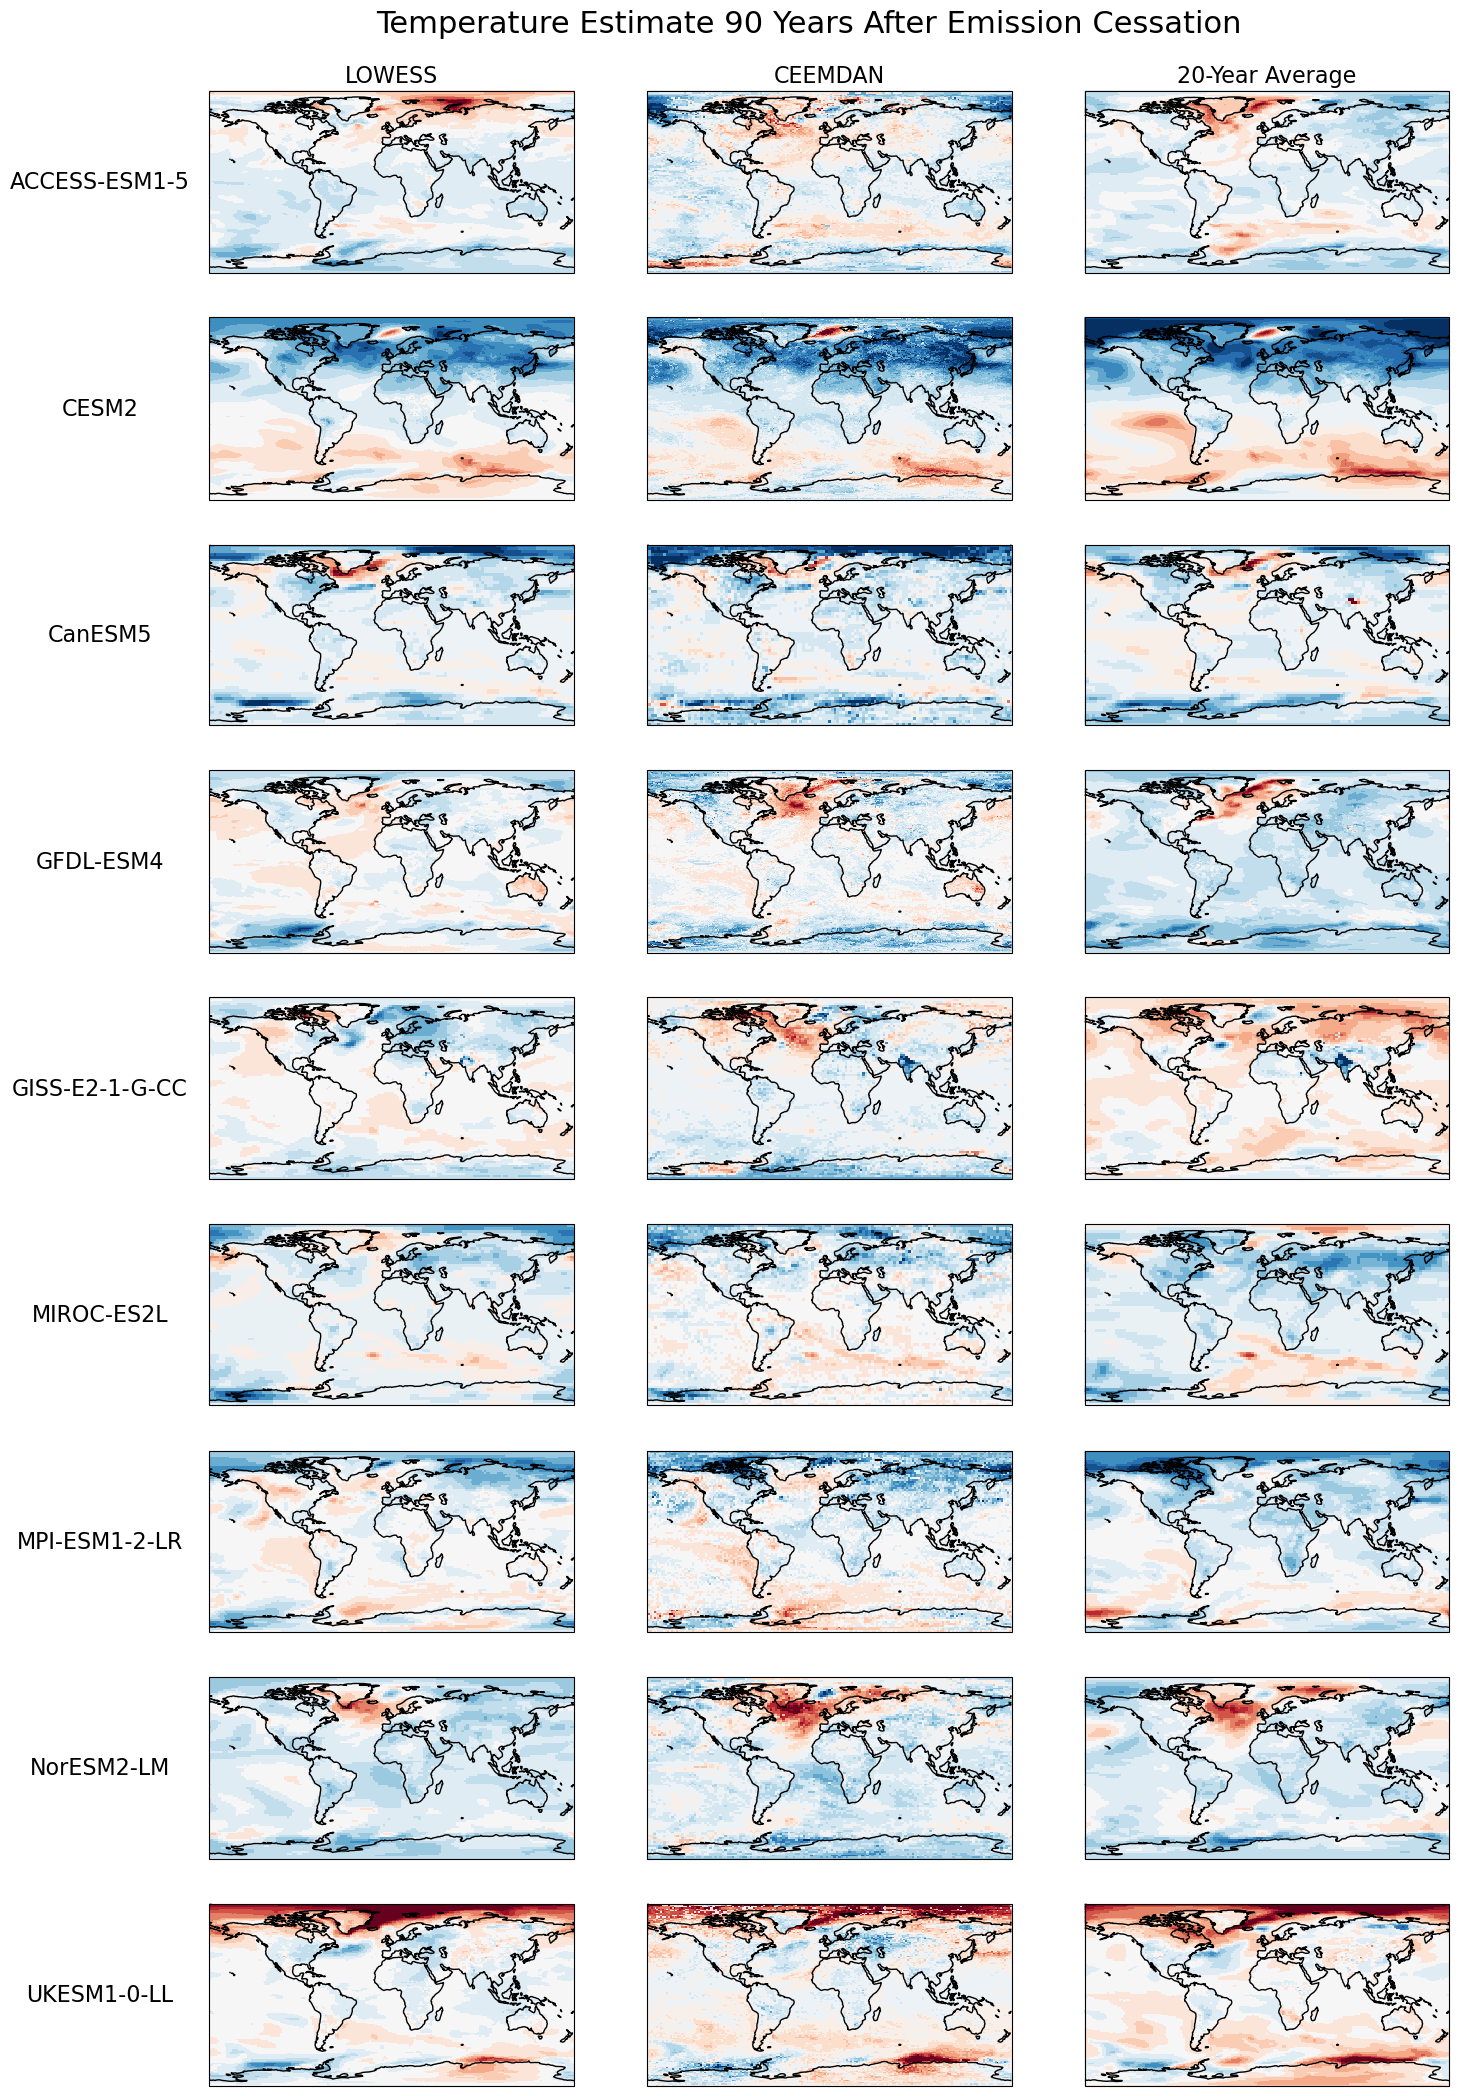

In [289]:
fig = plt.figure(figsize=(16, 26))

gs = gridspec.GridSpec(9, 3)

for row, model in enumerate(local_emd_50.model):
    
    ax0 = fig.add_subplot(gs[row, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(gs[row, 1], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[row, 2], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2]

    local_lowess_90_data[model].plot(ax=ax0, levels=temp_levels, add_colorbar=False)
    local_emd_90[model].plot(ax=ax1, levels=temp_levels, add_colorbar=False)
    zec90_data[model].plot(ax=ax2, levels=temp_levels, add_colorbar=False)
    
    for ax in axes: ax.coastlines()


    if row == 0:
        ax0.set_title('LOWESS', fontsize=16)
        ax1.set_title('CEEMDAN', fontsize=16)
        ax2.set_title('20-Year Average', fontsize=16)
    else:
        for ax in axes: ax.set_title('')
    ax0.annotate(model, xy=(-0.3, 0.5), size=16, xycoords='axes fraction', ha='center', va='center')

fig.suptitle('Temperature Estimate 90 Years After Emission Cessation', fontsize=22, y=0.91)

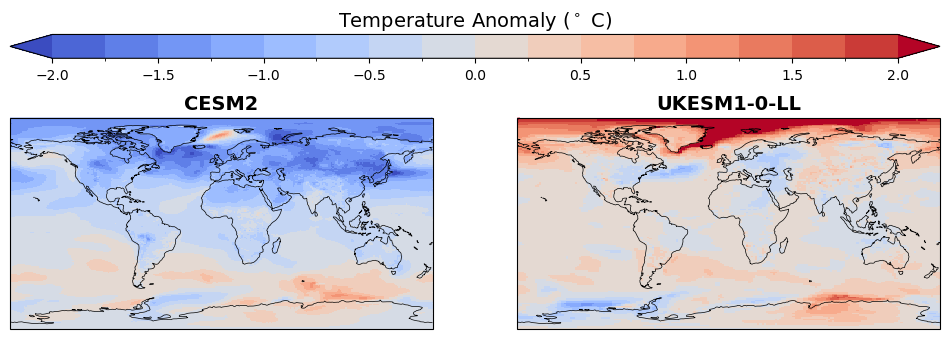

In [290]:

model_subset = ['CESM2', 'UKESM1-0-LL']
fig = plt.figure(figsize=(12, 4))

# Set up gridspec with space for titles and clean spacing
gs = gridspec.GridSpec(2, 2, height_ratios=[0.1, 1], hspace=0.35)

for num, model in enumerate(model_subset):
    ax0 = fig.add_subplot(gs[1, num], projection=ccrs.PlateCarree())


    # Plot data with clean and clear settings
    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both', cmap='coolwarm')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    
    # Add fine coastlines for clarity without overpowering
    ax0.coastlines(linewidth=0.5)
    
    # Reduce number of grid lines for cleaner look
    
    # Model titles with appropriate size and placement
    ax0.set_title(model, fontsize=14, weight='bold')

# Colorbar at the top for balance and clean title
cax = plt.subplot(gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=14)

# Tight layout to ensure spacing looks great
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Temperature Anomaly ($^\\circ$ C)')

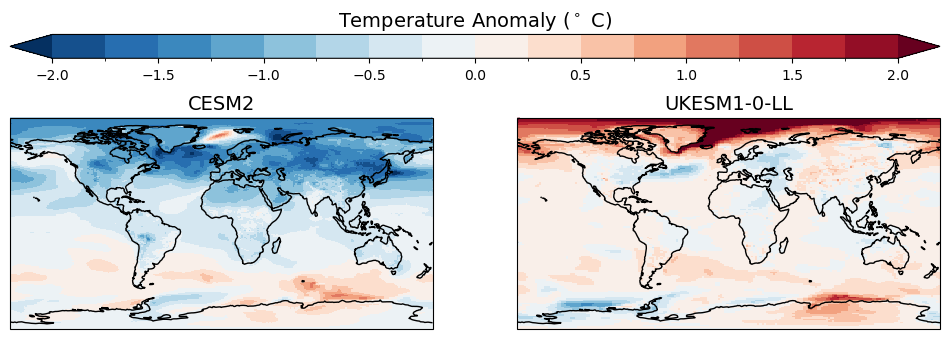

In [291]:
model_subset = ['CESM2', 'UKESM1-0-LL']
fig = plt.figure(figsize=(12, 4))

gs = gridspec.GridSpec(2, 2, height_ratios=[0.1] + [1], hspace=0.35)

for num, model in enumerate(model_subset):
    ax0 = fig.add_subplot(gs[1, num], projection=ccrs.PlateCarree())
    axes = [ax0]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    
    for ax in axes: ax.coastlines()

    ax.set_title(model, fontsize=14)


cax = plt.subplot(gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=14)

In [297]:
local_emd_50.model

array(['ACCESS-ESM1-5', 'CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC',
       'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'],
      dtype='<U14')

In [327]:
fontscale = 1.3

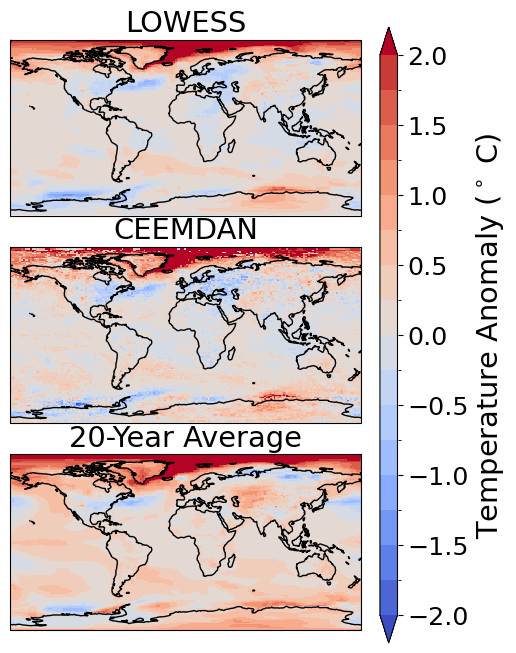

In [355]:
# model_list = ['ACCESS-ESM1-5', 'CESM2', 'UKESM1-0-LL']
model_list = ['UKESM1-0-LL']#['CESM2']#

nrows = len(model_list)

fig = plt.figure(figsize=(5*nrows, 8)) # 3.5

outer_gs = gridspec.GridSpec(1, 2, wspace=.1, width_ratios=[1, 0.05])

inner_gs1 = gridspec.GridSpecFromSubplotSpec(3, len(model_list), subplot_spec=outer_gs[0], hspace=.03)

# gs = gridspec.GridSpec(nrows+1, 3, height_ratios=[0.2] + [1]* nrows, hspace=0.25)

for row, model in enumerate(model_list):
    # row =row+1
    ax0 = fig.add_subplot(inner_gs1[0, row], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(inner_gs1[1, row], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(inner_gs1[2, row], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both', cmap='coolwarm')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    local_emd_50[model].plot(ax=ax1, **contour_kwargs)
    zec50_data[model].plot(ax=ax2, **contour_kwargs)
    
    for ax in axes: ax.coastlines()


    if row == 0:
        ax0.set_title('LOWESS', fontsize=16*fontscale)
        ax1.set_title('CEEMDAN', fontsize=16*fontscale)
        ax2.set_title('20-Year Average', fontsize=16*fontscale)
    else:
        for ax in axes: ax.set_title('')
    # ax0.annotate(model, xy=(-0.3, 0.5), size=16*fontscale, xycoords='axes fraction', ha='center', va='center')

# fig.suptitle('Temperature Anomalies 50 Years After Emission Cessation', fontsize=22, y=0.91)

cax = plt.subplot(outer_gs[:, 1])
cbar = plt.colorbar(contour, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=16*fontscale)
cbar.ax.tick_params(labelsize=14*fontscale)

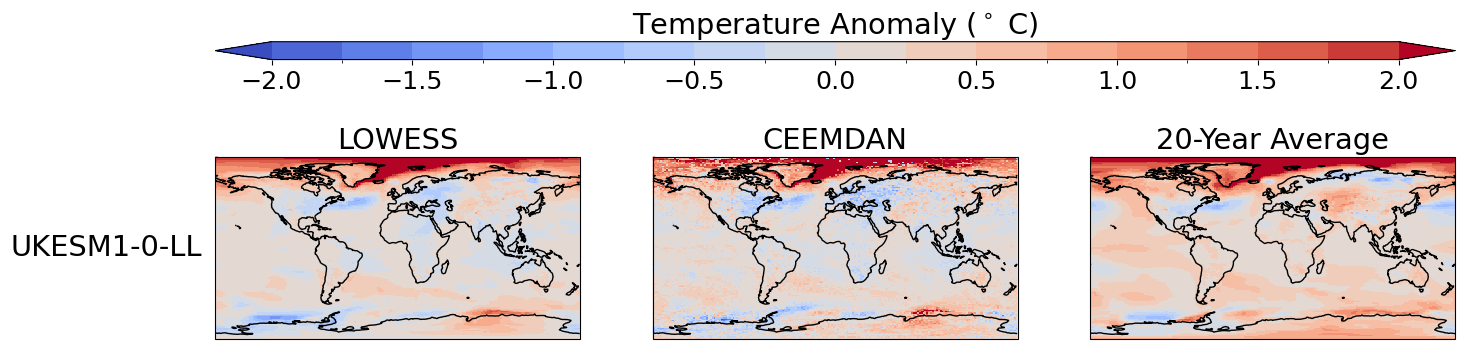

In [338]:
# model_list = ['ACCESS-ESM1-5', 'CESM2', 'UKESM1-0-LL']
model_list = ['UKESM1-0-LL']#['CESM2']

nrows = len(model_list)

fig = plt.figure(figsize=(16, 5*nrows)) # 3.5

outer_gs = gridspec.GridSpec(2, 1, hspace=.05, height_ratios=[0.05, 1])

inner_gs1 = gridspec.GridSpecFromSubplotSpec(len(model_list), 3, subplot_spec=outer_gs[1], hspace=.01)

# gs = gridspec.GridSpec(nrows+1, 3, height_ratios=[0.2] + [1]* nrows, hspace=0.25)

for row, model in enumerate(model_list):
    # row =row+1
    ax0 = fig.add_subplot(inner_gs1[row, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(inner_gs1[row, 1], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(inner_gs1[row, 2], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both', cmap='coolwarm')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    local_emd_50[model].plot(ax=ax1, **contour_kwargs)
    zec50_data[model].plot(ax=ax2, **contour_kwargs)
    
    for ax in axes: ax.coastlines()


    if row == 0:
        ax0.set_title('LOWESS', fontsize=16*fontscale)
        ax1.set_title('CEEMDAN', fontsize=16*fontscale)
        ax2.set_title('20-Year Average', fontsize=16*fontscale)
    else:
        for ax in axes: ax.set_title('')
    ax0.annotate(model, xy=(-0.3, 0.5), size=16*fontscale, xycoords='axes fraction', ha='center', va='center')

# fig.suptitle('Temperature Anomalies 50 Years After Emission Cessation', fontsize=22, y=0.91)

cax = plt.subplot(outer_gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=16*fontscale)
cbar.ax.tick_params(labelsize=14*fontscale)

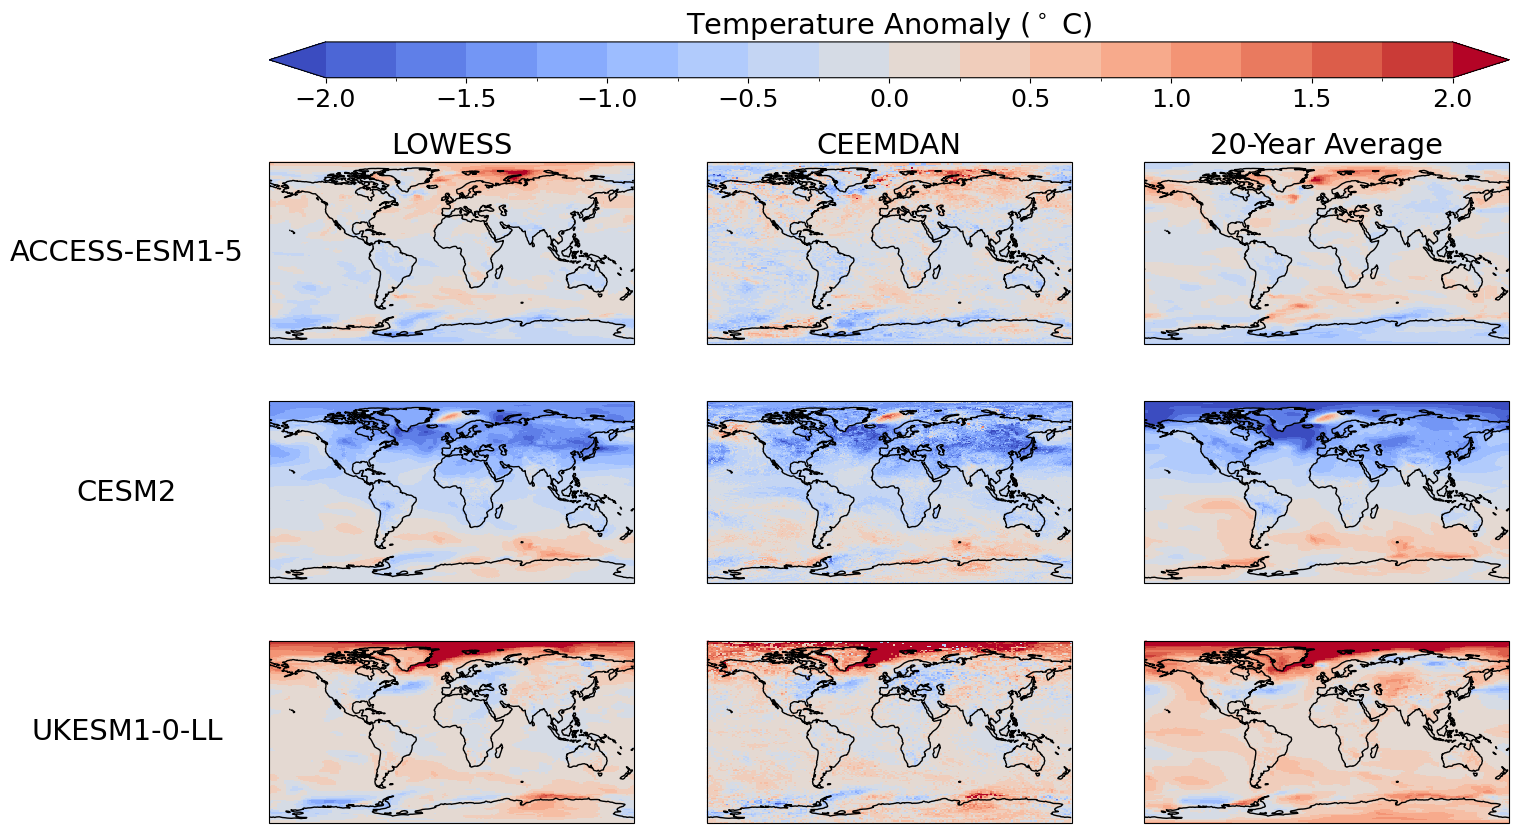

In [334]:
model_list = ['ACCESS-ESM1-5', 'CESM2', 'UKESM1-0-LL']
nrows = len(model_list)

fig = plt.figure(figsize=(16, 3.5*nrows))

outer_gs = gridspec.GridSpec(2, 1, hspace=.15, height_ratios=[0.05, 1])

inner_gs1 = gridspec.GridSpecFromSubplotSpec(len(model_list), 3, subplot_spec=outer_gs[1], hspace=.01)

# gs = gridspec.GridSpec(nrows+1, 3, height_ratios=[0.2] + [1]* nrows, hspace=0.25)

for row, model in enumerate(model_list):
    # row =row+1
    ax0 = fig.add_subplot(inner_gs1[row, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(inner_gs1[row, 1], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(inner_gs1[row, 2], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both', cmap='coolwarm')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    local_emd_50[model].plot(ax=ax1, **contour_kwargs)
    zec50_data[model].plot(ax=ax2, **contour_kwargs)
    
    for ax in axes: ax.coastlines()


    if row == 0:
        ax0.set_title('LOWESS', fontsize=16*fontscale)
        ax1.set_title('CEEMDAN', fontsize=16*fontscale)
        ax2.set_title('20-Year Average', fontsize=16*fontscale)
    else:
        for ax in axes: ax.set_title('')
    ax0.annotate(model, xy=(-0.3*fontscale, 0.5), size=16*fontscale, xycoords='axes fraction', ha='center', va='center')

# fig.suptitle('Temperature Anomalies 50 Years After Emission Cessation', fontsize=22, y=0.91)

cax = plt.subplot(outer_gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=16*fontscale)
cbar.ax.tick_params(labelsize=14*fontscale)

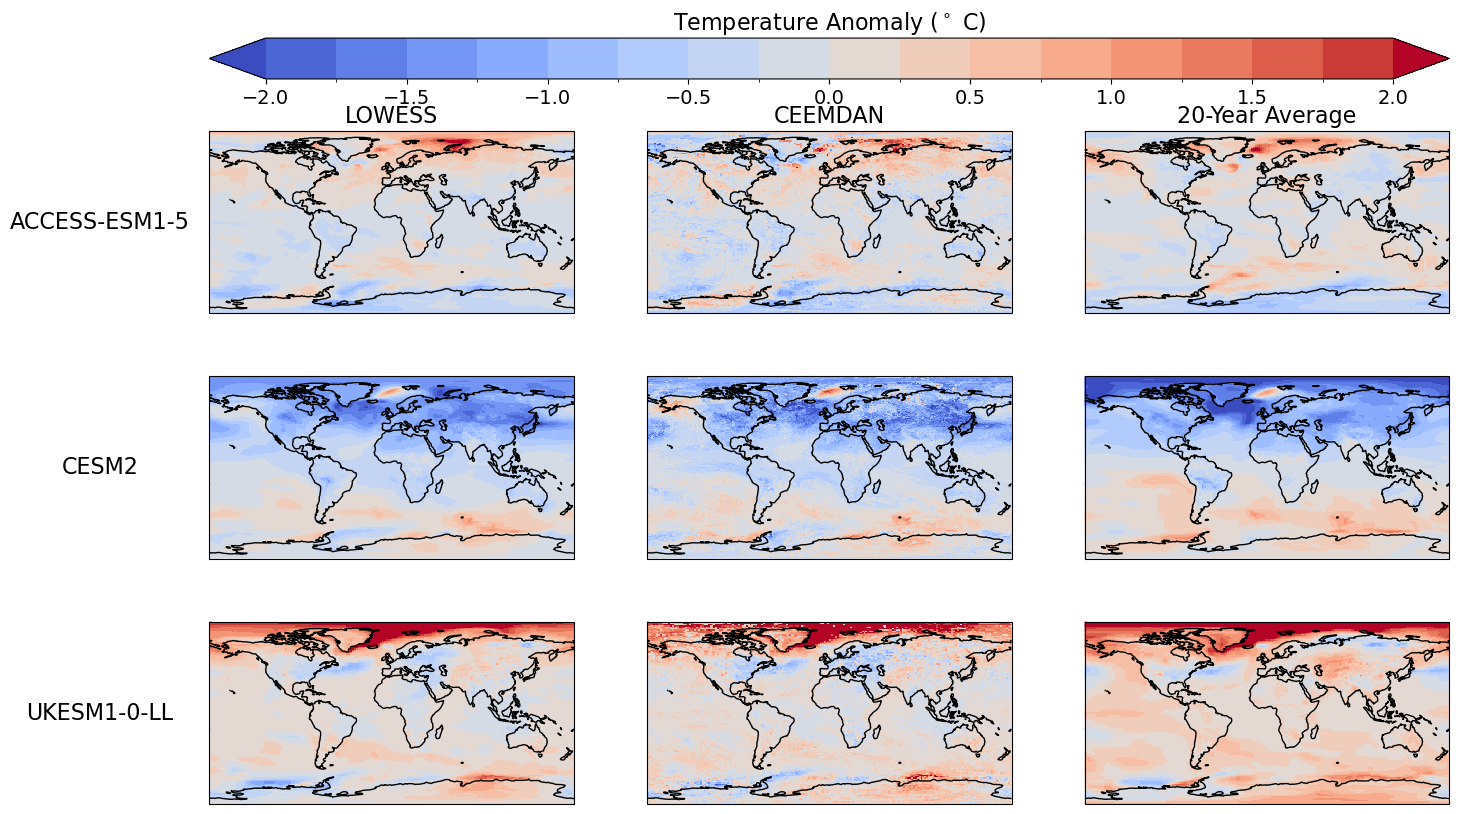

In [319]:
model_list = ['ACCESS-ESM1-5', 'CESM2', 'UKESM1-0-LL']
nrows = len(model_list)

fig = plt.figure(figsize=(16, 3.5*nrows))

gs = gridspec.GridSpec(nrows+1, 3, height_ratios=[0.2] + [1]* nrows, hspace=0.25)

for row, model in enumerate(model_list):
    row =row+1
    ax0 = fig.add_subplot(gs[row, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(gs[row, 1], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[row, 2], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both', cmap='coolwarm')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    local_emd_50[model].plot(ax=ax1, **contour_kwargs)
    zec50_data[model].plot(ax=ax2, **contour_kwargs)
    
    for ax in axes: ax.coastlines()


    if row == 1:
        ax0.set_title('LOWESS', fontsize=16)
        ax1.set_title('CEEMDAN', fontsize=16)
        ax2.set_title('20-Year Average', fontsize=16)
    else:
        for ax in axes: ax.set_title('')
    ax0.annotate(model, xy=(-0.3, 0.5), size=16, xycoords='axes fraction', ha='center', va='center')

# fig.suptitle('Temperature Anomalies 50 Years After Emission Cessation', fontsize=22, y=0.91)

cax = plt.subplot(gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)
fig.subplots_adjust(top=0.85)  # Push the subplots downward

Text(0.5, 1.0, 'Temperature Anomaly ($^\\circ$ C)')

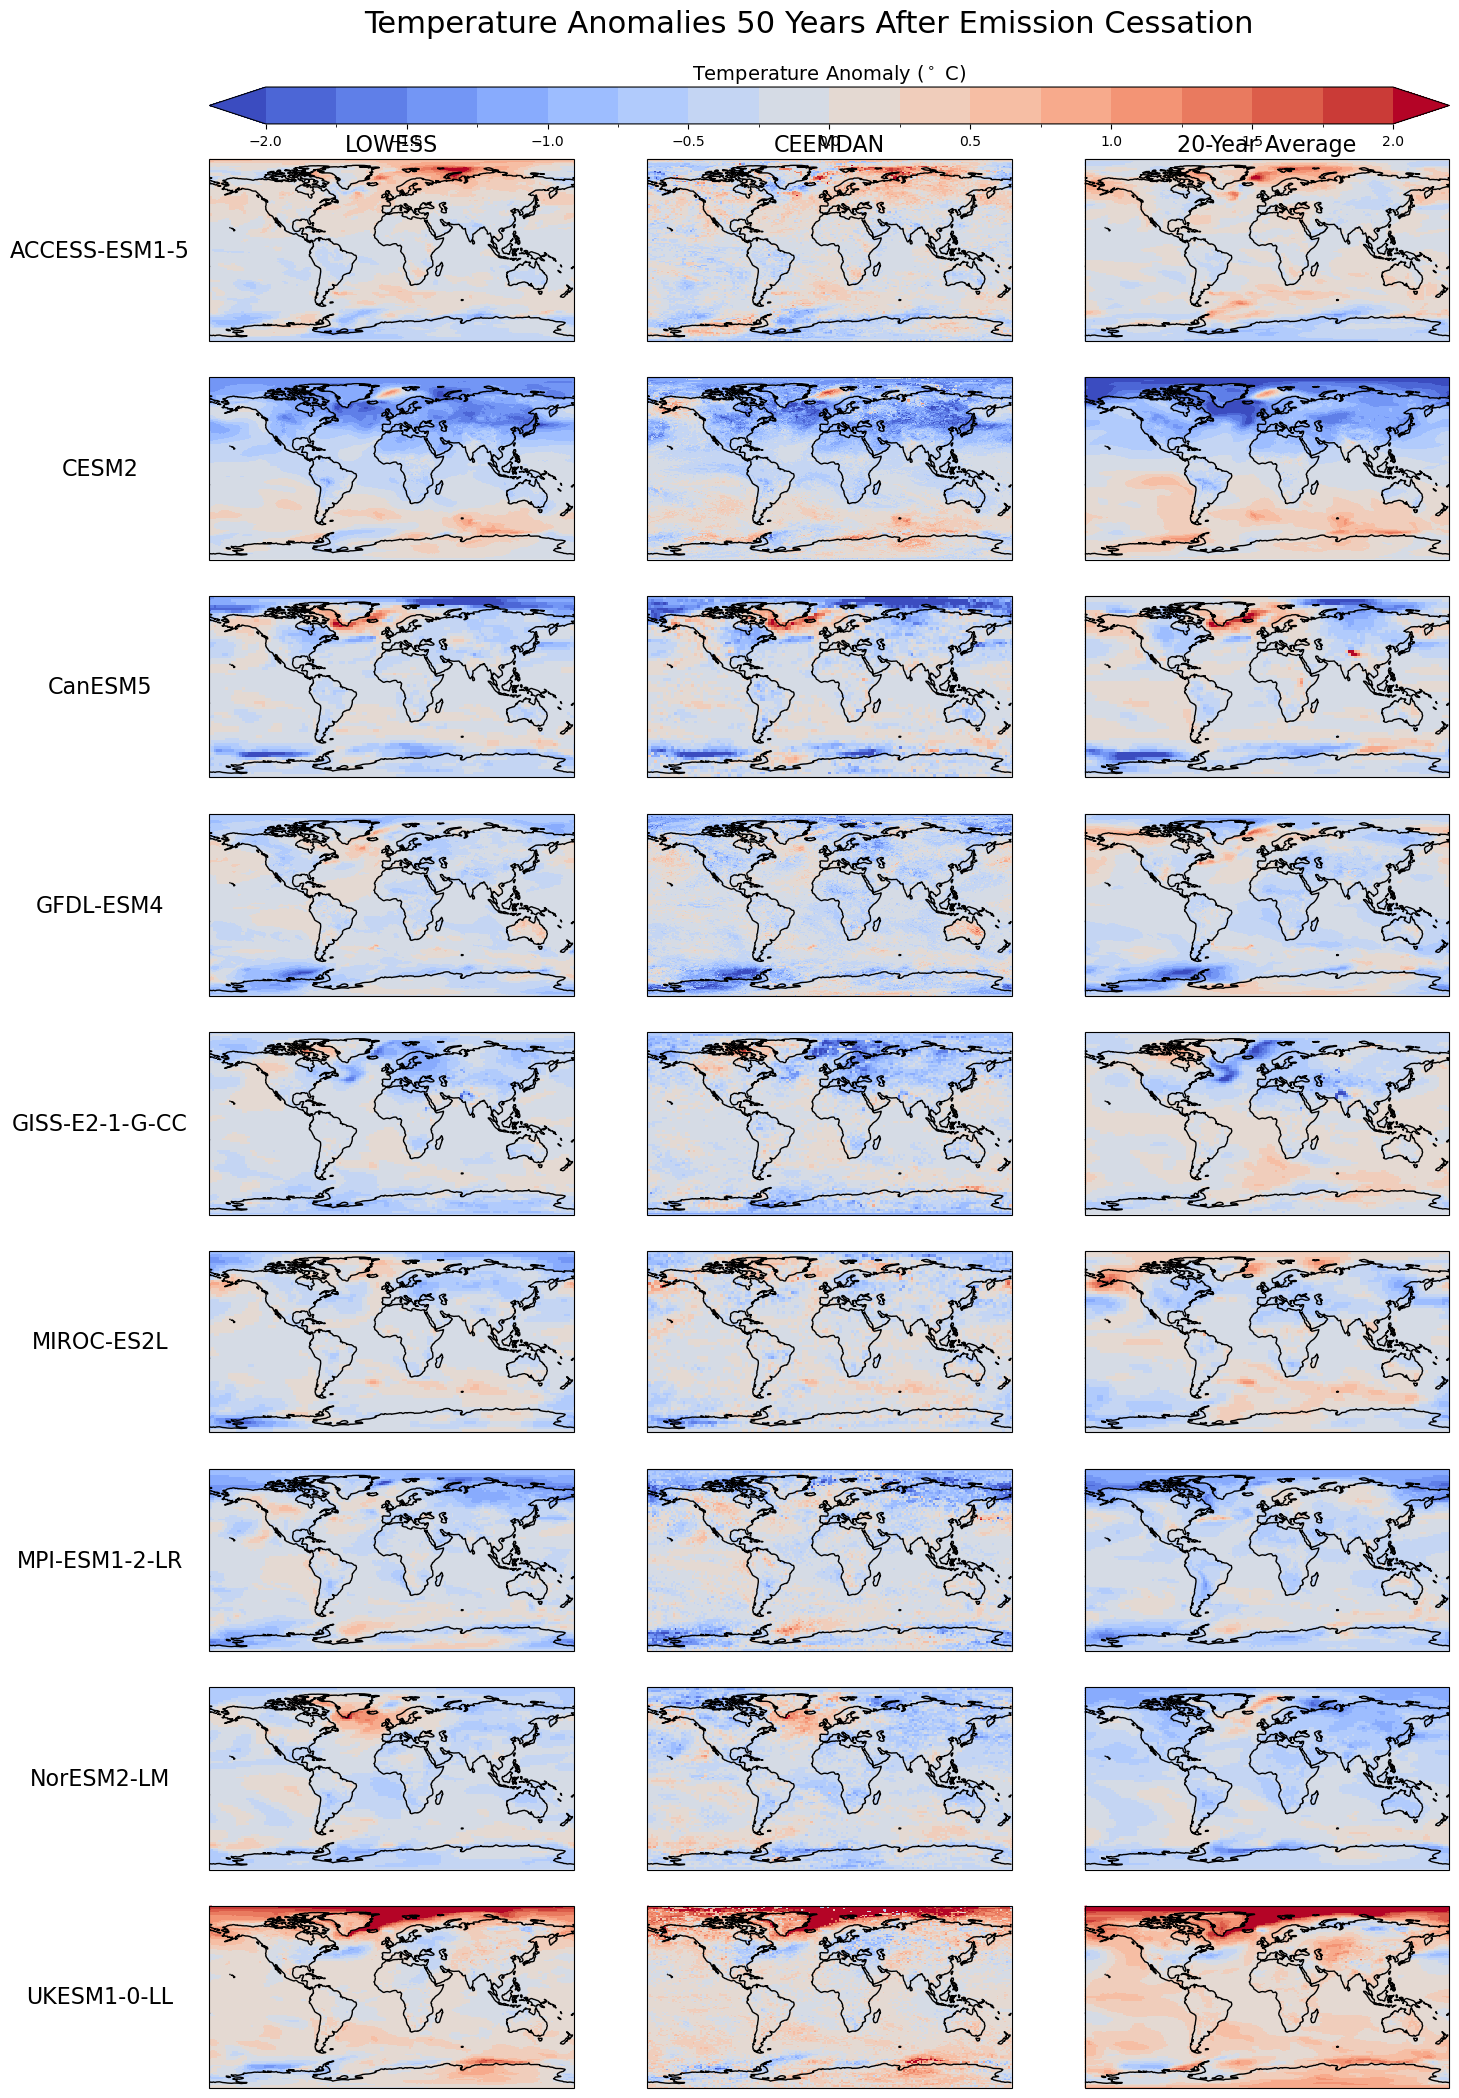

In [295]:
fig = plt.figure(figsize=(16, 26))

gs = gridspec.GridSpec(10, 3, height_ratios=[0.2] + [1]* 9)

for row, model in enumerate(local_emd_50.model):
    row =row+1
    ax0 = fig.add_subplot(gs[row, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(gs[row, 1], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[row, 2], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both', cmap='coolwarm')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    local_emd_50[model].plot(ax=ax1, **contour_kwargs)
    zec50_data[model].plot(ax=ax2, **contour_kwargs)
    
    for ax in axes: ax.coastlines()


    if row == 1:
        ax0.set_title('LOWESS', fontsize=16)
        ax1.set_title('CEEMDAN', fontsize=16)
        ax2.set_title('20-Year Average', fontsize=16)
    else:
        for ax in axes: ax.set_title('')
    ax0.annotate(model, xy=(-0.3, 0.5), size=16, xycoords='axes fraction', ha='center', va='center')

fig.suptitle('Temperature Anomalies 50 Years After Emission Cessation', fontsize=22, y=0.91)

cax = plt.subplot(gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=14)

In [ ]:
fig = plt.figure(figsize=(16, 20))

gs = gridspec.GridSpec(10, 4, height_ratios=[0.2] + [1]* 9)

for row, model in enumerate(local_emd_50.model):
    row =row+1
    ax0 = fig.add_subplot(gs[row, 0], projection=ccrs.PlateCarree())
    ax1 = fig.add_subplot(gs[row, 1], projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(gs[row, 2], projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(gs[row, 3], projection=ccrs.PlateCarree())
    axes = [ax0, ax1, ax2, ax3]

    contour_kwargs = dict(add_colorbar=False, levels=temp_levels, extend='both')
    contour = local_lowess_50_data[model].plot(ax=ax0, **contour_kwargs)
    local_emd_50[model].plot(ax=ax1, **contour_kwargs)
    zec50_data[model].plot(ax=ax2, **contour_kwargs)
    (zec50_data[model]-local_emd_50[model]).plot(ax=ax3, **contour_kwargs)
    
    for ax in axes: ax.coastlines()


    if row == 0:
        ax0.set_title('LOWESS', fontsize=14)
        ax1.set_title('CEEMDAN', fontsize=14)
        ax2.set_title('ZEC50', fontsize=14)
        ax3.set_title('ZEC50 - CEEMDAN', fontsize=14)
    else:
        for ax in axes: ax.set_title('')
    ax0.annotate(model, xy=(-0.4, 0.5), size=14, xycoords='axes fraction', ha='center', va='center')

cax = plt.subplot(gs[0, :])
cbar = plt.colorbar(contour, cax=cax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly ('+r'$^\circ$ C)', fontsize=14)

In [260]:
local_sample_da = a1_full_data[-1].sel(lat=82, lon=10, method='nearest').squeeze().compute().reset_coords(drop=True)

In [261]:
local_sample_da['time'] = np.arange(local_sample_da.time.shape[-0])

In [262]:
local_sample_da

<xarray.DataArray 'tas' (time: 330)> Size: 1kB
-5.796 -4.399 -3.592 -5.765 -6.155 -6.201 ... -4.463 -3.695 -5.134 -6.327 -5.065
Coordinates:
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 323 324 325 326 327 328 329

In [263]:
# Version for using in xr.apply_ufunc that uses numpy arrays
local_sample_imf_filtered_arr = calculate_CEEMDAN_local_with_FFT_filter(local_sample_da.values)

NameError: name 'calculate_CEEMDAN_local_with_FFT_filter' is not defined

In [264]:
# This version works with xarray data arrays
local_sample_imf_da = calculate_CEEMDAN(local_sample_da)
local_sample_imf_filtered_da = filter_imfs_by_wavelgnth(local_sample_imf_da)

NameError: name 'calculate_CEEMDAN' is not defined

In [265]:
local_sample_imf_filtered_da

NameError: name 'local_sample_imf_filtered_da' is not defined

In [ ]:
local_sample_series = local_sample_imf_filtered_da.sum(dim='imf')

In [ ]:
local_sample_series.plot()
local_sample_da.plot()
plt.plot(local_sample_imf_filtered_arr)
plt.plot(local_lowess_data[-1].sel(lat=82, lon=10, method='nearest').squeeze().values)

In [ ]:
local_sample_imf_filtered_da

In [ ]:
imf_da = local_sample_imf_filtered_da

# Plot the results
n_imfs = len(imf_da.imf)
fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(n_imfs+1, 1, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(n_imfs+1)]

# Plot original signal
axes[0].plot(local_sample_da.time.values, 
             local_sample_da.values)
axes[0].set_ylabel("Original\nSignal", rotation=0, labelpad=25)

# Plot IMFs
for i, imf in enumerate(imf_da.imf.values):

    axes[i + 1].plot(imf_da.time.values, imf_da.squeeze().sel(imf=imf), color='green')

    axes[i + 1].set_ylabel(f"IMF {imf + 1}" if i < n_imfs-1 else 'Residual', rotation=0, labelpad=25)

In [ ]:
a1_full_data[-1].sel(lat=82, lon=10, method='nearest').plot()
local_lowess_data[-1].sel(lat=82, lon=10, method='nearest').plot()
local_emd_data[-1].sel(lat=82, lon=10, method='nearest').plot()

In [ ]:
zec50_data[-1].sel(lat=slice(75, 85), lon=slice(0, 20)).plot()

In [ ]:
local_emd_50[-1].plot()

In [ ]:
a1_full_data[-1]

In [ ]:

def regrid_datasets(local_data, target_model_name, method='nearest_s2d'):
    import xesmf

    # Drop ensemble and model dimensions from the target dataset
    target_ds = local_data[target_model_name].drop(['ensemble', 'model'], errors='ignore')
    
    regridded_file_list = []
    
    # Iterate through all models in the dataset
    for model in local_data.model:
        print(f"Processing model: {model}")
        
        if target_model_name not in model:
            ds_to_regrid = local_data[model].drop(['ensemble', 'model'], errors='ignore')
            
            # Create a regridder for the current model
            regridder = xesmf.Regridder(ds_to_regrid, target_ds, method=method)
            
            # Perform the regridding
            regridded_file = regridder(ds_to_regrid).squeeze('model')
            regridded_file = regridded_file.expand_dims(model=[model])
        else:
            # If the model is the target model, use it directly
            regridded_file = local_data[model]
        
        regridded_file_list.append(regridded_file)
    
    # Combine all regridded files into a single xarray dataset
    return listXarray(regridded_file_list, key_dim='model')

In [ ]:
zec50_data

In [ ]:
zec50_data_regrid = regrid_datasets(zec50_data, target_model_name='MPI-ESM1-2-LR')
zec50_data_regrid_da = zec50_data_regrid.concat('model')

In [ ]:
local_lowess_50_data_regrid = regrid_datasets(local_lowess_50_data, target_model_name='MPI-ESM1-2-LR')
local_lowess_50_data_regrid_da = local_lowess_50_data_regrid.concat('model')

In [ ]:
local_emd_50_regrid = regrid_datasets(local_emd_50, target_model_name='MPI-ESM1-2-LR')
local_emd_50_regrid_da = local_emd_50_regrid.concat('model')

In [ ]:
np.diff(local_emd_50['MPI-ESM1-2-LR'].lon.values)

In [ ]:
np.diff(local_emd_50['MPI-ESM1-2-LR'].lat.values)

In [ ]:
local_emd_50_regrid_cooling = xr.where(local_emd_50_regrid_da<0, 1, 0)
local_emd_50_regrid_warming= xr.where(local_emd_50_regrid_da>0, 1, 0)

In [ ]:
local_lowess_50_regrid_cooling = xr.where(local_lowess_50_data_regrid_da<0, 1, 0)
local_lowess_50_regrid_warming= xr.where(local_lowess_50_data_regrid_da>0, 1, 0)

In [ ]:
zec50_data_regrid_da_cooling = xr.where(zec50_data_regrid_da<0, 1, 0)
zec50_data_regrid_da_warming = xr.where(zec50_data_regrid_da>0, 1, 0)

In [ ]:
local_emd_50_regrid_cooling

In [ ]:
fig = plt.figure(figsize=(12, 4))

# Set up gridspec with space for titles and clean spacing
gs = gridspec.GridSpec(2, 2, height_ratios=[0.1, 1], hspace=0.35)



ax1 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())


axes = [ax1, ax2]

number_kwargs = dict(levels=np.arange(0, 11), cmap='viridis', add_colorbar=False, alpha=1)

local_lowess_50_regrid_cooling.sum(dim='model').plot(ax=ax1, **number_kwargs)
plot = local_lowess_50_regrid_warming.sum(dim='model').plot(ax=ax2, **number_kwargs)




ax1.set_title('Number of Models Cooling')
ax2.set_title('Number of Models Warming')



for ax in axes: ax.coastlines()

cax = plt.subplot(gs[0, :])
# Adjusting colorbar settings for centered ticks without extra lines
cbar = plt.colorbar(plot, cax=cax, orientation='horizontal', drawedges=False)
cbar.ax.set_title('Number of Models')

# Set ticks to be centered in each color segment
cbar.set_ticks(np.arange(0.5, 10.5, 1))
cbar.set_ticklabels(np.arange(0, 10, 1))
cbar.ax.tick_params(size=0, length=0, color='none')

In [ ]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3, 2, height_ratios=[0.15] + 2* [1], hspace=0.5, wspace=0.1)

ax1 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())

axes = [ax1, ax2, ax3, ax4]

number_kwargs = dict(levels=np.arange(0, 11), cmap='viridis', add_colorbar=False, alpha=1)

local_lowess_50_regrid_cooling.sum(dim='model').plot(ax=ax1, **number_kwargs)
plot = local_lowess_50_regrid_warming.sum(dim='model').plot(ax=ax2, **number_kwargs)

zec50_data_regrid_da_cooling.sum(dim='model').plot(ax=ax3, **number_kwargs)
zec50_data_regrid_da_warming.sum(dim='model').plot(ax=ax4, **number_kwargs)



ax1.set_title('Number of Models Cooling')
ax2.set_title('Number of Models Warming')
ax3.set_title('')
ax4.set_title('')


ax1.annotate('CEEMDAN', xy=(-0.17, 0.5), size=12, xycoords='axes fraction', ha='center', va='center')
ax3.annotate('20-Year\nAverage', xy=(-0.17, 0.5), size=12, xycoords='axes fraction', ha='center', va='center')

for ax in axes: ax.coastlines()

cax = plt.subplot(gs[0, :])
# Adjusting colorbar settings for centered ticks without extra lines
cbar = plt.colorbar(plot, cax=cax, orientation='horizontal', drawedges=False)
cbar.ax.set_title('Number of Models')

# Set ticks to be centered in each color segment
cbar.set_ticks(np.arange(0.5, 10.5, 1))
cbar.set_ticklabels(np.arange(0, 10, 1))
cbar.ax.tick_params(size=0, length=0, color='none')

### All Models CEEMDAN - Calculation

In [ ]:
from time import time as time_it

In [ ]:
client.close()
client = Client(memory_limit=None, threads_per_worker=1, n_workers=80)
client

In [ ]:
a1_full_data = a1_full_data.astype(np.float16).compute().chunk(chunks_model_based_tiny)

In [ ]:
a1_full_data

In [ ]:
SAVE_DIR = '/g/data/w40/ab2313/zecmip_new_temp_estimation/a1_local_ceemdan_t2'

In [ ]:
# local_imf_da = xr.apply_ufunc(
#     calculate_CEEMDAN_local_with_FFT_filter,
#     a1_full_data[model],
#     input_core_dims=[['time']],
#     output_core_dims=[['time']],  
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[float])

In [ ]:
# local_imf_da = local_imf_da.compute()

In [ ]:
for model in a1_full_data.model:
    t1 = time_it()
    print(model)
    
    local_imf_da = xr.apply_ufunc(
        calculate_CEEMDAN_local_with_FFT_filter,
        a1_full_data[model],
        input_core_dims=[['time']],
        output_core_dims=[['time']],  
        dask='parallelized',
        vectorize=True,
        output_dtypes=[float])

    local_imf_da = local_imf_da.compute()
    print(' - calculation complete')


    local_imf_da.to_netcdf(os.path.join(SAVE_DIR, model+'.nc'))
    time_taken = (time_it() - t1)/60
    print(f'saving complete ({time_taken=}minutes)')

### Single Model Example

In [ ]:
# a1_full_data = a1_full_data.transpose(*['model','lat', 'lon', 'time'])
# a1_full_data = a1_full_data.compute()

In [ ]:
d1 = a1_full_data[0].squeeze().compute().chunk(chunks_model_based_tiny['UKESM1-0-LL'])

In [ ]:
# d1 = d1.transpose('lat', 'lon', 'time')

In [ ]:
dask.visualize(d1)

In [ ]:
d1

In [ ]:
local_imf_da = xr.apply_ufunc(
    calculate_CEEMDAN_local,
    d1,
    # a1_full_data[0].isel(lat=slice(0,5), lon=slice(0,5)).squeeze(),
    input_core_dims=[['time']],
    output_core_dims=[['imf', 'time']],  # The 'imf' dimension comes first
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],  # Only one output dtype since both outputs are merged
    # dask_gufunc_kwargs={'output_sizes': {'imf': 2}}  # Define the size of the 'imf' dimension
)#.compute()
# local_imf_da = local_imf_da.transpose( 'lat', 'lon', 'imf', 'time')

In [ ]:
local_imf_da = local_imf_da.compute()

In [ ]:
local_imf_da.isel(lat=0, lon=0).sum(dim='imf').plot()
a1_full_data[0].isel(lat=0, lon=0).plot()

# Ensembles

In [ ]:
def calculate_CEEMDAN_local_with_FFT_filter_v2(signal):
    print(signal.shape)
    # Perform the decomposition
    IMFs = ceedman(signal)

    # Get the last two IMFs
    res = IMFs[-1]
    # imfs = IMFs[:-1]
    # time = np.arange(len(res))
    # filtered_imfs = filter_imf_arr(imfs, time)

    series = res# + np.sum(filtered_imfs, axis=0)

    return series

In [ ]:
a1_can_ensembles = a1_can_ensembles.resample(time='Y').mean()
a1_can_smean_ensembles = my_stats.space_mean(a1_can_ensembles)

In [ ]:
a1_ukesm_ensembles = a1_ukesm_ensembles.resample(time='Y').mean()
a1_ukesm_smean_ensembles = my_stats.space_mean(a1_ukesm_ensembles)

In [ ]:
a1_ukesm_smean_ens_mean = a1_ukesm_smean_ensembles.mean(dim='ensemble').squeeze()
a1_can_smean_ens_mean = a1_can_smean_ensembles.mean(dim='ensemble').squeeze()

In [ ]:
a1_ukesm_smean_ensembles.ensemble.values

In [ ]:
a1_ukesm_smean_ensembles

In [ ]:
def process_ensembles(data_array):
    # Initialize the output array with zeros
    data_array_imf = xr.zeros_like(data_array.squeeze())

    # Get the expected length of the time dimension
    expected_length = data_array_imf.time.shape[-1]

    # List to store ensemble results
    ensemble_stor = []

    # Loop through each ensemble value
    for ensemble in data_array_imf.ensemble.values:
        signal = (data_array.sel(ensemble=ensemble)
                  .squeeze().dropna(dim='time').values)
        imfs_ens = calculate_CEEMDAN_local_with_FFT_filter(signal)
        
        # Ensure the IMF length matches the expected length
        if len(imfs_ens) < expected_length:
            imfs_ens = np.concatenate([imfs_ens, np.tile(np.nan, expected_length-len(imfs_ens))])
        
        ensemble_stor.append(imfs_ens)

    # Convert the stored ensemble results to a numpy array
    ensemble_stor = np.array(ensemble_stor)
    
    # Add the ensemble storage to the initialized IMF array
    data_array_imf += ensemble_stor
    
    return data_array_imf

In [ ]:
a1_ukesm_smean_ensembles_imf = process_ensembles(a1_ukesm_smean_ensembles)

In [ ]:
a1_can_smean_ensembles_imf = process_ensembles(a1_can_smean_ensembles)

In [ ]:
fig = plt.figure()
axes = [fig.add_subplot(5, 1, i+1) for i in range(5)]
for i in range(5):
    ax = axes[i]
    ax.plot(a1_can_smean_ensembles.isel(ensemble=i).squeeze().values)
    ax.plot(a1_can_smean_ensembles_imf.isel(ensemble=i).squeeze().values)

In [ ]:
(a1_can_smean_ensembles_imf.isel(time=50) - a1_can_smean_ensembles_imf.isel(time=0)).values

In [ ]:
fig = plt.figure()
axes = [fig.add_subplot(4, 1, i+1) for i in range(4)]
for i in range(4:
    ax = axes[i]
    ax.plot(a1_ukesm_smean_ensembles.isel(ensemble=i).squeeze().values)
    ax.plot(a1_ukesm_smean_ensembles_imf.isel(ensemble=i).squeeze().values)

In [ ]:
(a1_ukesm_smean_ensembles_imf.isel(time=50) - a1_ukesm_smean_ensembles_imf.isel(time=0)).values

In [ ]:
a1_can_smean_ensembles.plot(hue='ensemble', color='grey');
a1_can_smean_ens_mean.plot(color='black')

In [ ]:
a1_ukesm_smean_ensembles.plot(hue='ensemble', color='grey');
a1_ukesm_smean_ens_mean.plot(color='black')

In [ ]:
fig = plt.figure(figsize=(12, 2))
ax  = fig.add_subplot()
for i in range(len(ensemble_stor)):
    plt.plot(ensemble_stor[i]-ensemble_stor[i][0])

# plt.plot(a1_ukesm_smean_ens_mean.values-a1_ukesm_smean_ens_mean.values[0])

In [ ]:
plt.plot(signal)
plt.plot(imfs_ens)

# Forced Response

TO DO
* Apply pymankendall (local and single point)
* Look at S/N ratio
    * Can be linear and lowess signal
* Pattern correlations between the zec50 and the linear signal
* Is the macdougal method a bad way of estimating the ZEC?
    * Locations where the ZEC is intially really large
 
* Is the change actually more negative, just that the Macdougal method does not take into accout internal variability/ there are shocks at teh start, and this is not considered corretly.
    * Need to fit linear trend to the GMST data series
    * GSMT trend over 50 years and over 100 years

Plots to make 
* Locations of largest shocks (year one temperature anomalies)
* Sample time series of shocks (inc ZEC50, linear trend)
* Contribution to base period average of first 10 vs. last 10 year
* Signal vs. ZEC50
* ZEC50 - signal
* Scatter - shock vs. zec90 - forced 100
* Scatter -  difference between start and end of base vs  zec90 - forced 100

## Plots

In [ ]:

# Define custom colormap with white for 0 to 1 and other colors for higher values
def create_custom_cmap():
    # Define color map for non-zero values
    cmap = plt.get_cmap('PuBuGn', len(discrete_levels) - 1)
    # Add white at the start
    colors = [(1, 1, 1)] + list(cmap(i / (len(discrete_levels) - 1)) for i in range(len(discrete_levels) - 1))
    return LinearSegmentedColormap.from_list('custom_cmap', colors)

In [ ]:
vm = 3; step=0.5; levels_shock = np.arange(-vm, vm+step, step)

In [ ]:
# Get the existing Spectral colormap
cmap = plt.get_cmap('Spectral_r', len(levels_shock))

# Convert the colormap to a list of colors
colors = cmap(np.linspace(0, 1, cmap.N))

# Find the index range corresponding to the values between -0.5 and 0.5
midpoint_low = np.where(levels_shock == -step)[0][0]
midpoint_high = np.where(levels_shock == step)[0][0]

# Replace the colors between these indices with white
colors[midpoint_low:midpoint_high + 2] = [1, 1, 1, 1]  # RGBA for white

# Create a new colormap from the modified list of colors
custom_cmap = ListedColormap(colors)

# Normalize the colormap so that it fits the levels range
norm = plt.Normalize(vmin=-vm, vmax=vm)

In [ ]:
nrows=3; ncols=3
num_plots = nrows*ncols
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(0, num_plots)]
cax = plt.subplot(gs[nrows+1, :])


fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    a1_anom_data.isel(time=0), dim='model', levels=levels_shock, fig=fig, gs=gs, axes=axes,
    cax=cax, cmap=custom_cmap, #'Spectral',
    cbar_title="S/N Ratio", projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


In [ ]:
nrows=3; cols=3
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(0, num_plots)]
cax = plt.subplot(gs[nrows+1, :])


vm = .5; step=.1; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    start_end_grad_diff, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="Gradient Difference " + r'($^\circ$C/year)', projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


In [ ]:
# Define discrete levels
discrete_levels = [0, 1, 2, 5, 10, 20, 50, 100, 200, 400]
cmap = create_custom_cmap()  # Create the custom colormap with white for 0 to 1
norm = BoundaryNorm(discrete_levels, cmap.N)  # Normalize data to the discrete levels

fig = plt.figure(figsize=(15, 18))  # Adjusted figure size
gs = gridspec.GridSpec(4, 3, height_ratios=[1] * 3 + [0.15])
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(start_end_grad_diff.model):
    ax = axes[num]
    arr1 = start_end_grad_diff[model].values.flatten()
    arr2 = (zec50_data[model] - forced_50_data[model]).values.flatten()
    gradient, _, r2, _, _ = stats.linregress(arr1, arr2)

    hist = ax.hist2d(arr1, arr2, bins=60, cmap=cmap, norm=norm)

    # Update title with r^2 value and gradient
    ax.set_title(f'{model} ($R^2 = {r2:.2f})$', fontsize=18)#, Gradient = {gradient:.2f}')
    ax.set_xlabel("Gradient Difference " + r'($^\circ$C/year)', fontsize=16)
    ax.set_ylabel('ZEC50-50 year signal', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


# Add colorbar in the last row
cbar_ax = fig.add_subplot(gs[-1, :])  # Colorbar subplot spanning the whole last row
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Density')
cbar.set_ticks(discrete_levels)  # Set ticks to match the levels

plt.tight_layout()  # Adjust layout to fit everything

In [ ]:
# Define discrete levels
discrete_levels = [0, 1, 2, 5, 10, 20, 50, 100, 200, 400]
cmap = create_custom_cmap()  # Create the custom colormap with white for 0 to 1
norm = BoundaryNorm(discrete_levels, cmap.N)  # Normalize data to the discrete levels

fig = plt.figure(figsize=(15, 18))  # Adjusted figure size
gs = gridspec.GridSpec(4, 3, height_ratios=[1] * 3 + [0.15])
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(start_end_grad_diff.model):
    ax = axes[num]
    arr1 = start_end_grad_diff[model].values.flatten()
    arr2 = zec50_data[model].values.flatten()
    gradient, _, r2, _, _ = stats.linregress(arr1, arr2)

    hist = ax.hist2d(arr1, arr2, bins=60, cmap=cmap, norm=norm)

    # Update title with r^2 value and gradient
    ax.set_title(f'{model} ($R^2 = {r2:.2f})$', fontsize=18)#, Gradient = {gradient:.2f}')
    ax.set_xlabel("Gradient Difference " + r'($^\circ$C/year)', fontsize=16)
    ax.set_ylabel('ZEC50l', fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


# Add colorbar in the last row
cbar_ax = fig.add_subplot(gs[-1, :])  # Colorbar subplot spanning the whole last row
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Density')
cbar.set_ticks(discrete_levels)  # Set ticks to match the levels

plt.tight_layout()  # Adjust layout to fit everything

In [ ]:
# FInd locations of large shocks
# a1_anom_data[-1].isel(time=0).sel(lat=slice(80, None), lon=slice(50, 100)).plot()

# (a1_anom_data['MPI-ESM1-2-LR']
#  .isel(time=0)
#  .sel(lat=slice(50, 65), lon=slice(220, 240)).plot())


# (a1_anom_data['GISS-E2-1-G-CC']
#  .isel(time=0)
#  .sel(lat=slice(-5, 5), lon=slice(295, 305))
#  .plot()
# )


(a1_anom_data['MIROC-ES2L']
 .isel(time=0)
 .sel(lat=slice(45, 60), lon=slice(20, 70))
 .plot()
)

In [ ]:
# a1_anom_data['MPI-ESM1-2-LR'].isel(time=0).sel(lat=57, lon =228, method='nearest')#.values
# a1_anom_data['GISS-E2-1-G-CC'].isel(time=0).sel(lat=-1, lon =301, method='nearest')#.values
a1_anom_data['MIROC-ES2L'].isel(time=0).sel(lat=54, lon =45, method='nearest')#.values

In [ ]:
pct_brach_subset.isel(time=slice(10, None)).plot(marker='o')
pct_brach_subset.isel(time=slice(0,10)).plot(marker='o')

In [ ]:
calculate_slope(pct_brach_subset.isel(time=slice(10, None)).values)#.mean()

In [ ]:
calculate_slope(pct_brach_subset.values)

In [ ]:
calculate_slope(pct_brach_subset.isel(time=slice(0,10)).values)

In [ ]:
# nrows=3; cols=3
# fig = plt.figure(figsize=(18*nrows, 10*ncols))
# gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
# axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
# cax = plt.subplot(gs_bottom[nrows+1, :])


# vm = 3; step=.5; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
# fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
#     total_sn, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
#     cbar_title="S/N Ratio", projection=ccrs.PlateCarree, 
#     add_label=False, font_scale=2.8, 
#     logginglevel='ERROR', ptype='imshow')


In [ ]:
nrows=3; cols=3
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.4; step=.2; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    total_50_signal, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="Total Change After 50 years (K)", projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


In [ ]:
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
nrows=9; ncols=3
fig = plt.figure(figsize=(50, 90))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.3]
                       , hspace=0.15, wspace=0.05)
axes_left = [fig.add_subplot(gs[i, 0], projection=projection_init) for i in range(9)]
axes_middle = [fig.add_subplot(gs[i, 1], projection=projection_init) for i in range(9)]
axes_right = [fig.add_subplot(gs[i, 2], projection=projection_init) for i in range(9)]

cax1 = plt.subplot(gs[nrows, :])
# cax2 = plt.subplot(gs[nrows, 2])


triple_plot_kwargs = dict(projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')

vm = 1.8; step=.2; levels_anom = np.arange(-vm, vm+step, step) 
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec90_data, dim='model', levels=levels_anom,
    fig=fig, gs=gs, axes=axes_left, 
    cax=cax1,
    cbar_title="Total Change After 100 years (K)",
    **triple_plot_kwargs)

fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    total_signal, dim='model', levels=levels_anom,
    fig=fig, gs=gs, axes=axes_middle, 
    cax=cax1,
    cbar_title="Total Change After 100 years (K)", 
    **triple_plot_kwargs)


fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec90_data-total_signal, dim='model', levels=levels_anom,
    fig=fig, gs=gs, axes=axes_right, cax=cax1,
    cbar_title="Temperature Change/Difference (ZEC90-Forced Response)" + r'($^\circ C$)',
    **triple_plot_kwargs)


for num, (ax1, ax2, ax3) in enumerate(zip(axes_left, axes_middle, axes_right)):
    ax1.annotate(ax1.get_title(), xy=(-0.05, 0.5), xycoords = 'axes fraction',
                 ha='center', va='center', fontsize=60, rotation=90)

    if num == 0:
        ax1.set_title('ZEC90', fontsize=60)
        ax2.set_title('Forced Response', fontsize=60)
        ax3.set_title('ZEC90 - Forced Response', fontsize=60)
    else:
        [ax.set_title('') for ax in [ax1, ax2, ax3]]


In [ ]:
nrows=3; cols=3
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.8; step=.2; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    zec90_data, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="Total Change After 100 years (K)", projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


In [ ]:
nrows=3; cols=3
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.8; step=.2; levels_anom = np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    total_signal, dim='model', levels=levels_anom, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="Total Change After 100 years (K)", projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


In [ ]:
# signal_100_ds, noise_100_ds ,sn_ratio_100_ds = a1_anom_data(
#     sn_calc.signal_to_noise_ratio,
#     100, 
#     detrended_data=a1_anom_detrend_data
#     , noise_type='static', logginglevel='INFO', return_all=True)

In [ ]:
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(4, 3, height_ratios=[0.15, 1, 1, 1], hspace=0.4) 

axes =[fig.add_subplot(gs[i+3]) for i in range(9)]
# Create a position for the colorbar on top
cbar_ax = fig.add_subplot(gs[0, :])

# Define levels for the discrete colorbar
levels = np.arange(-2.5, 2.75, 0.25)

# Create a colormap and normalize with the levels
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create subplots
for num, model in enumerate(static_noise_data.model):
    ax = axes[num]
    ax.grid(True, linestyle='--', color='grey', alpha=0.6, zorder=-1000)

    sc = ax.scatter(static_noise_data[model].values.flatten(),
                    year_stable_data[model].values.flatten(), 
                    c=total_signal[model].values.flatten(), cmap=cmap, norm=norm) 
    #zec50_data, stable_anom_da
    ax.set_title(model, fontsize=18)
    ax.set_xlim(0,4)
    ax.set_ylim(0, 60)
    
# Add the colorbar
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_title('Temperature Anomaly at Stabilisation ' + r'$ (^\circ C)$', fontsize=18)

cbar.ax.tick_params(labelsize=16)  # Increase font size of the tick labels

axes[3].set_ylabel('Year of Stabilisation', fontsize=18)
axes[7].set_xlabel('Standard Deviation'  + r'$ (^\circ C)$', fontsize=18)


In [ ]:
# a1_anom_data[model].sel(**lat_lon_dict).rolling(time=20).mean()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
lat_lon_dict = dict(lat=80, lon=67.5, method='nearest')

model = 'ACCESS-ESM1-5'
ax1.plot(esmpi_data[model].sel(**lat_lon_dict).isel(time=slice(0,500)).squeeze().values,
        color='green', alpha=0.7, linewidth=1.7,);
ax2.plot(a1_anom_data[model].sel(**lat_lon_dict).squeeze().values,
         color='green', linewidth=1.7, alpha=0.7);

# slope, fitted_line = calculate_slope_and_line(
#     a1_anom_data[model].sel(**lat_lon_dict).squeeze().values)
# ax2.plot(np.arange(len(fitted_line)), fitted_line, 
#         color='black', linewidth=2)

ax2.plot(
    (a1_anom_data[model].sel(**lat_lon_dict).squeeze()
     .rolling(time=20, center=True).mean().values),
color='blue', linewidth=1.7, alpha=0.7, linestyle='--', label='Rolling 20-year mean');

ax2.plot(np.arange(40, 61),
    np.tile(zec50_data[model].sel(**lat_lon_dict).values, 21),
        linewidth=2.5, color='magenta', label='ZEC'+r'$_{50}$')

ax2.plot(np.arange(
    year_stable_data[model].sel(**lat_lon_dict).values,
    year_stable_data[model].sel(**lat_lon_dict).values+21),
    np.tile(stable_anom_da[model].sel(**lat_lon_dict).values, 21),
        linewidth=2.5, color='magenta', linestyle='--', 
        label='Temperature Anomaly at Stabilisation')

ax2.legend(ncol=2, fontsize=12)

plotting_functions.format_axis(
    ax1, xlabel='Time After Simulation Start (Years)', title=f'{model} (75N, 40S)',
    ylabel='GMST'+r' ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])



ax2.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax2.yaxis.set_minor_locator(mticker.MultipleLocator(.5))

plotting_functions.format_axis(
    ax2, xlabel='Time After Emission Cessation (Years)', title='',
    ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
    labelpad=55, invisible_spines=['top', 'right'])

# ax1.set_xticklabels(a1_anom_data.isel(time=slice(14, 60)).time.dt.year.values[::15])

In [ ]:
arr = a1_anom_data[model].sel(**lat_lon_dict).squeeze().values
arr.shape

In [ ]:
window = 30
signal_list = []
noise_list = []
for t in range(len(arr)-window):
    arr_subset = arr[t:t+window]
    slope = calculate_slope(arr_subset) * window
    noise = np.std(arr_subset)
    signal_list.append(slope)
    noise_list.append(noise)
signal_list = np.array(signal_list)
noise_list = np.array(noise_list)
sn_list = signal_list/noise_list

In [ ]:
actual_values = sn_ratio_a1_data.sel(model=model).sel(**lat_lon_dict).sel(window=window).squeeze().values

In [ ]:
a1_anom_detrend_data.sel(model=model).sel(**lat_lon_dict).plot()
a1_anom_data.sel(model=model).sel(**lat_lon_dict).plot()

In [ ]:
# plt.plot(actual_values)
plt.plot(sn_list, label='test')
plt.plot(actual_values, label='actual')
plt.legend()

In [ ]:
diff_stable_and_zec50_data = zec50_data - stable_anom_da

In [ ]:
fig = plt.figure(figsize=(18*nrows, 10*ncols))
gs = gridspec.GridSpec(nrows+2, ncols, height_ratios=[1]*nrows+[0.1]+[0.15], hspace=0.1)
axes = [fig.add_subplot(gs[i], projection=projection_init) for i in range(0, num_plots)]
cax = plt.subplot(gs_bottom[nrows+1, :])


vm = 1.5; step=.3; levels_diff= np.arange(-vm, vm+step, step) # based upon 99th percentile of abs.
fig, gs, axes, cbar = sn_plotting.map_plot_all_for_coords_3(
    diff_stable_and_zec50_data, dim='model', levels=levels_diff, fig=fig, gs=gs, axes=axes, cax=cax,
    cbar_title="ZEC" + r'$_{50}$' + ' - Temperature Anomaly at Stabilisation ' + r'$(^\circ C)$', 
    projection=ccrs.PlateCarree, 
    add_label=False, font_scale=2.8, 
    logginglevel='ERROR', ptype='imshow')


# TCRE local ZEC correlation

In [ ]:
from scipy.stats import spearmanr

In [ ]:
def apply_correlation(arr1, arr2):
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan

    finite_locs = np.isfinite(arr1)
    arr1 = arr1[finite_locs]
    arr2 = arr2[finite_locs]

    return spearmanr(arr1, arr2).statistic

In [ ]:
list(tcre_dict.values())

In [ ]:
apply_correlation_tcre = partial(apply_correlation, arr2=np.array(list(tcre_dict.values())))
tcre_correlation = xr.apply_ufunc(
    apply_correlation_tcre,
    stable_anom_da.sel(model=list(tcre_dict)), # make sure same order
    input_core_dims=[['model']], 
    output_core_dims=[[]],
    vectorize=True
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tcre_correlation.plot(ax=ax, levels=np.arange(-1, 1.1, .1))
ax.coastlines()

In [ ]:
apply_correlation_ecs = partial(apply_correlation, arr2=np.array(list(ecs_dict.values())))
ecs_correlation = xr.apply_ufunc(
    apply_correlation_ecs,
    stable_anom_da.sel(model=list(tcre_dict)), # make sure same order
    input_core_dims=[['model']], 
    output_core_dims=[[]],
    vectorize=True
)

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ecs_correlation.plot(ax=ax, levels=np.arange(-1, 1.1, .1))
ax.coastlines()

In [ ]:
stable_anom_da.sel(model=list(tcre_dict))

# Drift Comparison (Figure S11)

In [ ]:
#### TODO: Do not import as *. Add drift_functino. as prefix to all necissary functions
from drift_functions import *

In [ ]:
# P-values
pi_pval_da = calculate_pvals(
    esmpi_data.chunk({'time':-1, 'model':1, 'lat': int(96/4)}).isel(time=slice(0, 100)))

In [ ]:
a1_anom_data

In [ ]:
exp_pval_da = calculate_pvals(a1_anom_data)

In [ ]:
exp_pval_da.isel(model=0).plot()

In [ ]:
# Just the p-values that are less tha 0.05
pi_sig_da = xr.where(pi_pval_da < 0.05, 1, np.nan)#.astype(int)
exp_sig_da = xr.where(exp_pval_da < 0.05, 1, np.nan)#.astype(int)

In [ ]:
fig = plt.figure(); ax = fig.add_subplot(111, projection=ccrs.Robinson())
sn_plotting.plot_stippled_data(pi_sig_da.isel(model=0), ax)

In [ ]:
# Calculating the gradient over the 100 year run length
gradient_exp_full_da = calculate_trend(a1_anom_data);
gradient_pi_full_da = calculate_trend(esmpi_data.isel(time=slice(0, 100)))

In [ ]:
# Multiplying gradient by 50 to get K per 50 years
gradient_exp_full_da = (gradient_exp_full_da*50).persist()
gradient_pi_full_da = (gradient_pi_full_da*50).persist()

In [ ]:
# Difference in the gradients
gradient_full_diff = gradient_exp_full_da-gradient_pi_full_da

In [ ]:
reload(sn_plotting)

In [ ]:
# All mean value plots
models = gradient_full_diff.model.values
nrows = len(models); ncols = 3
fig = plt.figure(figsize=(6*ncols, 8*ncols))
gs = gridspec.GridSpec(nrows+1, ncols, height_ratios = [1]*nrows +[0.2], hspace=.2, wspace=0)
projection = ccrs.PlateCarree(central_longitude=int(np.mean(gradient_full_diff.lon.values)))

drift_plot_levels = np.arange(-1.4, 1.4, .2)
drift_plot_kwargs = dict(levels=drift_plot_levels, extend='both', cmap='RdBu_r', add_label=False, font_scale=0.7)
vm =40; step=5; levels_mean_stab2 = np.arange(0, vm+step, step)
all_axes = []

### A1

fig, gs, axes1 = sn_plotting.map_plot_all_for_coords_3(
    gradient_exp_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False, stipling_da=exp_sig_da,
    axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)

for num, (ax, model) in enumerate(zip(axes1, models)):
    # ax.set_ylabel(model, labelpad=500)
    # sn_plotting.plot_stippled_data(pi_sig_da.sel(model=model), ax) # TODO: This is not working in the `map_plot_all_for_coords_3` function
    if num == 0: ax.set_title('A1 Experiment', fontsize=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
    else: ax.set_title('')
    
y_axis_kwargs = dict(xy=(-.25, 0.5), ha='center', va='center', xycoords='axes fraction', rotation=0,
                     size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
for model, ax in zip(models, axes1): ax.annotate(model, **y_axis_kwargs)
all_axes.extend(axes1)


#### Pi-control

fig, gs, axes2 = sn_plotting.map_plot_all_for_coords_3(
    gradient_pi_full_da, dim='model',
    fig=fig, gs=gs, add_colorbar=False,stipling_da=pi_sig_da, 
    axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(len(models))],
    **drift_plot_kwargs)
for ax in axes2: ax.set_title('')
axes2[0].set_title('Pre-Industrial Control', size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])

all_axes.extend(axes2)

### Diff

fig, gs, axes3, cbar = sn_plotting.map_plot_all_for_coords_3(
    gradient_full_diff, dim='model',
    cbar_title="Gradient (K /(50 year))", fig=fig, gs=gs,
    axes = [fig.add_subplot(gs[i, 2], projection=projection) for i in range(len(models))],
    cax = plt.subplot(gs[nrows, :]), 
    **drift_plot_kwargs)


for ax in axes3: ax.set_title('')
axes3[0].set_title('Difference', size=plotting_functions.PlotConfig.title_size*drift_plot_kwargs['font_scale'])
all_axes.extend(axes3)

#for num, ax in enumerate(all_axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.7)